In [1]:
%matplotlib inline
%load_ext autoreload      
%autoreload 2     

import sys
import os
import copy
import numpy as np
from numpy import sqrt, pi, exp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
### Set paths
path_to_qo_simulator = "../"

path_to_qo_object = os.path.join(path_to_qo_simulator, "qo_object")
path_to_qo_beam = os.path.join(path_to_qo_simulator, "qo_beam")
sys.path.append(path_to_qo_simulator)
sys.path.append(path_to_qo_object)
sys.path.append(path_to_qo_beam)

from qo_simulator_2ph import QOsimulator_2ph
from qo_simulator_1ph import QOsimulator_1ph
from qo_object import QOobject
from qo_beam import QObeam

path_to_qstates = os.path.join(path_to_qo_simulator, "qstates")
sys.path.append(path_to_qstates)
from qstates_2ph2a import Qstates

In [14]:
## Space parameters
N       = [384, 384]   # number of grid in the x and y directions
L       = [15*pi, 15*pi] # Size of space in the x and y dicrections

## Beam splitter parameters
NA      = 128 #1584    # number of atom
layer   = 1            # number of layer
Dj      = 2.0          # dipole constant
omega_j = 0.339        # transition frequency of the atoms
center_nx = int(N[0]/2)
center_ny = int(N[1]/2)

## Photon parameters
x0_a      = 5.0 
y0_a      = L[1]/2   
x0_b      = L[0]/2 
y0_b      = 5.0 

kx0_a     = 5.0   # center of initial k-space distribution 
ky0_a     = 0.0
kx0_b     = ky0_a
ky0_b     = kx0_a

sigma = 2.0
sigma_x_a = sigma
sigma_y_a = sigma
sigma_x_b = sigma
sigma_y_b = sigma

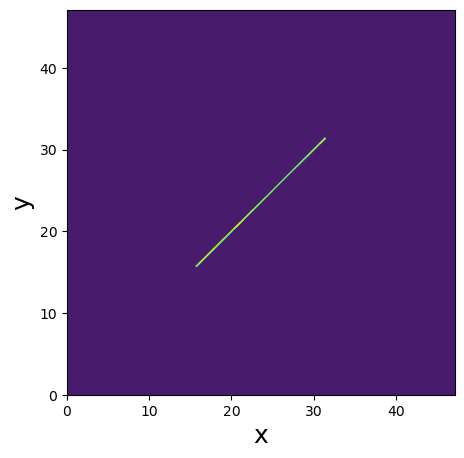

In [4]:
## Beam Splitter 
ss=[x0_a, y0_a, kx0_a, ky0_a, sigma_x_a, sigma_y_a]
beam = QObeam(N, L, *ss)
splitter = QOobject(NA, layer, Dj, omega_j, N, L, center_nx, center_ny)
splitter.show()

In [5]:
## Time evolution parameter
dt       = 0.1
n_divide = 10
t_max    = 45.0

## Main routines

In [6]:
def gen_show_tlist(t_max, n_divide):
    tlist = []
    for i in range(int(t_max/dt)+1):
        t = i*dt
        tlist.append(t)
    res = [ elem[0] for elem in np.array_split(tlist, n_divide)]
    res.append(tlist[-1])
    return  res

def show_info(qosim, phi, t, deltax, plot_coincidence_density=False):
    print("#------- t=", round(t,3))
    prob_2ph=phi.phph.probability()
    prob_Aph = phi.Aph.probability()
    prob_phA = phi.phA.probability()
    prob_AA = phi.AA.probability()
    print("|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 = ", 
          round(prob_2ph,5),round(prob_Aph,5), round(prob_phA,5), round(prob_AA, 5),
         )
    print("sum |c|^2=", round(prob_2ph+prob_Aph+prob_phA+prob_AA, 5))
    # Energy
    eF=qosim.calc_EF(phi)
    eA=qosim.calc_EA(phi)
    eI=qosim.calc_EI(phi)
    econst=qosim.calc_Econst()
    print("E_F, E_A, E_I, econst =", round(eF,5), round(eA,5), round(eI,5), round(econst,5))
    print("Total energy = ", round(eF + eA + eI + econst, 5))
    print("Total energy - econst = ", round(eF + eA + eI,5))
    ## Check sum of photon number density
    mat = np.zeros((qosim.N[0], qosim.N[1]))
    for _obj in qosim.objects:
        for idx in _obj.atom_pos_indices:
            mat[idx[0],idx[1]] = 1
    if plot_coincidence_density==True:
        dict_rrstate_prime = copy.deepcopy(phi.phph.states[0].rr)
        dict_rrstate_commute = copy.deepcopy(phi.phph.states[1].rr)
        dn = int(deltax/(qosim.L[0]/qosim.N[0]))
        dict_rrstate_prime["2"]   = np.roll(dict_rrstate_prime["2"]  , dn, axis=0)
        dict_rrstate_commute["2"] = np.roll(dict_rrstate_commute["2"], dn, axis=0)
        coincide_state = dict_rrstate_prime["1"]*dict_rrstate_prime["2"] + dict_rrstate_commute["1"]*dict_rrstate_commute["2"]
        coincide_density = abs(coincide_state)**2
        interval_of_cf = np.linspace(0.0,0.2*10**(-6),21)
        im, title = qosim.show(coincide_density, t, levels=np.linspace(0.0,0.2*10**(-6),21), extend="both", cmap='coolwarm')
    else:
        density = phi.phph.partial_density(_in="rr")
        im, title = qosim.show(density, t, levels=np.linspace(0,0.00105,11), extend="both")
    plt.contour(qosim.qosim_1ph_a.x, qosim.qosim_1ph_a.y, mat.T, colors="gray")            
    plt.show()
    return im, title

def perfrom(init_phi, qosim, show_tlist, t_max, dt, deltax, plot_coincidence_density=False):
    ims = []
    for i in range(int(t_max/dt)+1):
        t = i*dt
        if i == 0:
            phi = copy.deepcopy(init_phi)
        if t in show_tlist:
            im, title = show_info(qosim, phi, t, deltax, plot_coincidence_density)
            ims.append(im.collections + [title])        
        ##
        phi = qosim.suzuki_trotter_step(phi)
    return phi, ims
    
show_tlist = gen_show_tlist(t_max, n_divide=n_divide)

#------- t= 0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


/Users/junpei/miniforge3/envs/qosim/lib/python3.11/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


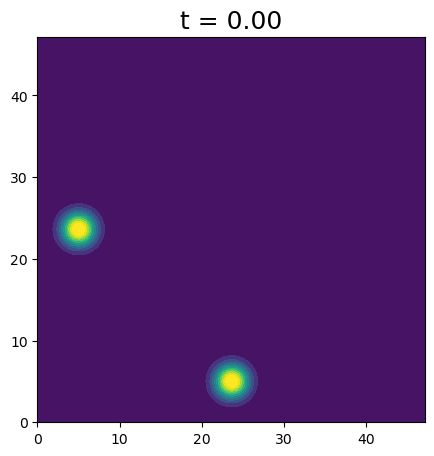

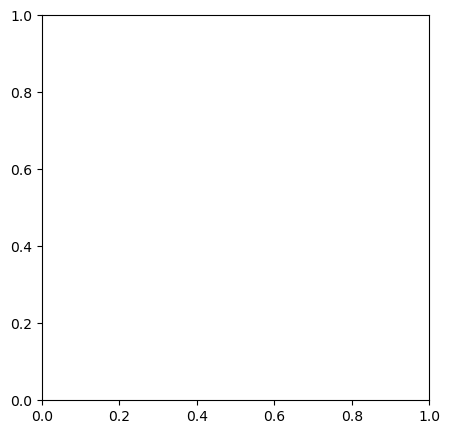

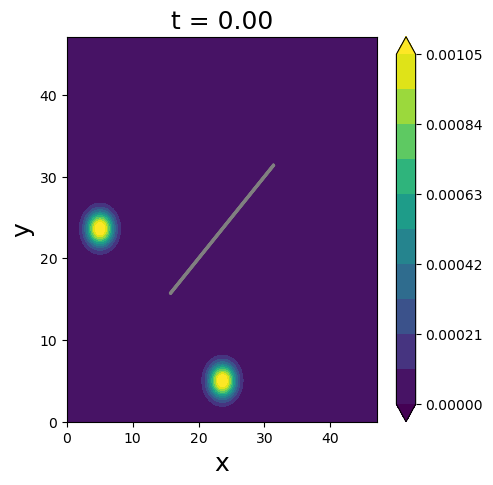

(<matplotlib.contour.QuadContourSet at 0x10fd18a90>,
 Text(0.5, 1.01, 't = 0.00'))

In [7]:
## check the setup
t = 0
deltax = 0
## set beam
x0_a_deltax = x0_a + deltax
sa=[x0_a_deltax, y0_a, kx0_a, ky0_a, sigma_x_a, sigma_y_a]
sb=[x0_b,        y0_b, kx0_b, ky0_b, sigma_x_b, sigma_y_b]
beam_a = QObeam(N, L, *sa)
beam_b = QObeam(N, L, *sb)
## initialization
qosim = QOsimulator_2ph(N, L, dt, beams = [beam_a, beam_b], objects=[splitter])
init_phi = qosim.gen_initial_state()
show_info(qosim, init_phi, t, deltax)

deltax= -10.0
#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


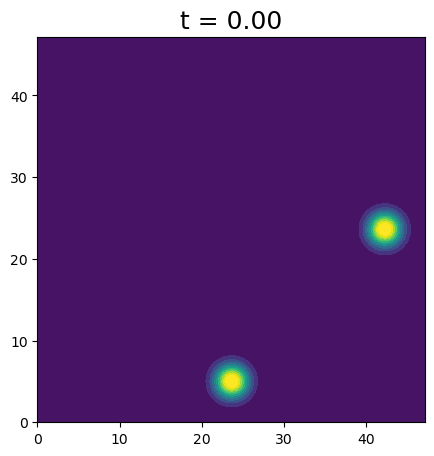

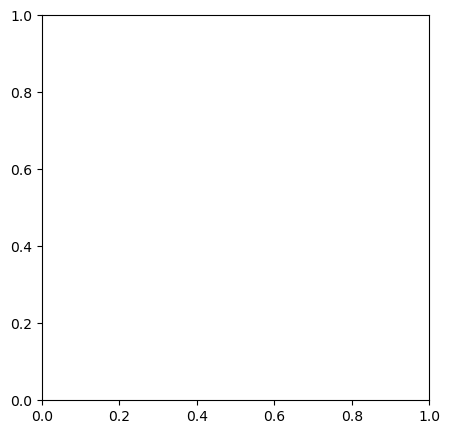

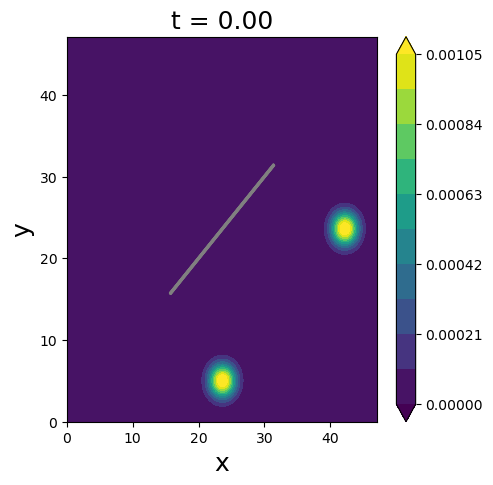

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


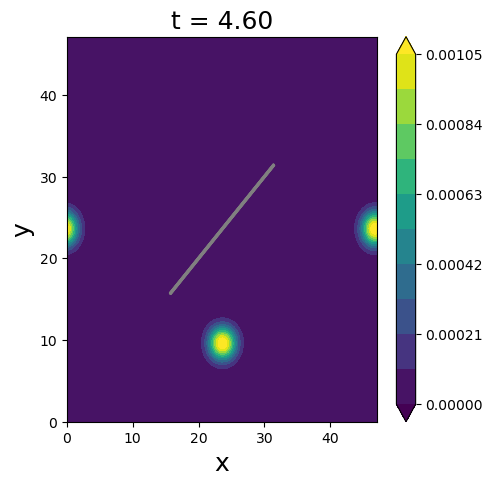

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02502 0.0 1e-05 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


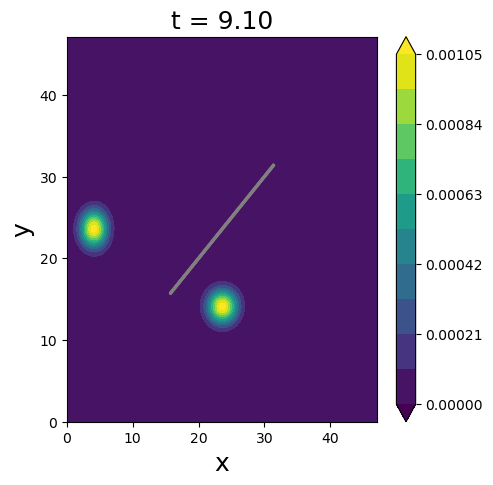

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99875 0.0 0.00125 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.0069 0.0 0.01049 -86.784
Total energy =  -76.76661
Total energy - econst =  10.01739


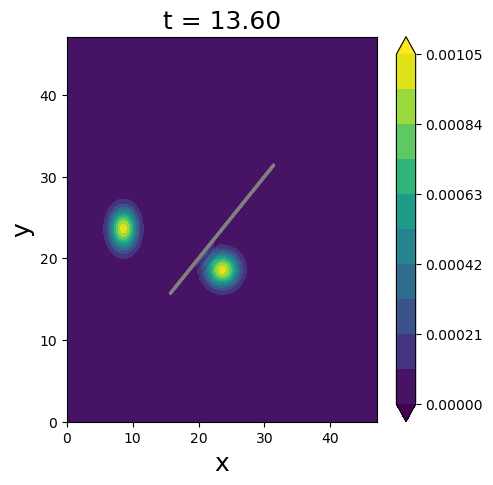

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98497 0.0 0.01503 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.80617 0.0 0.12719 -86.784
Total energy =  -76.85064
Total energy - econst =  9.93336


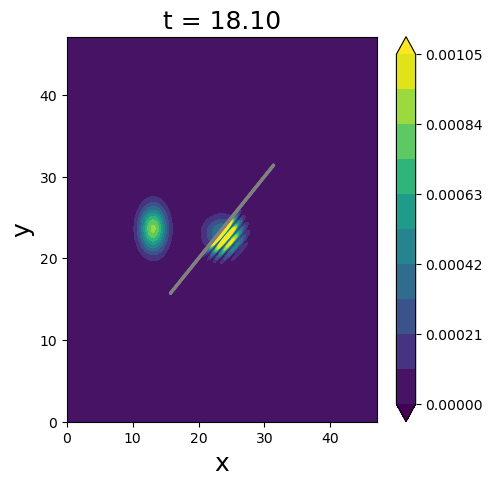

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99462 0.00087 0.0045 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.94702 1e-05 0.04525 -86.784
Total energy =  -76.79172
Total energy - econst =  9.99228


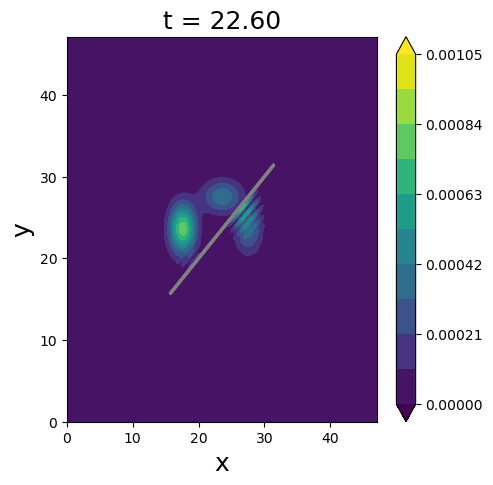

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98839 0.01147 0.00014 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.85612 0.0 0.09815 -86.784
Total energy =  -76.82973
Total energy - econst =  9.95427


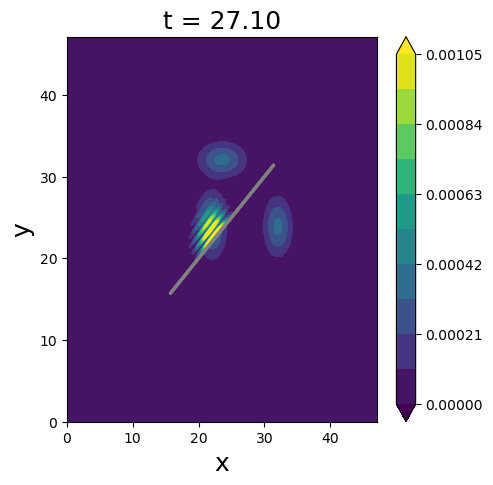

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99249 0.00751 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.91579 0.0 0.06343 -86.784
Total energy =  -76.80479
Total energy - econst =  9.97921


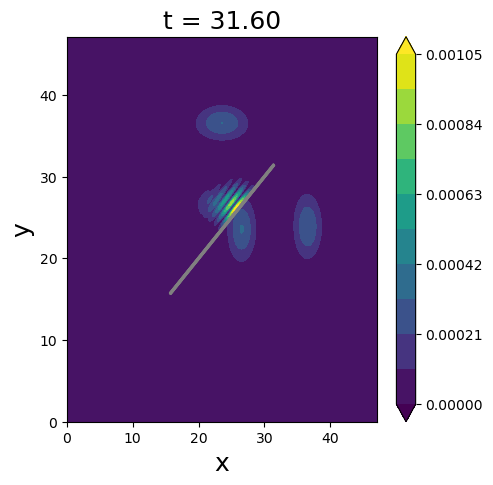

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99918 0.00082 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.0132 0.0 0.00684 -86.784
Total energy =  -76.76396
Total energy - econst =  10.02004


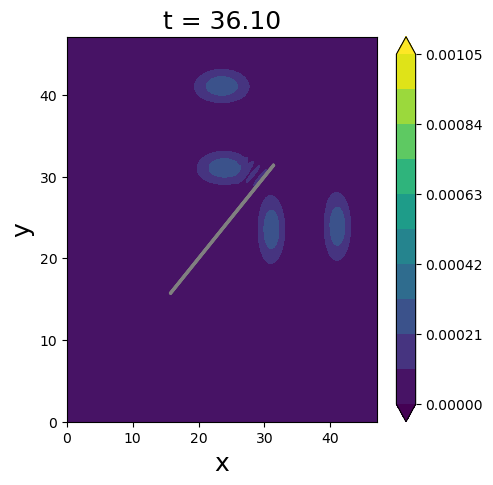

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02499 0.0 2e-05 -86.784
Total energy =  -76.75899
Total energy - econst =  10.02501


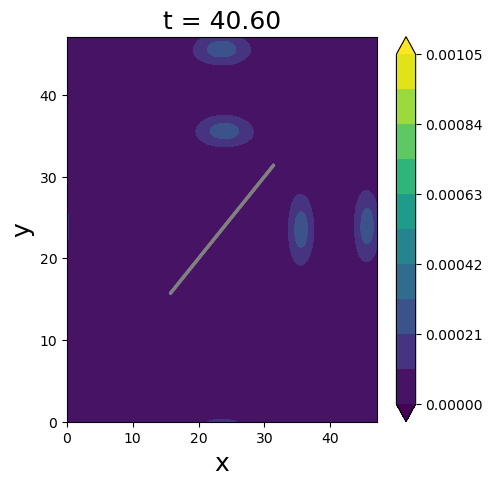

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


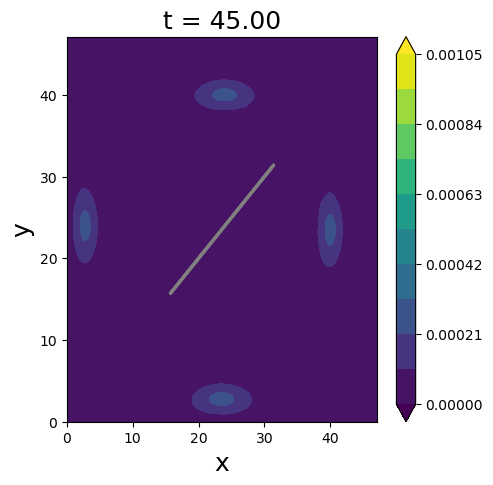

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


/var/folders/1b/1q00pcjs4hsfshz2cr7g4vwm0000gp/T/ipykernel_61421/7956871.py:49: UserWarning: No contour levels were found within the data range.
  plt.contour(qosim.qosim_1ph_a.x, qosim.qosim_1ph_a.y, mat.T, colors="gray")


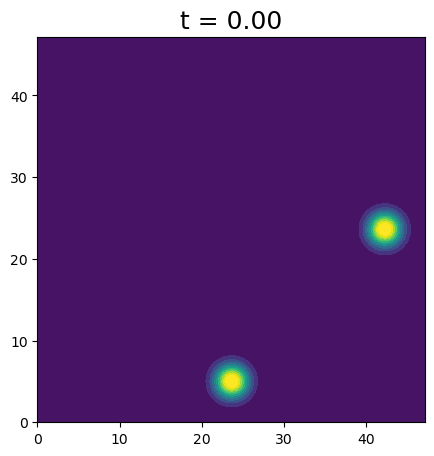

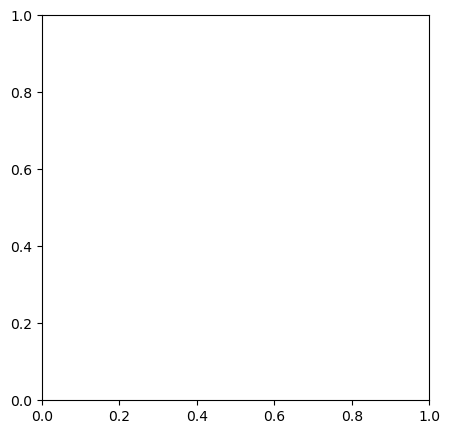

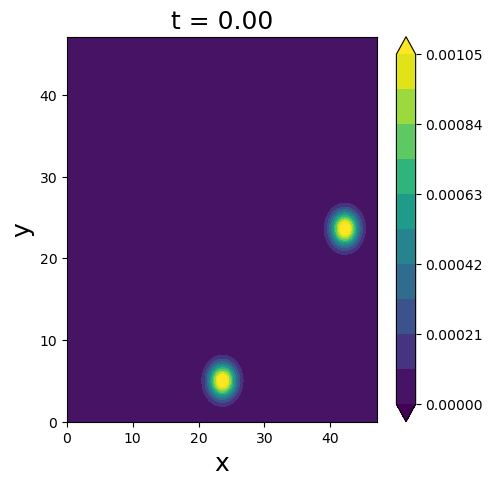

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


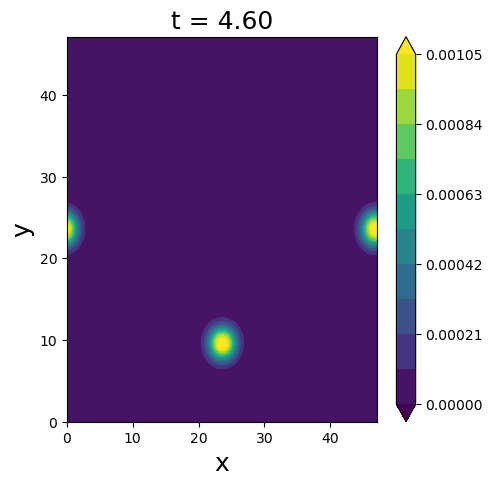

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


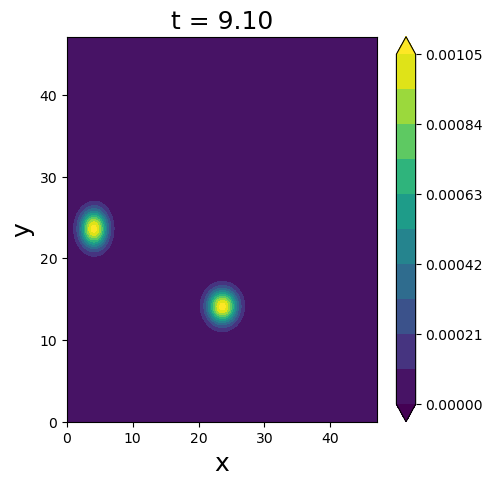

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


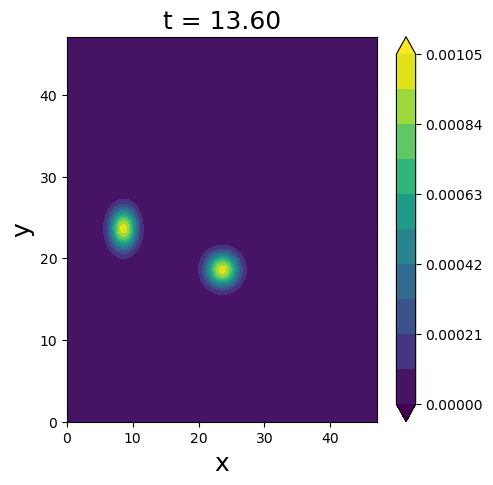

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


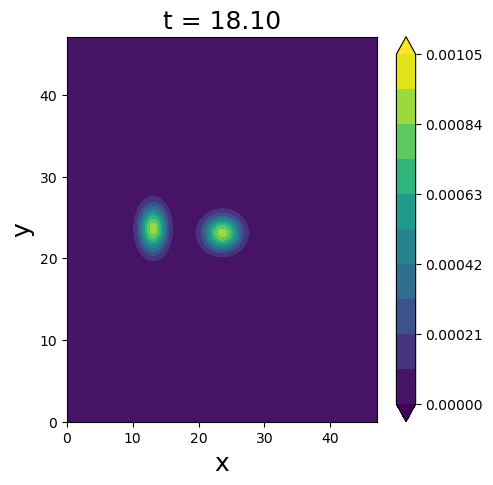

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


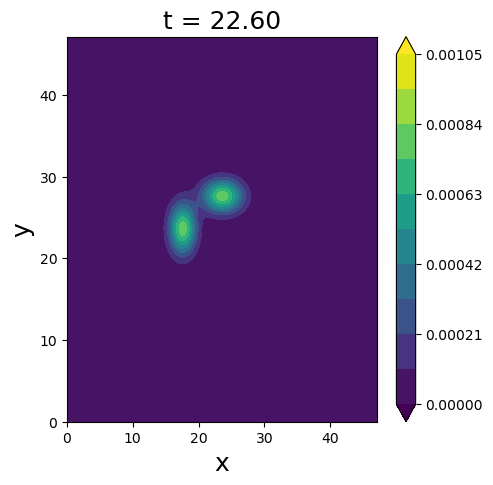

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


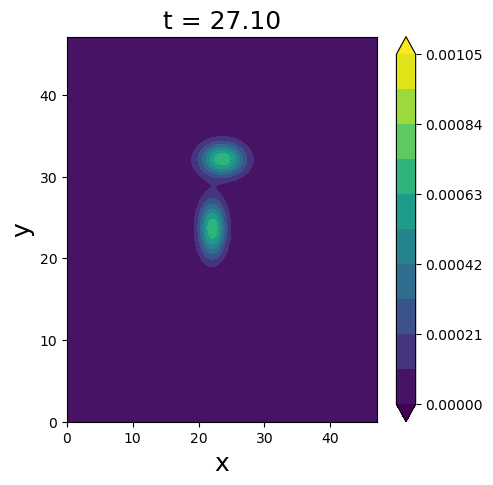

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


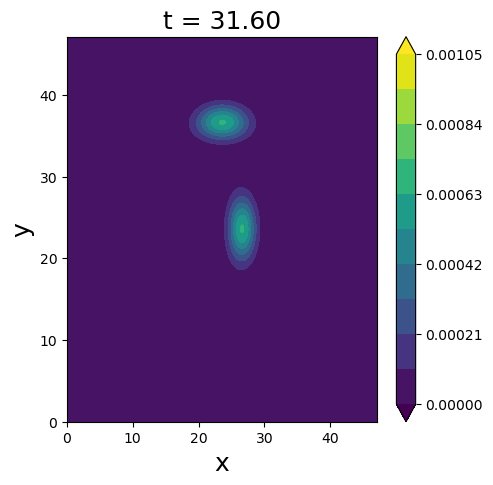

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


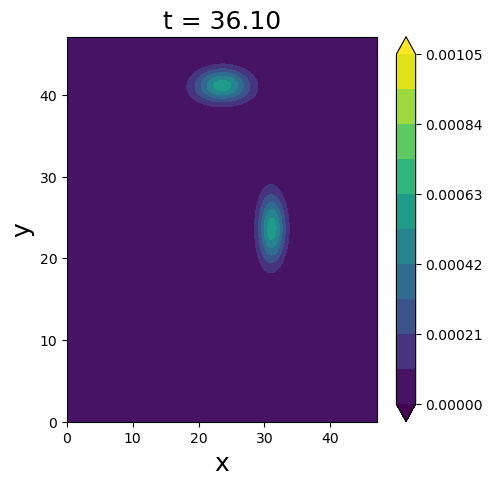

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


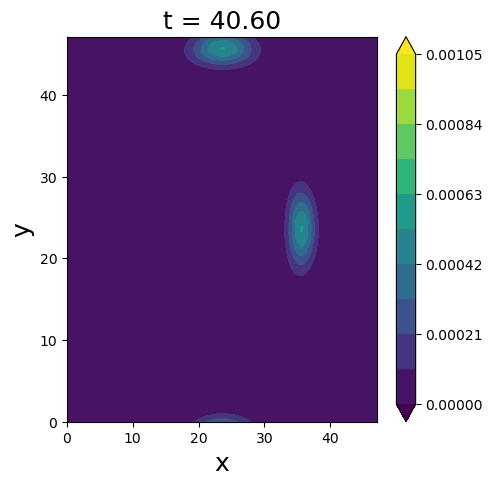

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


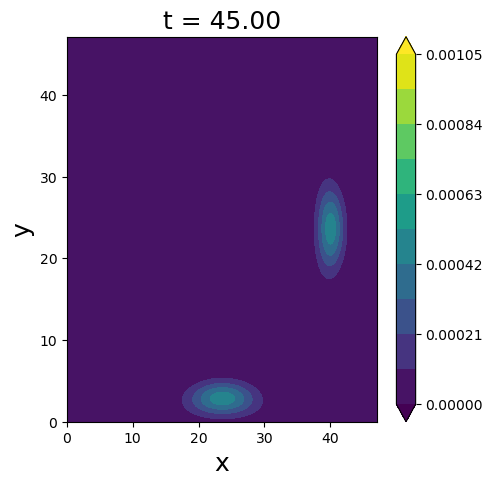

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


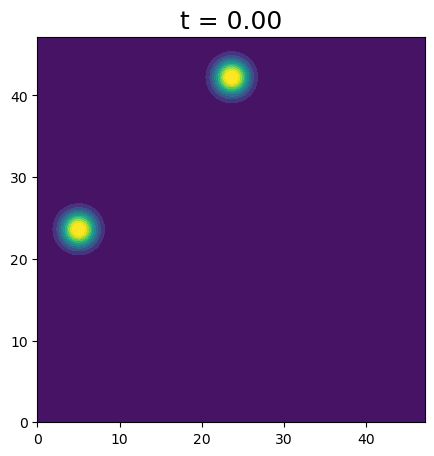

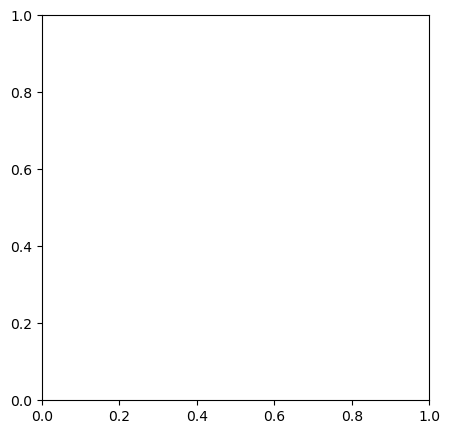

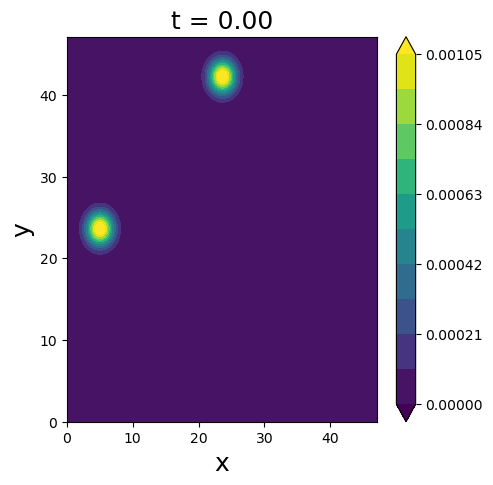

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


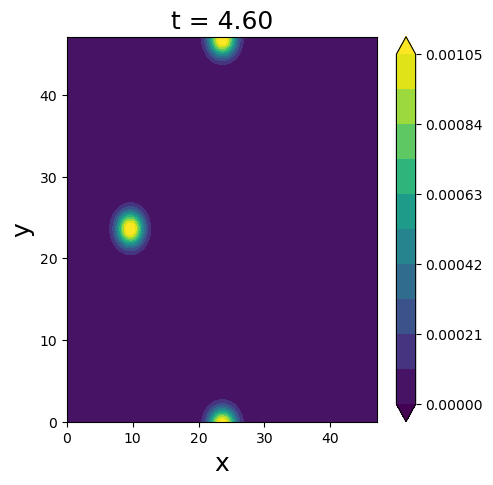

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


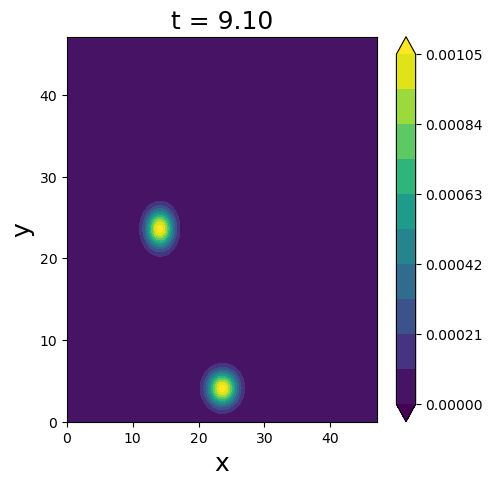

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


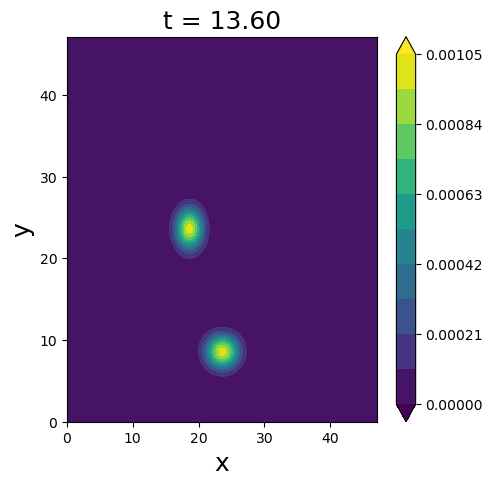

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


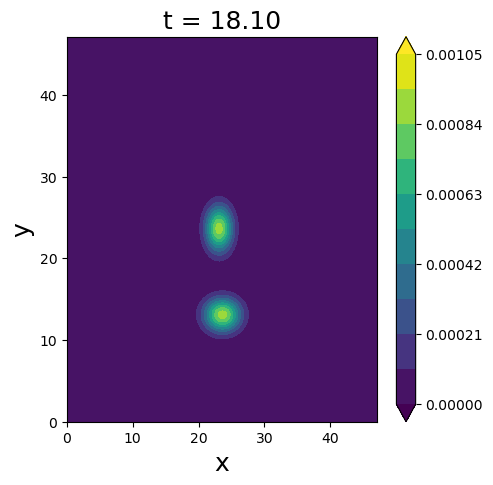

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


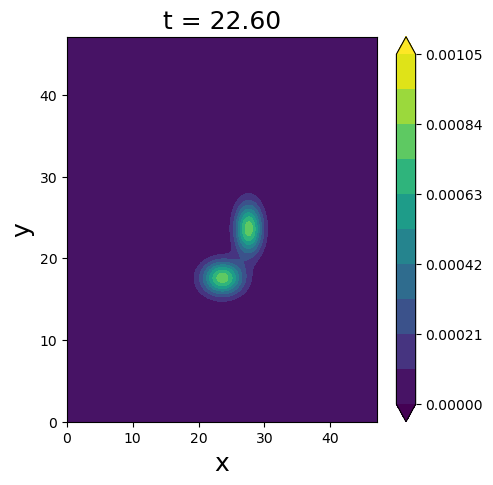

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


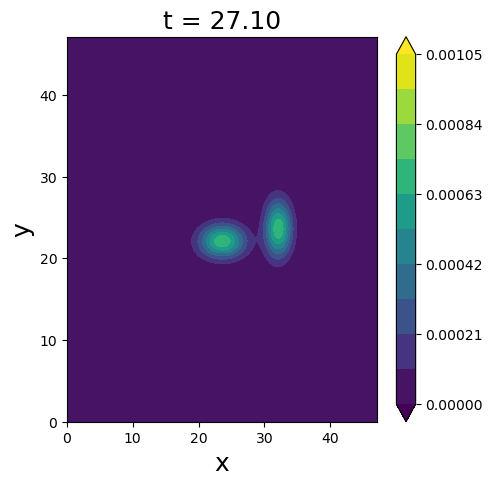

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


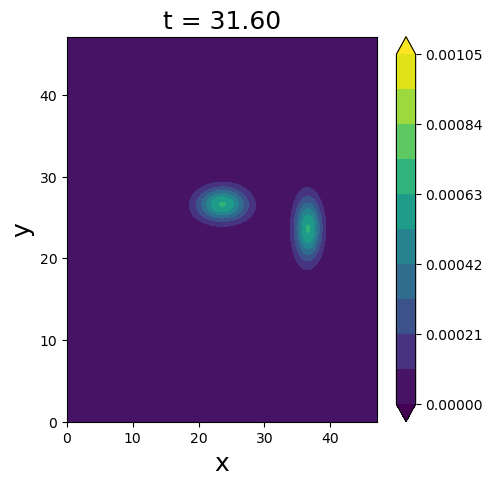

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


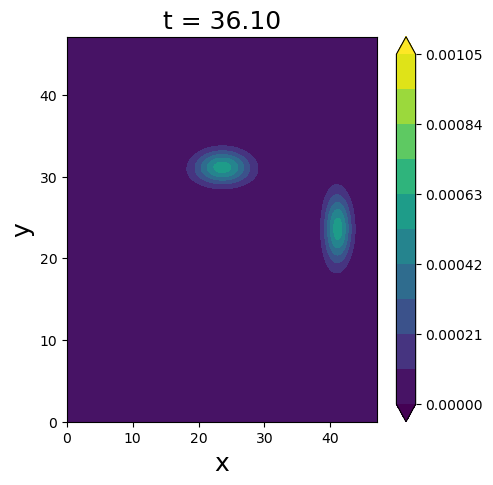

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


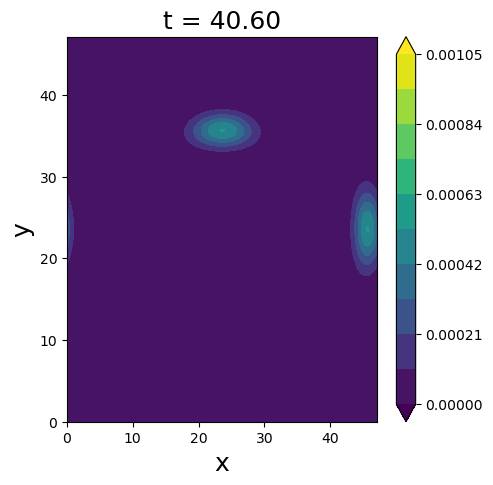

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


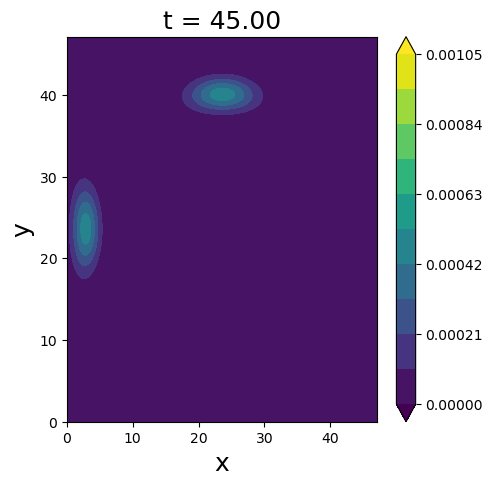

coincidence probability = 0.4938
deltax= -6.0
#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


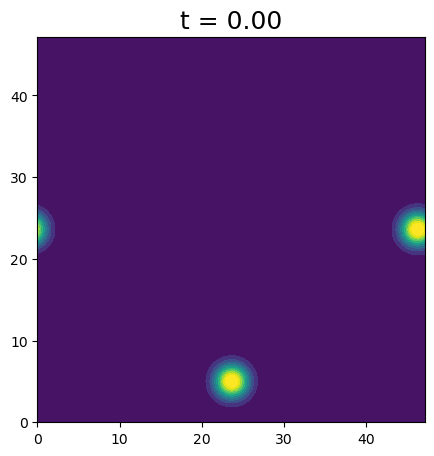

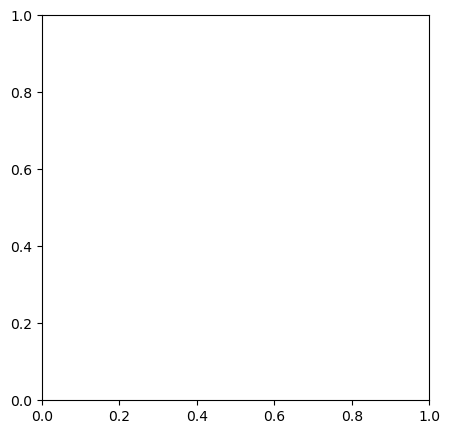

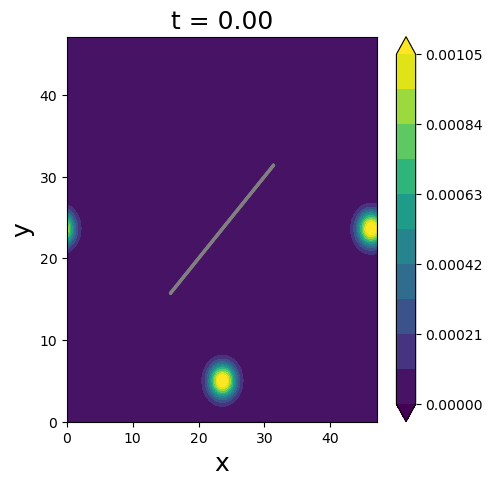

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


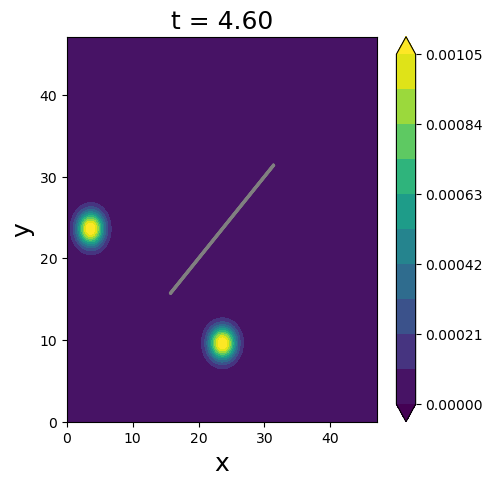

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02502 0.0 1e-05 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


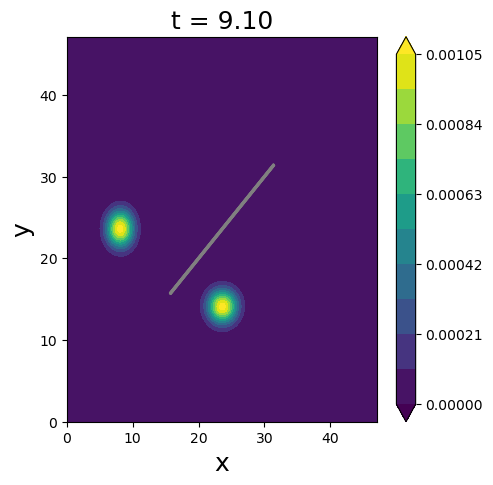

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99875 0.0 0.00125 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.0069 0.0 0.01049 -86.784
Total energy =  -76.76661
Total energy - econst =  10.01739


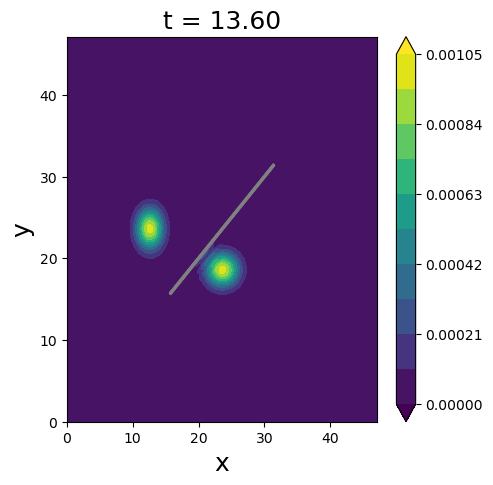

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98462 0.00034 0.01503 1e-05
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.80123 1e-05 0.1301 -86.784
Total energy =  -76.85267
Total energy - econst =  9.93133


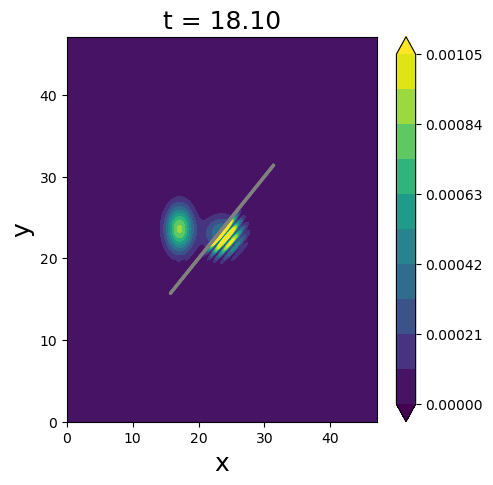

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.9851 0.01039 0.00446 5e-05
sum |c|^2= 1.00001
E_F, E_A, E_I, econst = 9.80859 6e-05 0.12617 -86.784
Total energy =  -76.84918
Total energy - econst =  9.93482


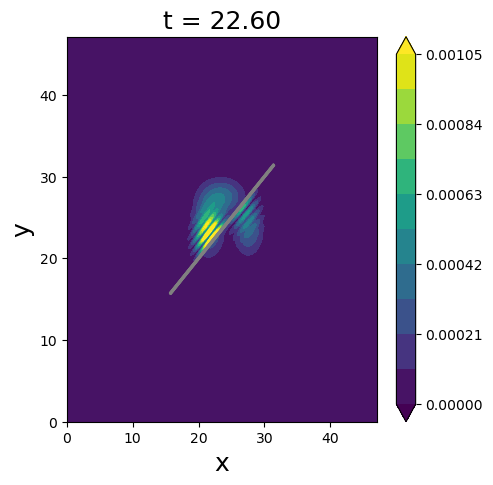

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99086 0.009 0.00014 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.89206 0.0 0.07722 -86.784
Total energy =  -76.81471
Total energy - econst =  9.96929


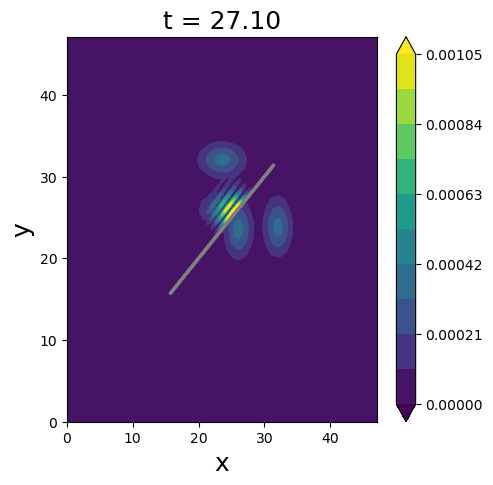

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99912 0.00088 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.01228 0.0 0.00737 -86.784
Total energy =  -76.76435
Total energy - econst =  10.01965


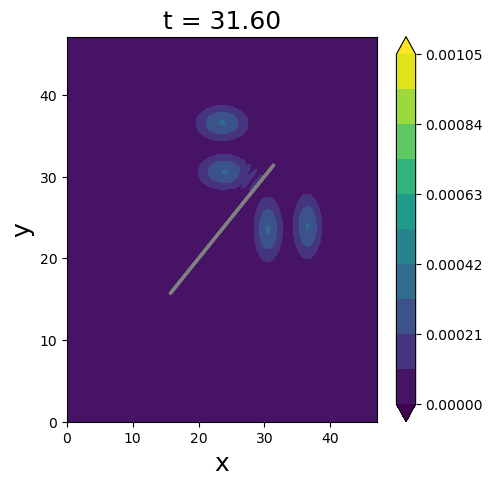

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99999 1e-05 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02496 0.0 4e-05 -86.784
Total energy =  -76.759
Total energy - econst =  10.025


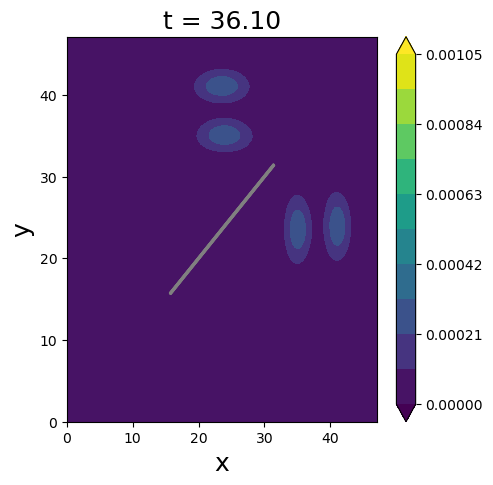

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


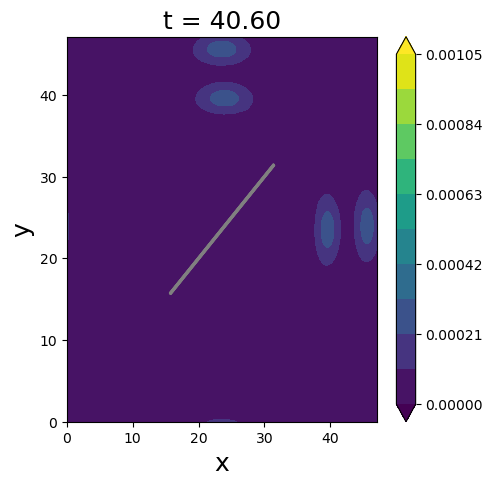

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


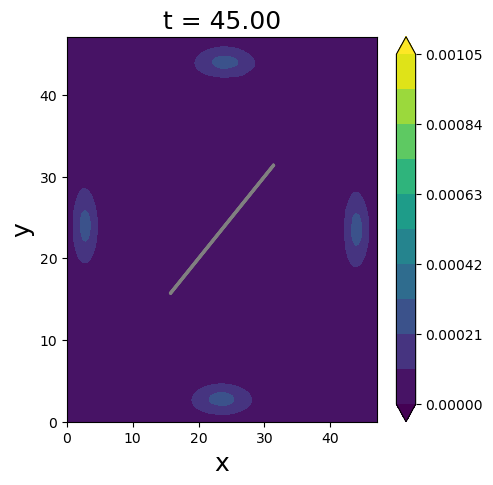

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


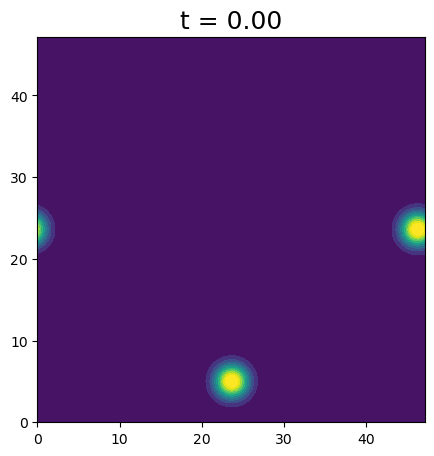

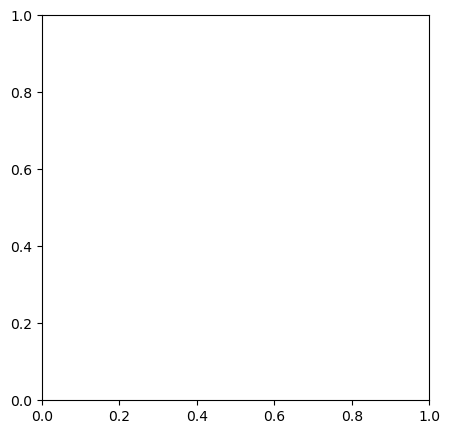

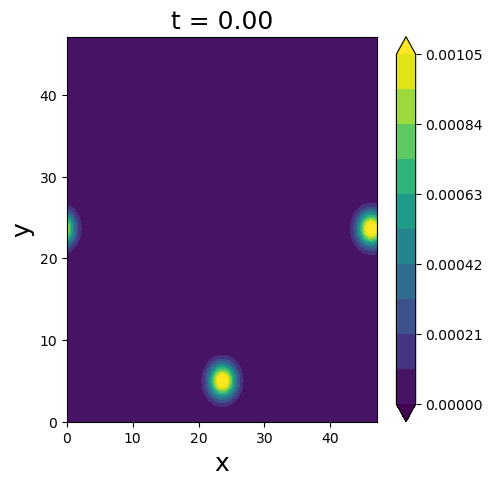

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


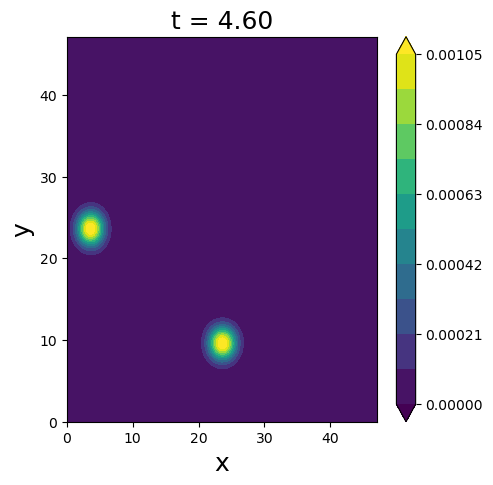

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


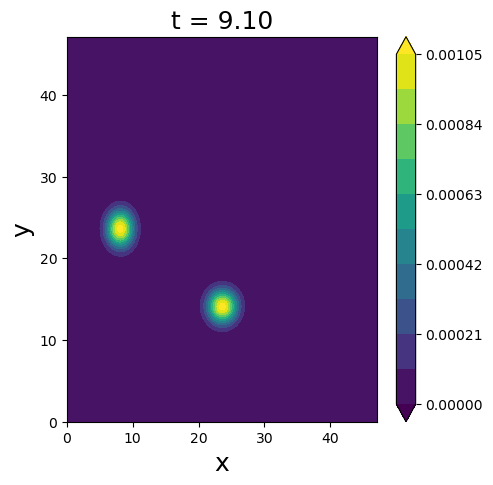

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


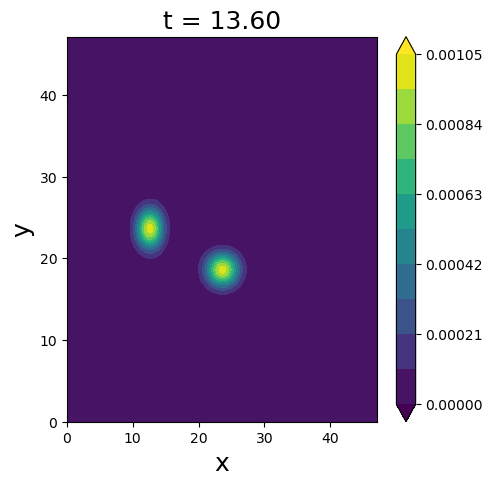

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


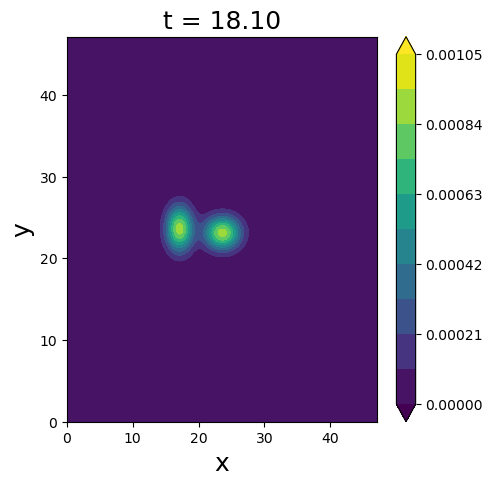

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


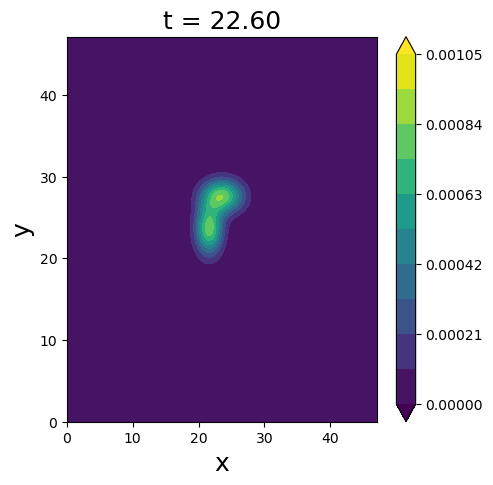

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


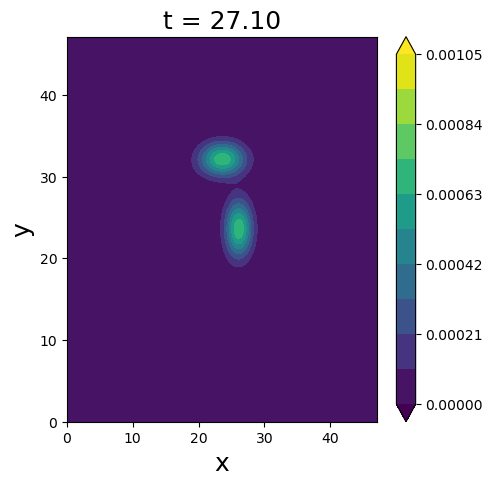

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


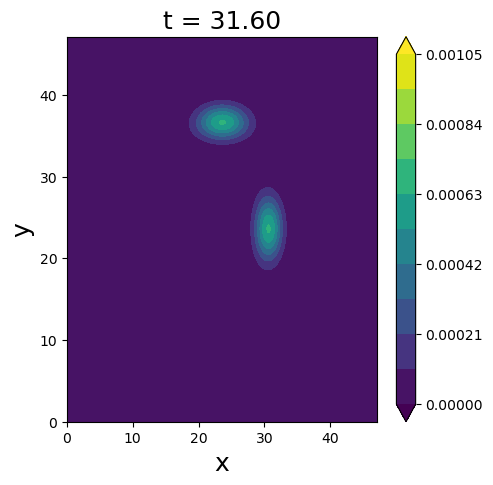

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


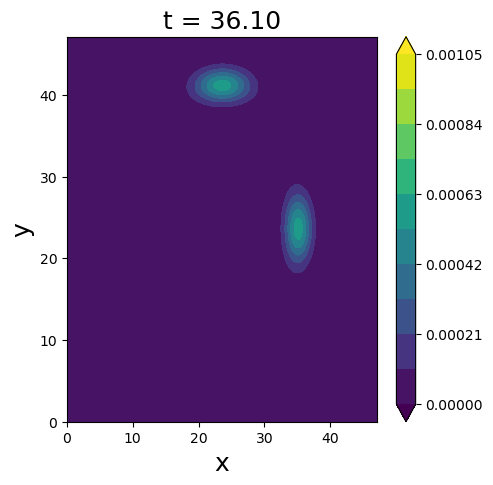

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


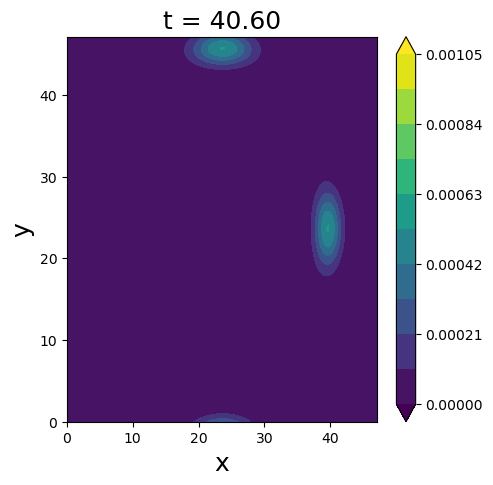

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


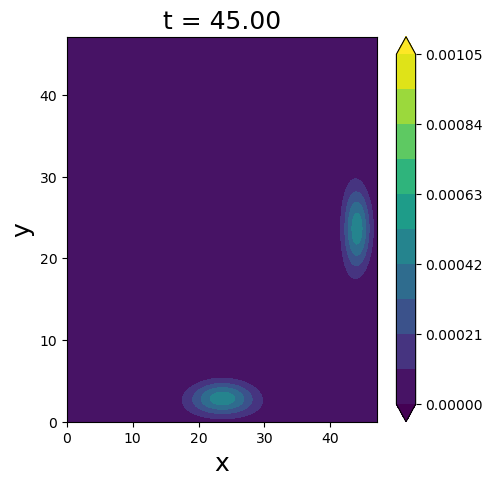

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


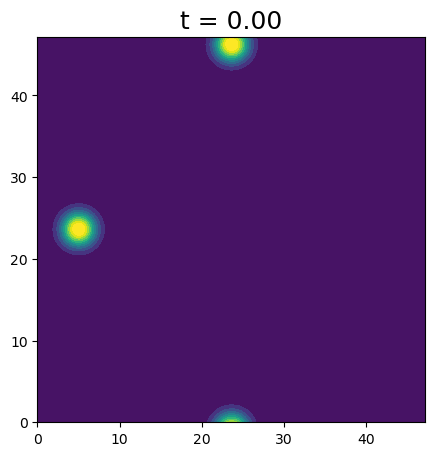

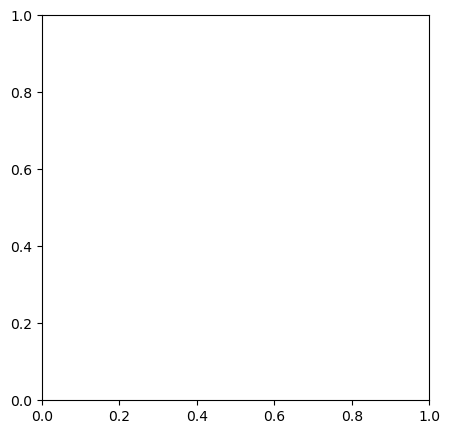

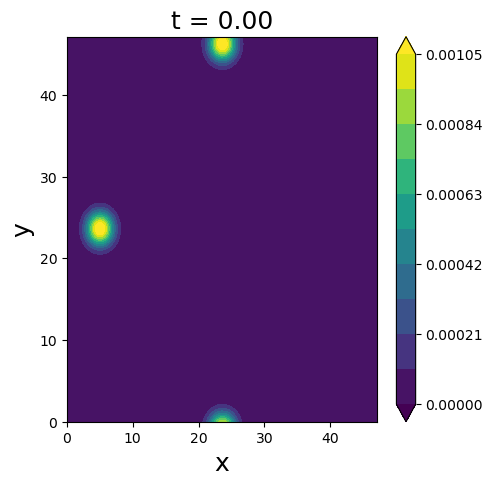

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


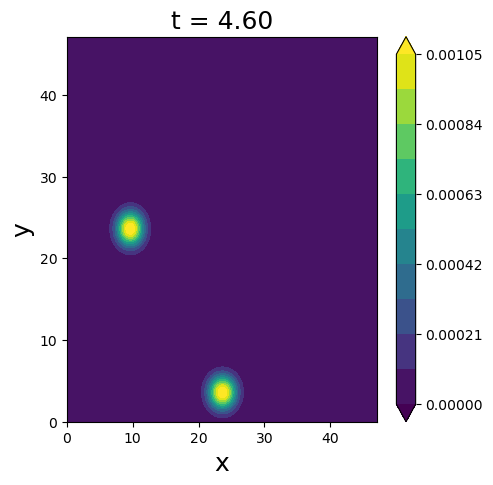

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


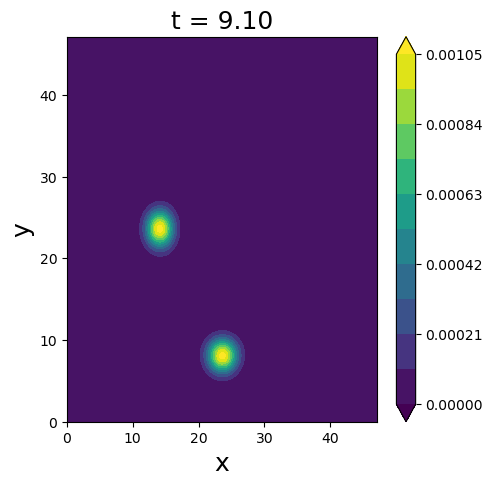

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


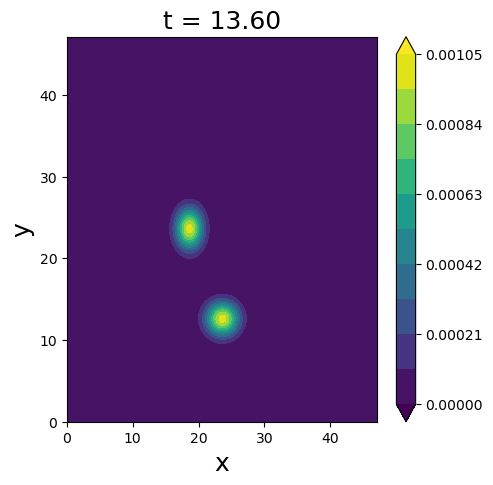

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


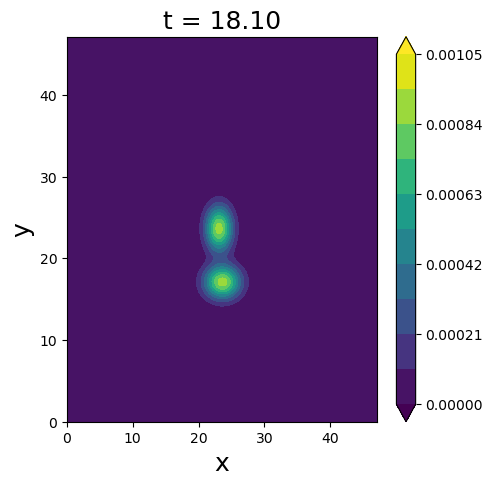

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


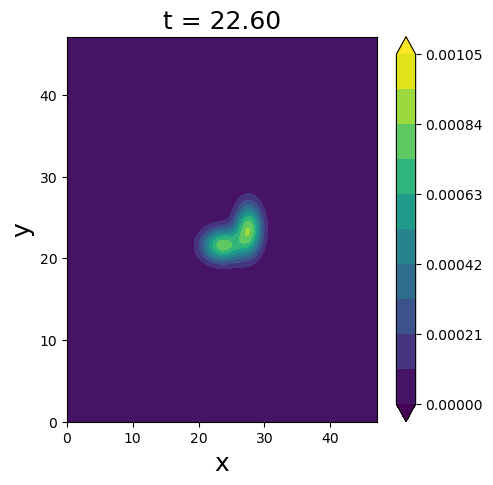

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


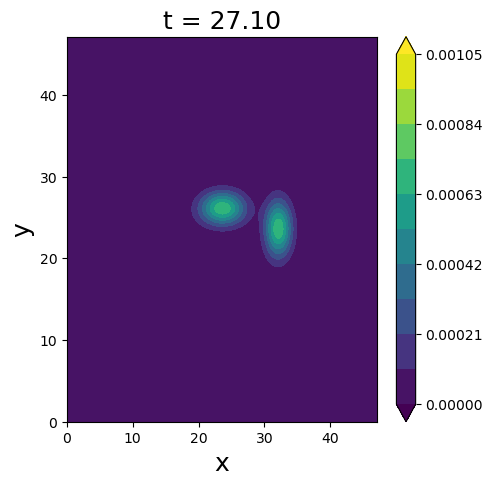

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


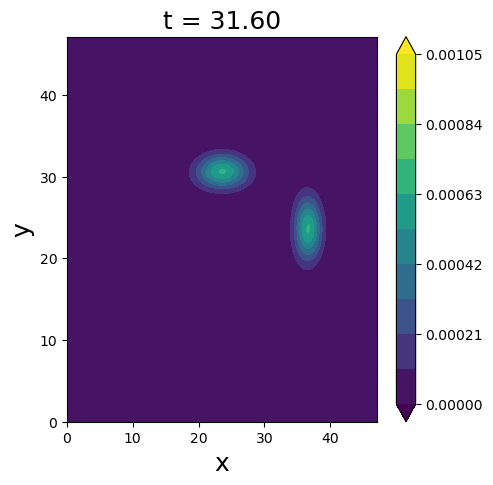

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


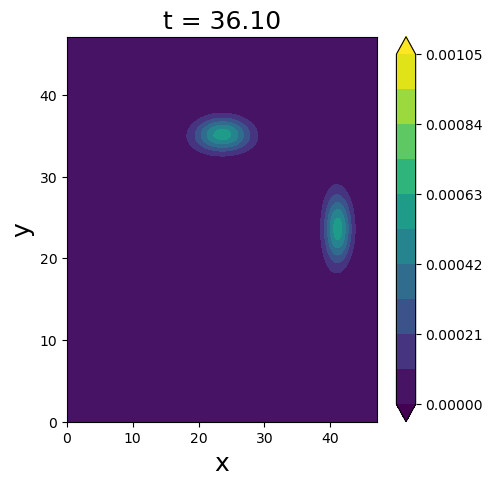

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


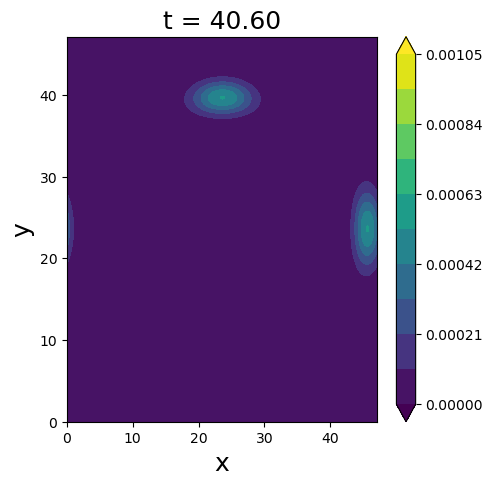

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


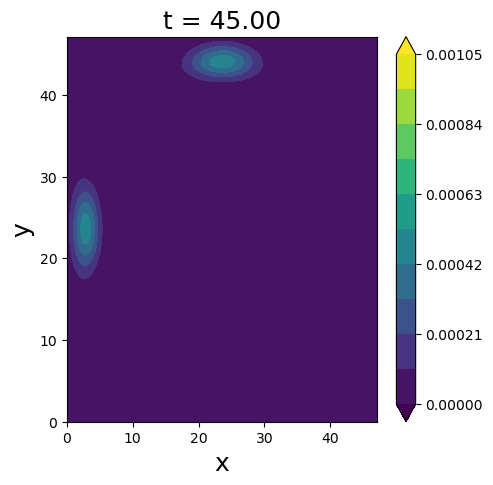

coincidence probability = 0.5004
deltax= -5.0
#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


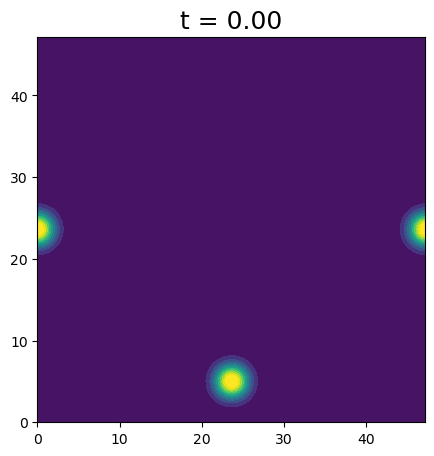

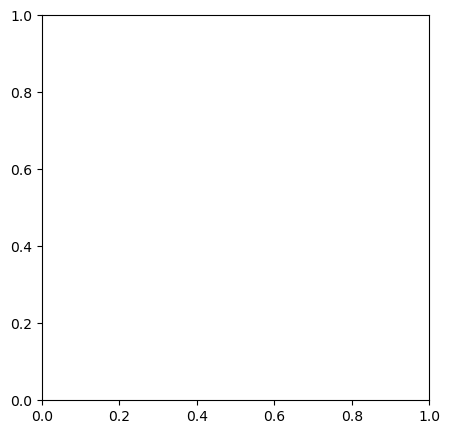

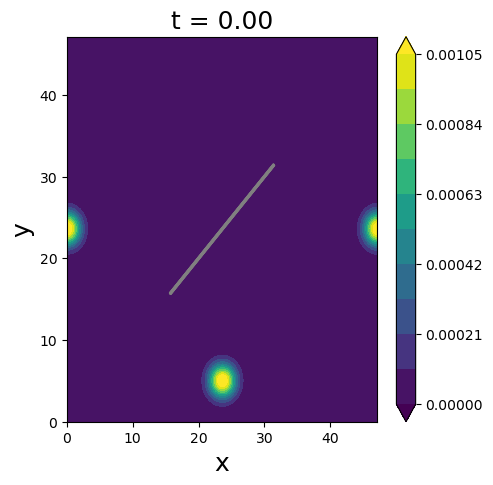

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


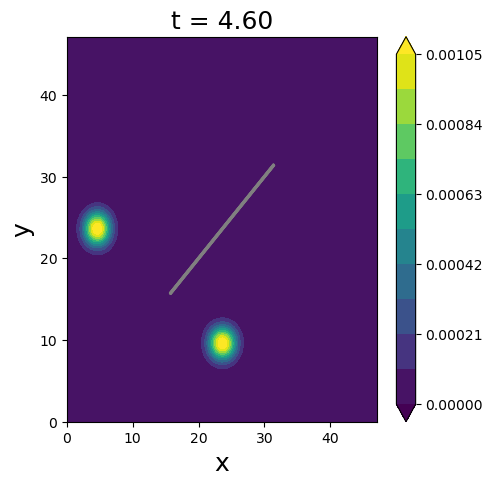

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02502 0.0 1e-05 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


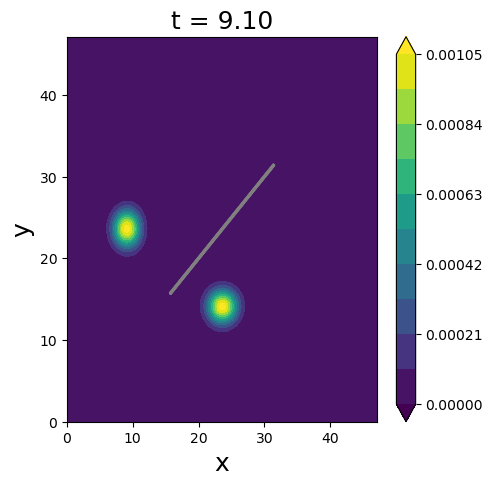

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99875 0.0 0.00125 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.00689 0.0 0.0105 -86.784
Total energy =  -76.76661
Total energy - econst =  10.01739


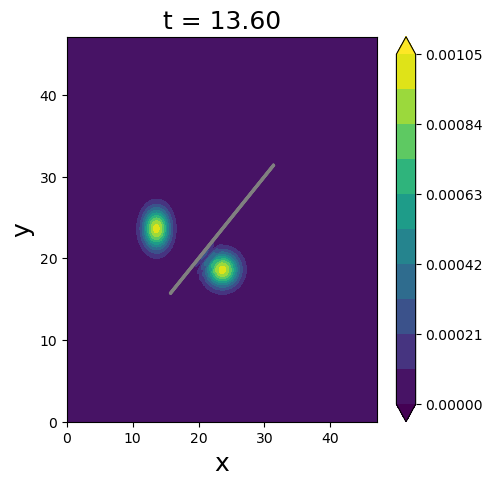

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98397 0.001 0.01502 2e-05
sum |c|^2= 1.00001
E_F, E_A, E_I, econst = 9.79182 2e-05 0.13566 -86.784
Total energy =  -76.85651
Total energy - econst =  9.92749


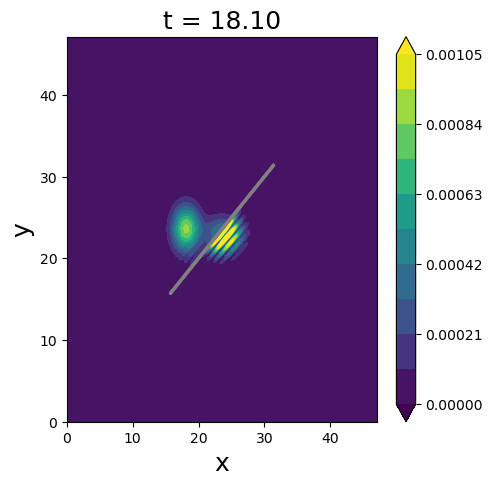

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98233 0.01317 0.00445 7e-05
sum |c|^2= 1.00002
E_F, E_A, E_I, econst = 9.7681 8e-05 0.14987 -86.784
Total energy =  -76.86594
Total energy - econst =  9.91806


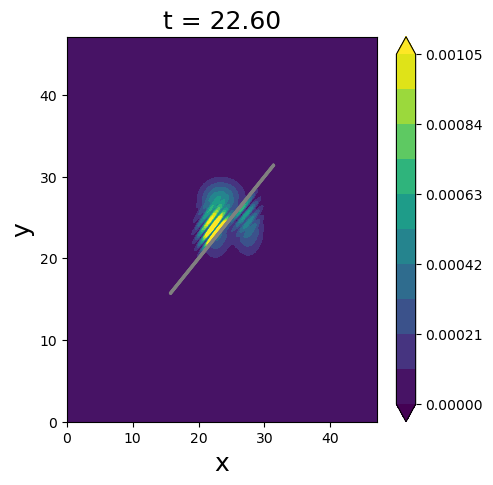

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.9937 0.00616 0.00014 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.93344 0.0 0.05315 -86.784
Total energy =  -76.79741
Total energy - econst =  9.98659


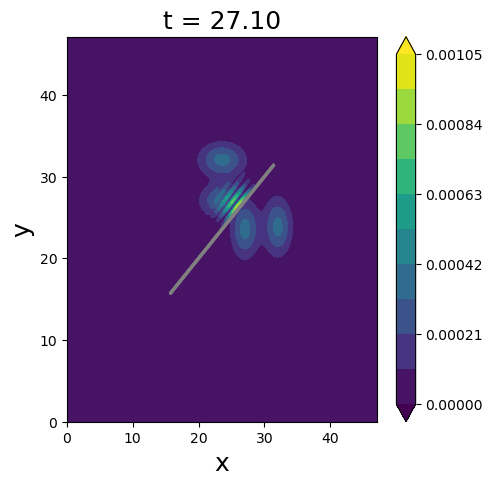

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99962 0.00038 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.01952 0.0 0.00318 -86.784
Total energy =  -76.7613
Total energy - econst =  10.0227


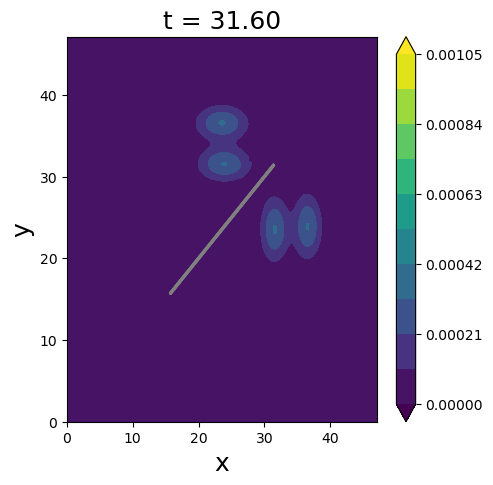

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02502 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


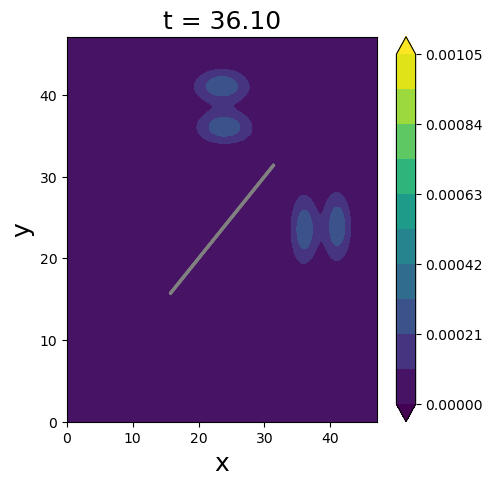

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


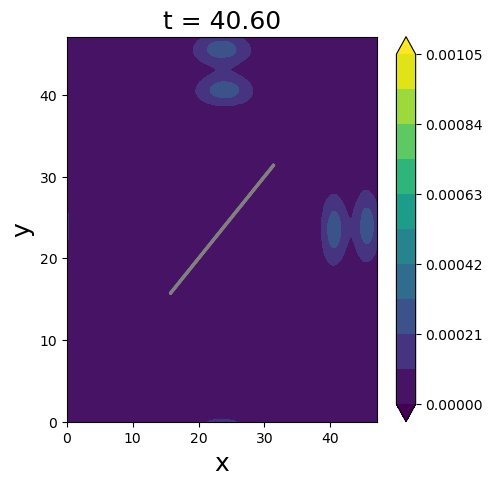

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


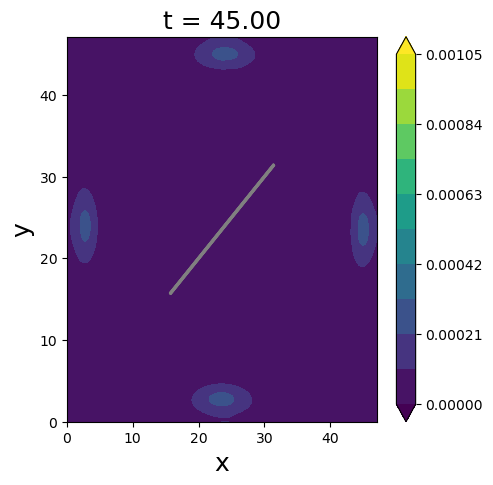

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


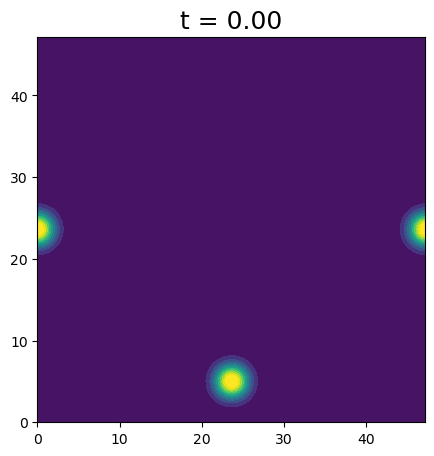

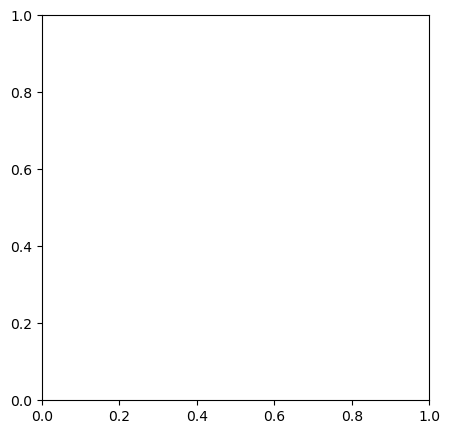

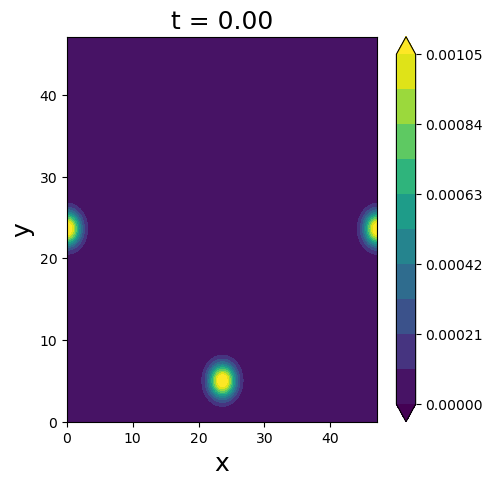

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


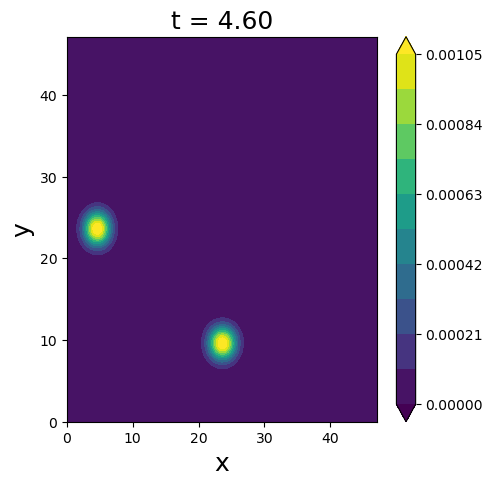

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


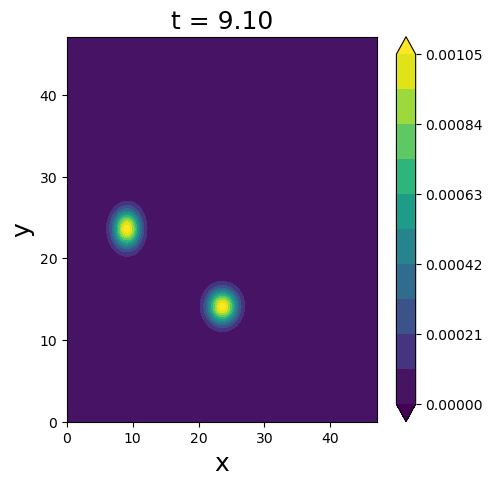

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


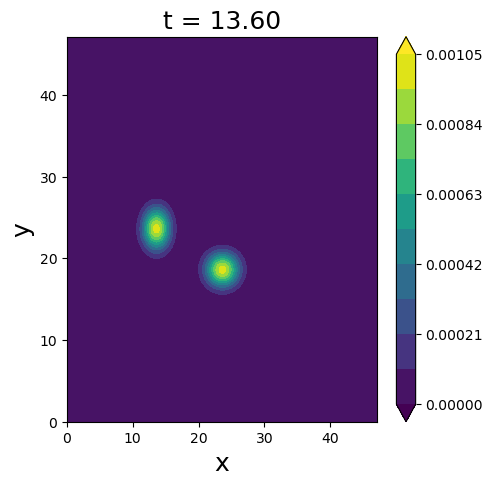

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


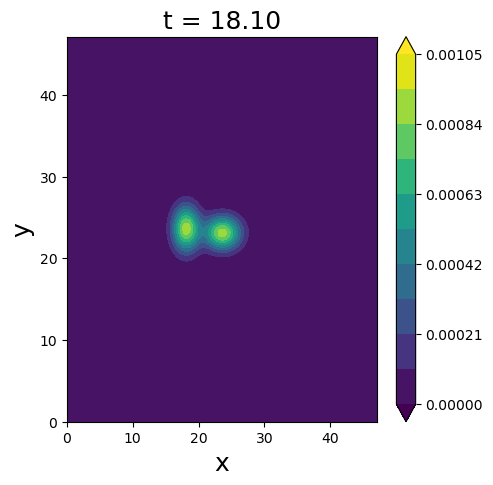

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


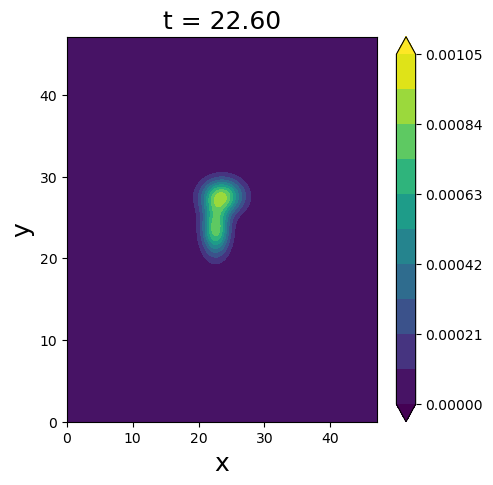

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


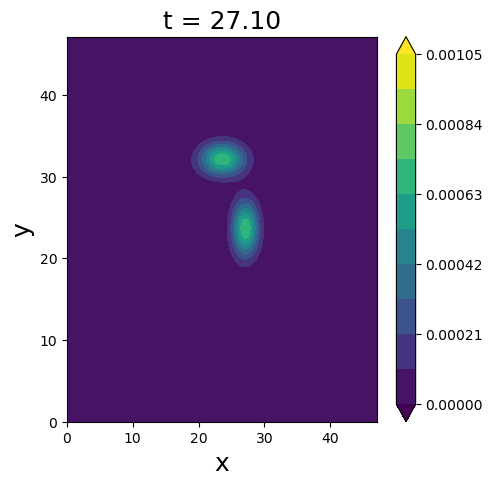

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


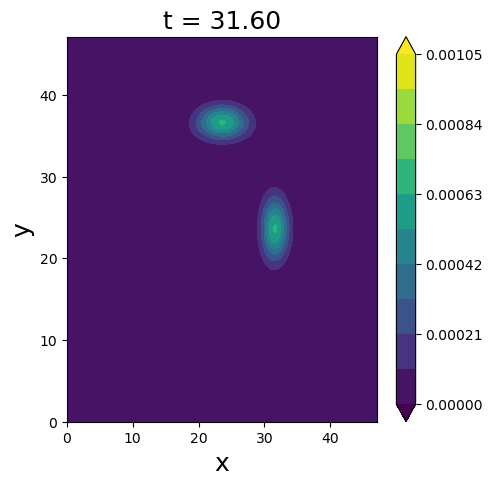

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


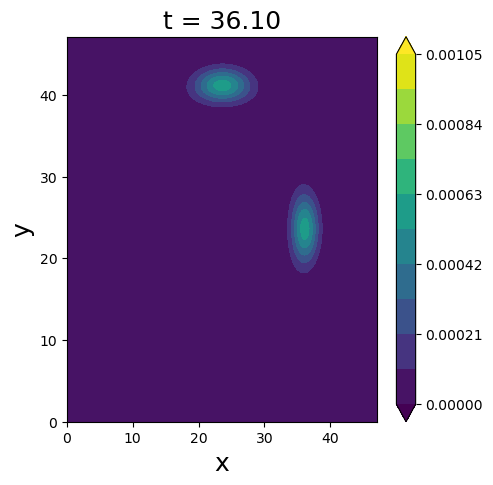

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


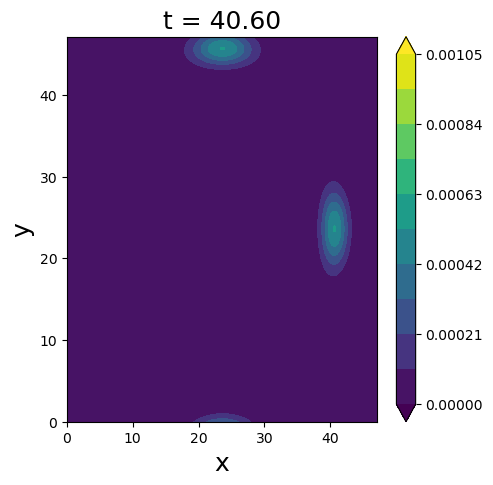

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


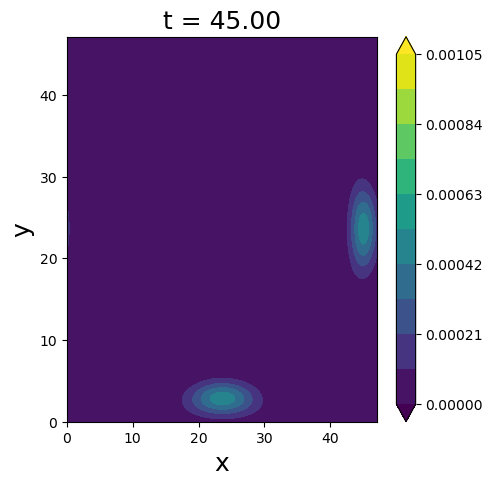

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


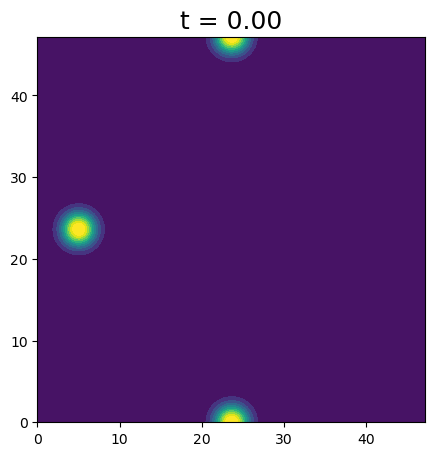

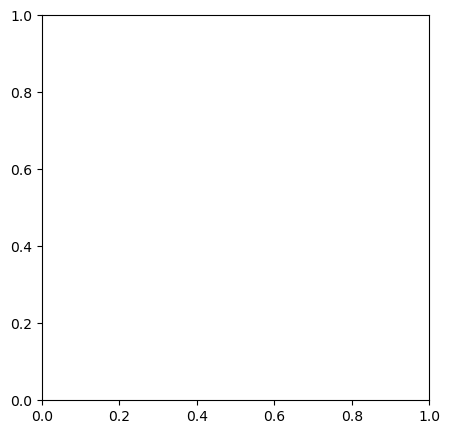

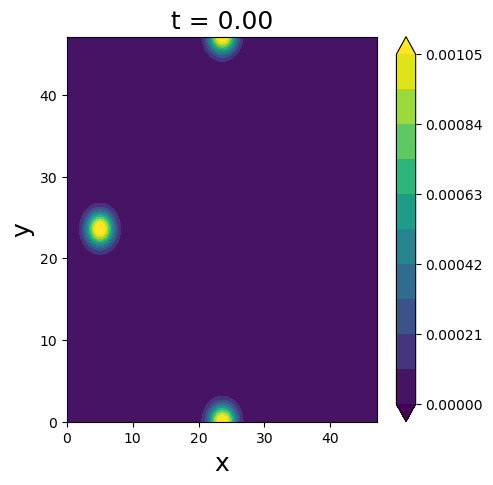

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


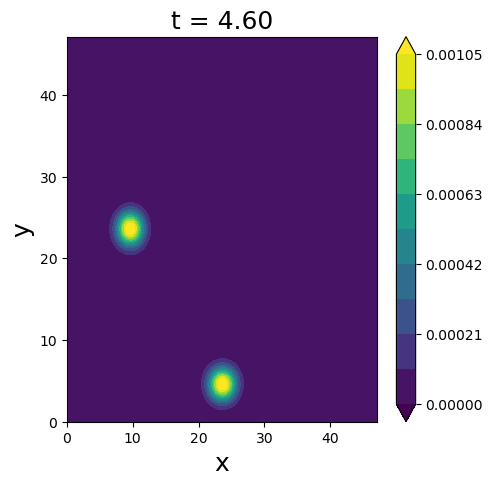

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


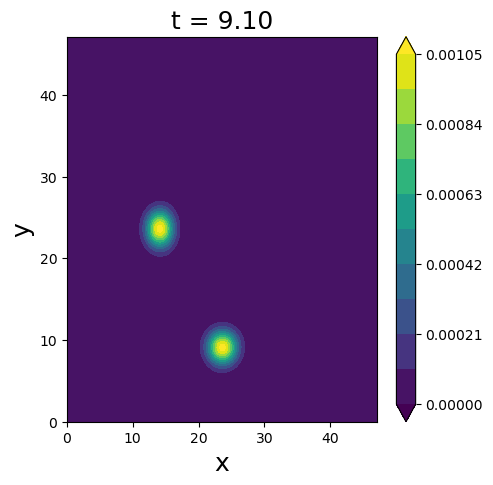

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


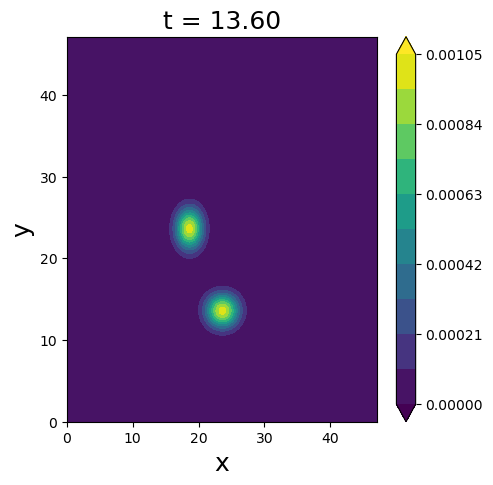

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


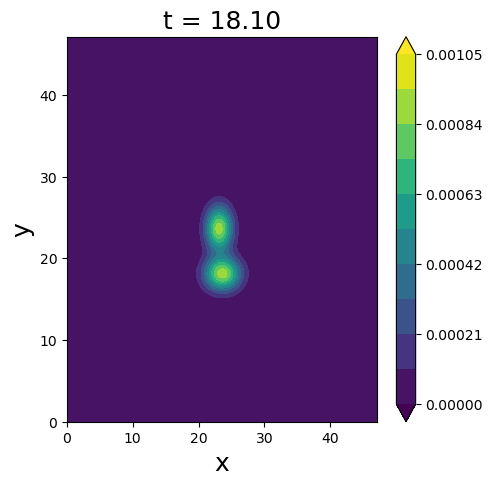

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


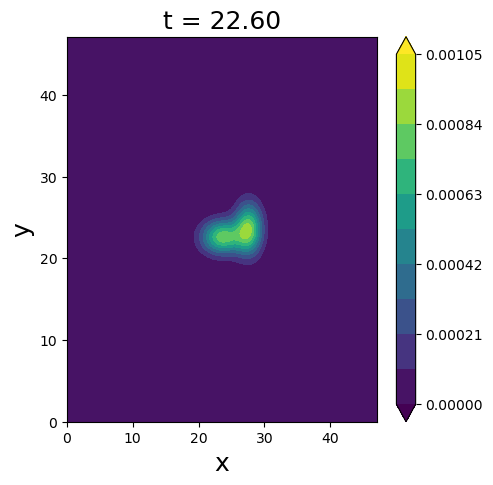

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


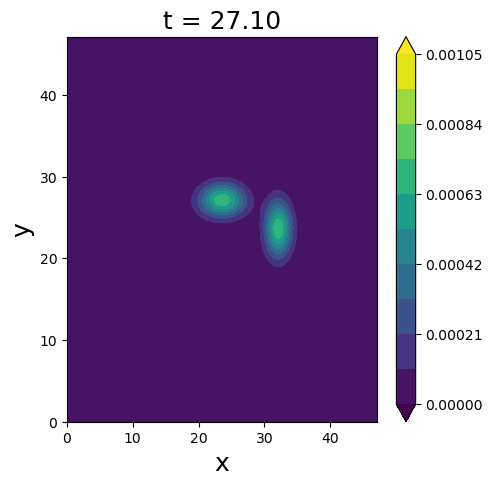

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


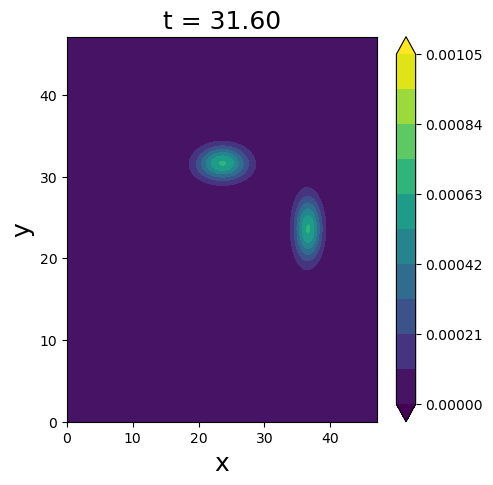

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


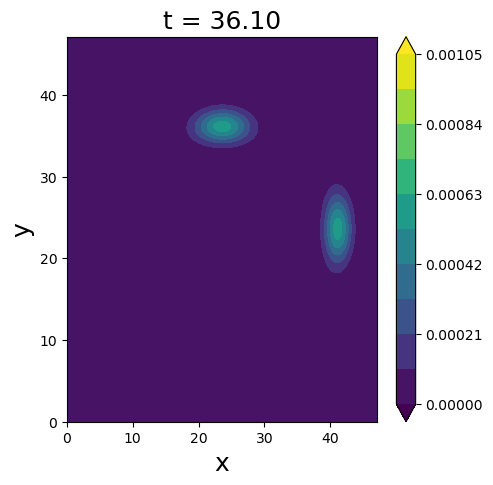

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


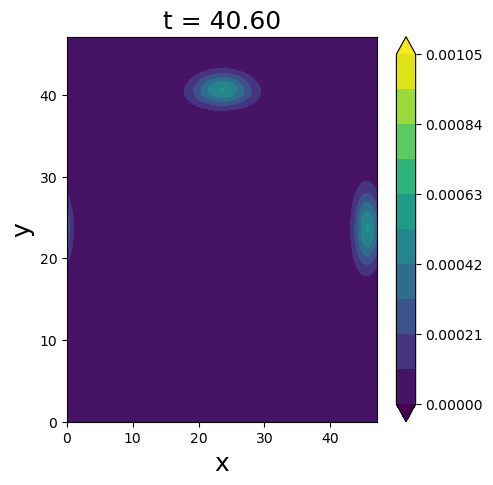

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


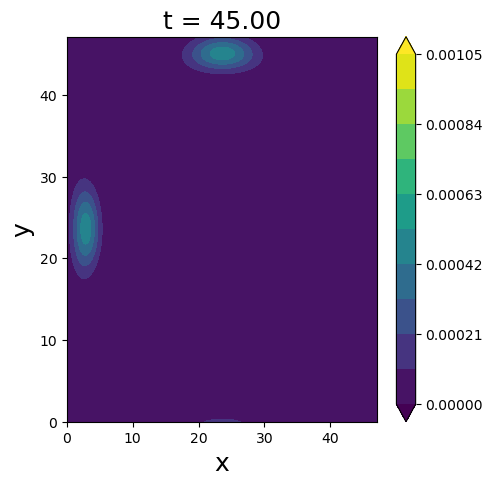

coincidence probability = 0.5168
deltax= -4.0
#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


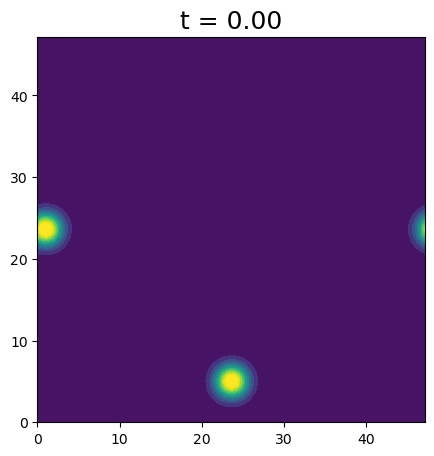

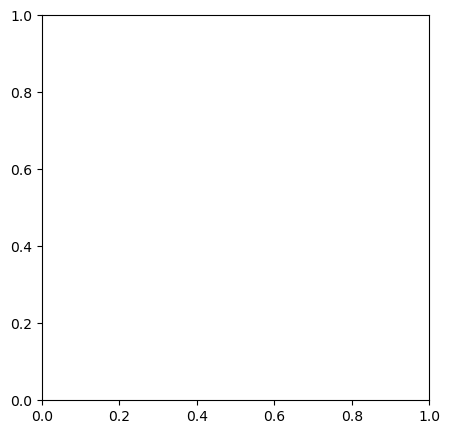

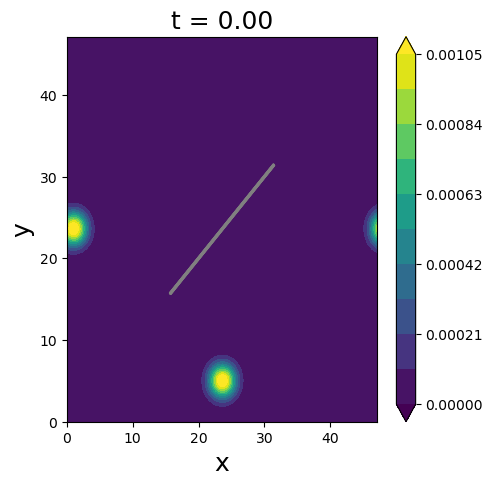

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


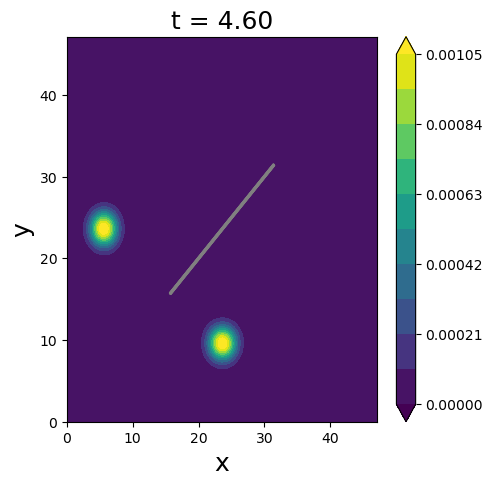

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02502 0.0 1e-05 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


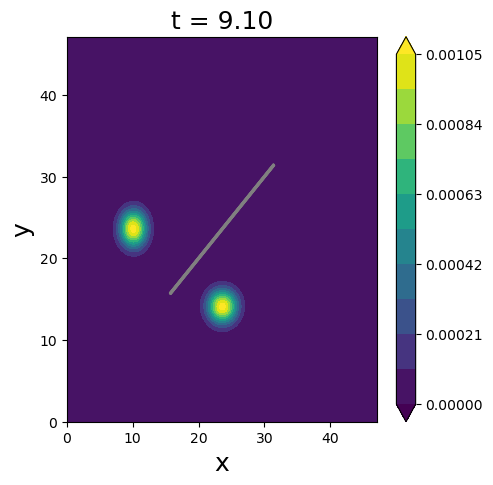

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99874 0.0 0.00125 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.00684 0.0 0.01053 -86.784
Total energy =  -76.76664
Total energy - econst =  10.01736


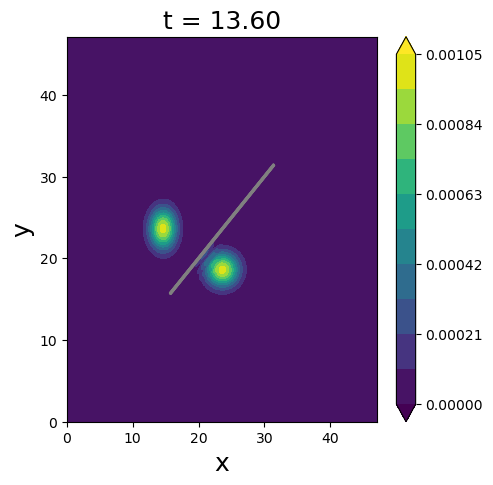

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98255 0.00243 0.015 5e-05
sum |c|^2= 1.00003
E_F, E_A, E_I, econst = 9.77121 5e-05 0.14785 -86.784
Total energy =  -76.86489
Total energy - econst =  9.91911


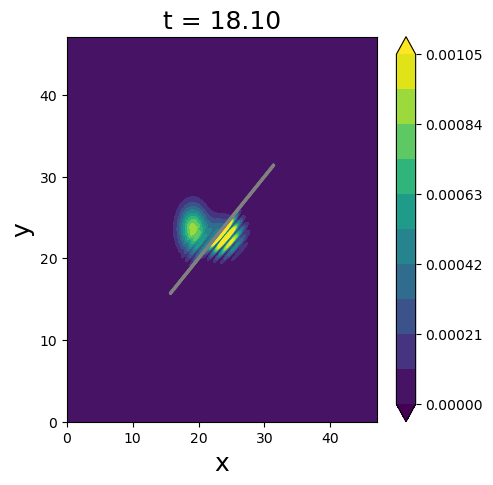

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98117 0.01435 0.00445 8e-05
sum |c|^2= 1.00005
E_F, E_A, E_I, econst = 9.75104 9e-05 0.15987 -86.784
Total energy =  -76.87301
Total energy - econst =  9.91099


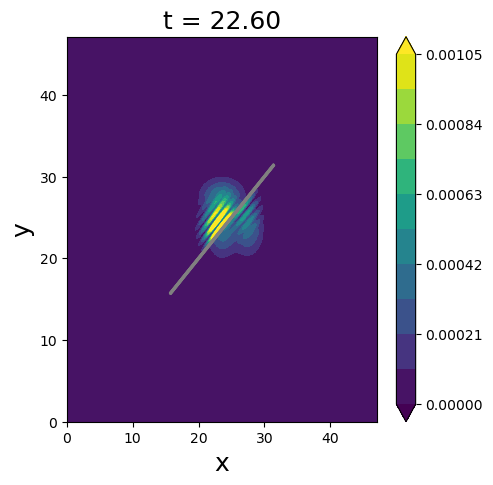

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99613 0.00373 0.00014 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.9689 0.0 0.03253 -86.784
Total energy =  -76.78257
Total energy - econst =  10.00143


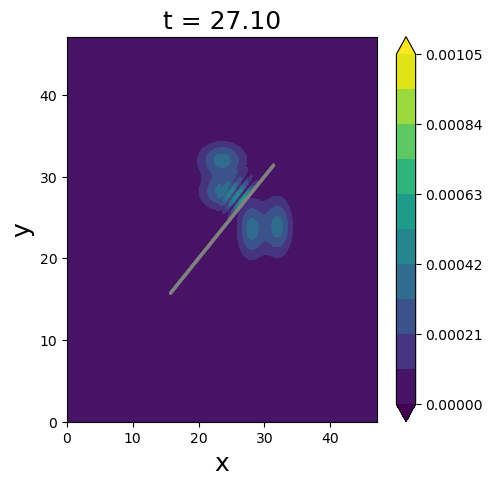

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99986 0.00014 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02307 0.0 0.00113 -86.784
Total energy =  -76.7598
Total energy - econst =  10.0242


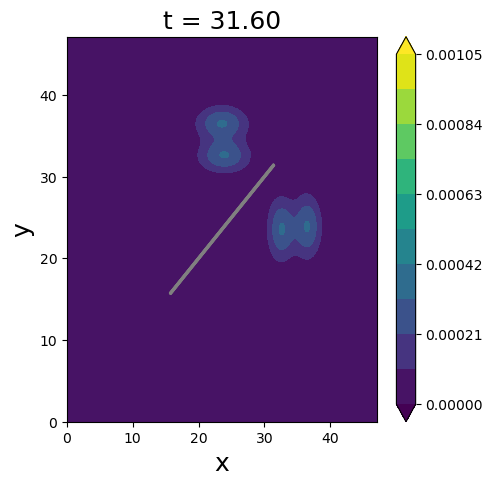

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


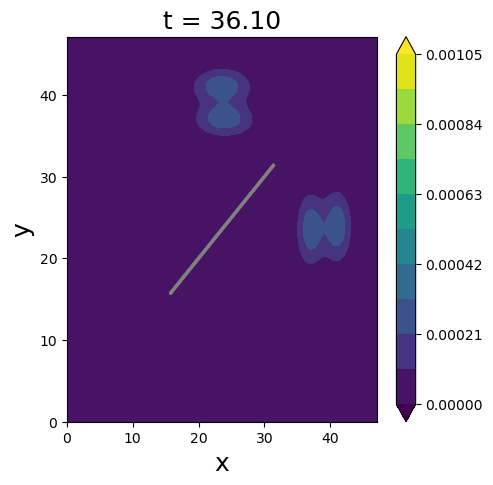

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


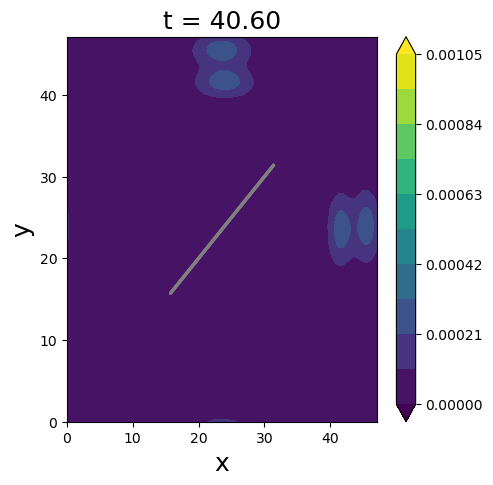

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


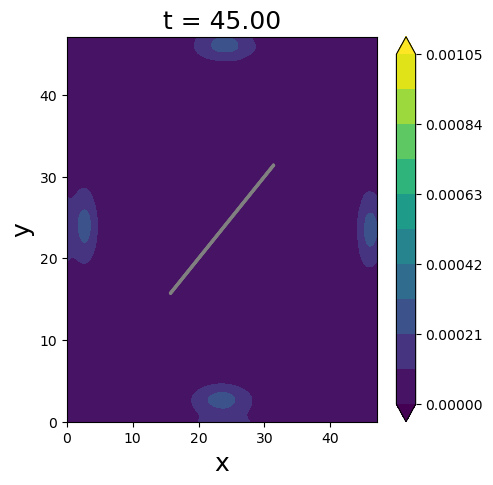

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


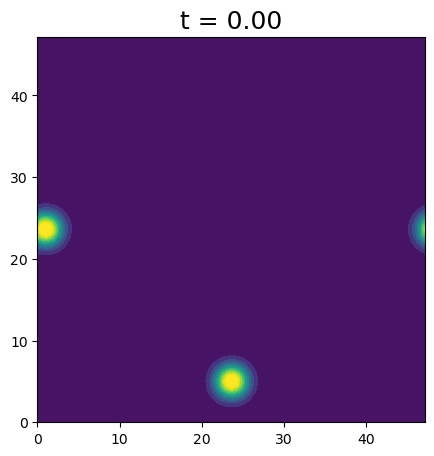

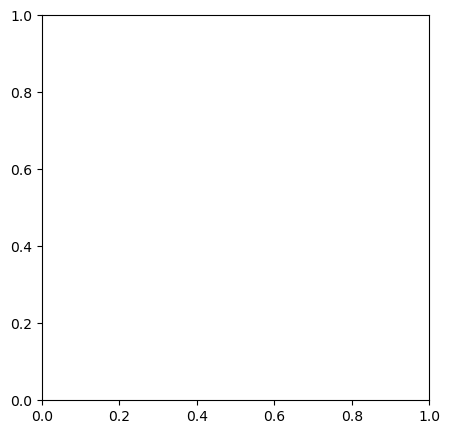

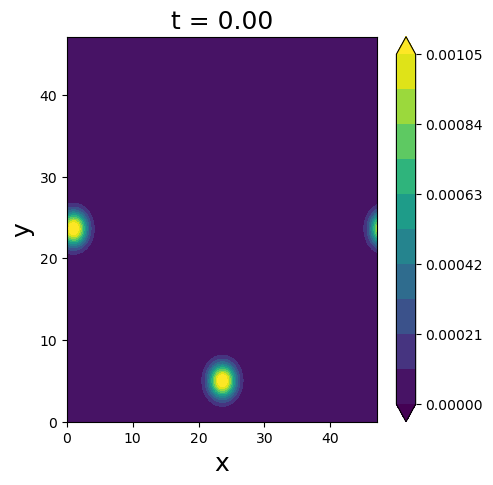

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


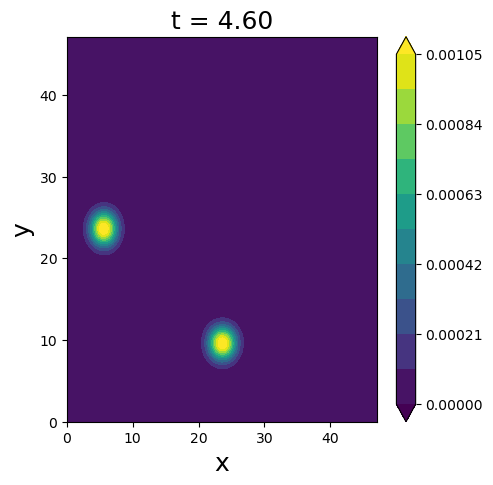

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


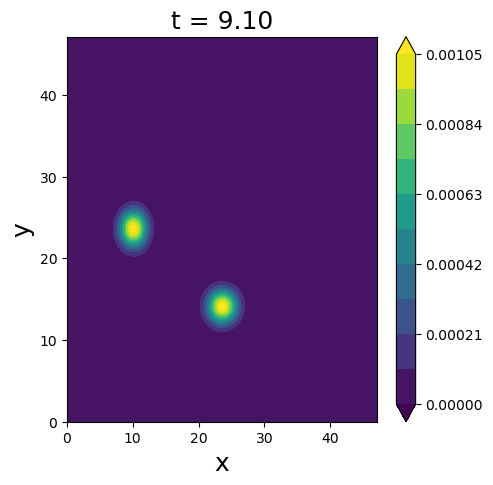

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


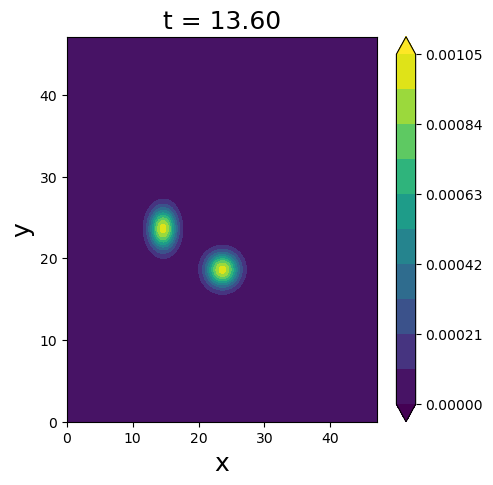

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


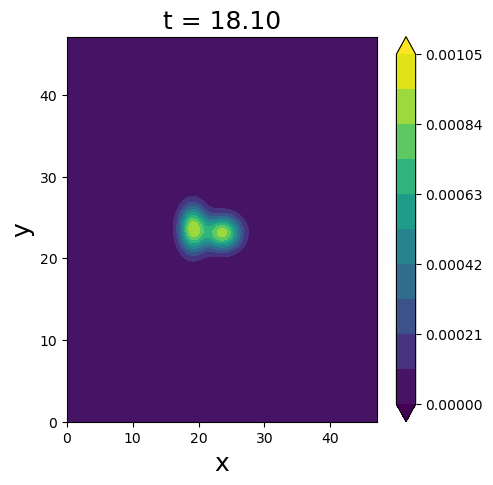

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


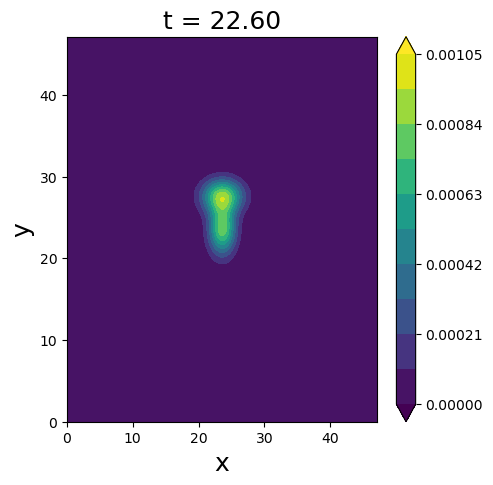

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


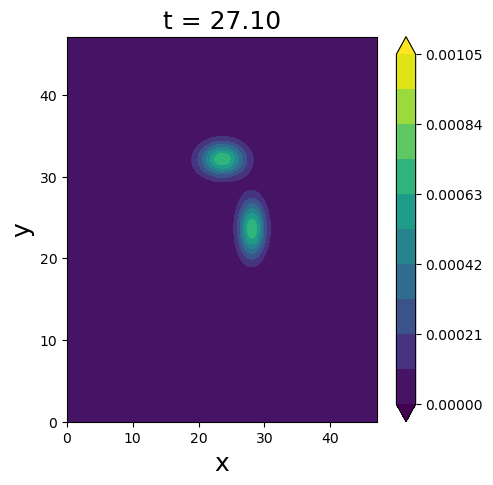

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


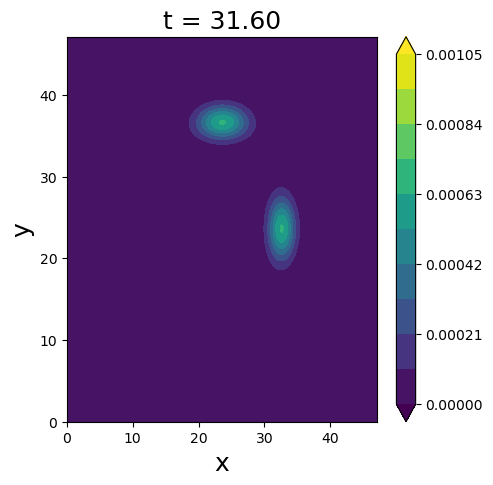

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


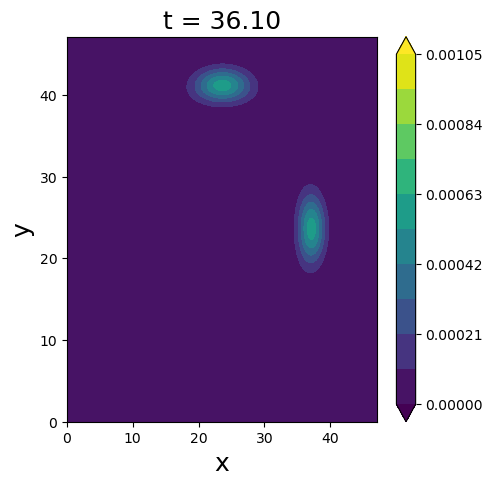

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


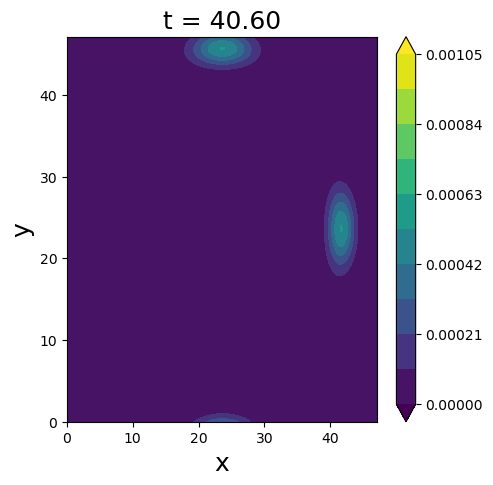

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


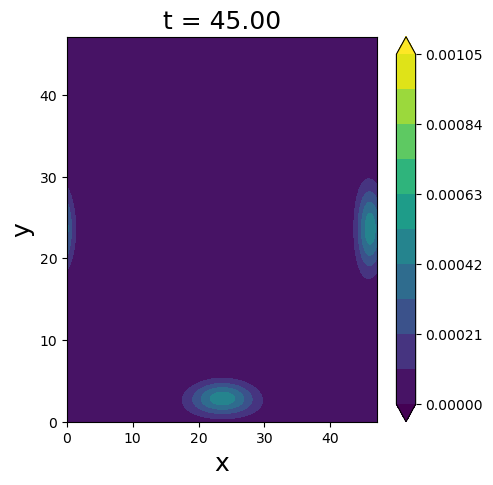

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


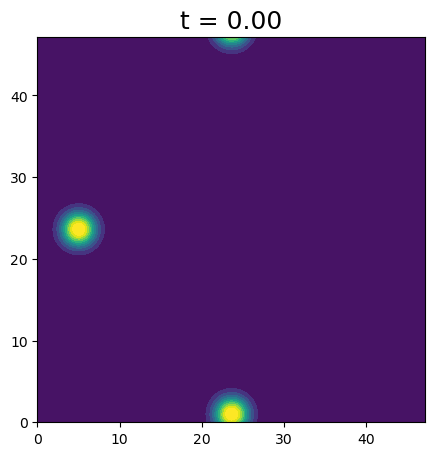

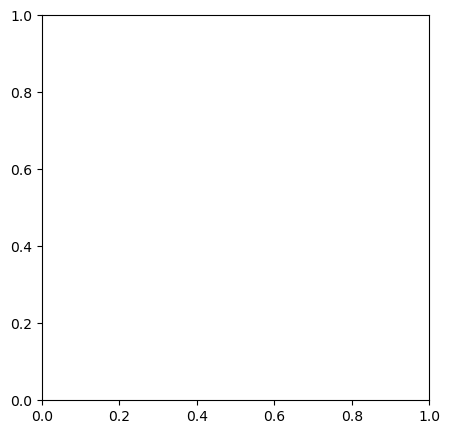

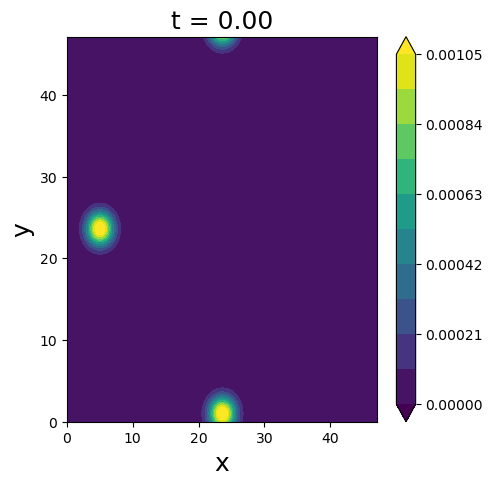

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


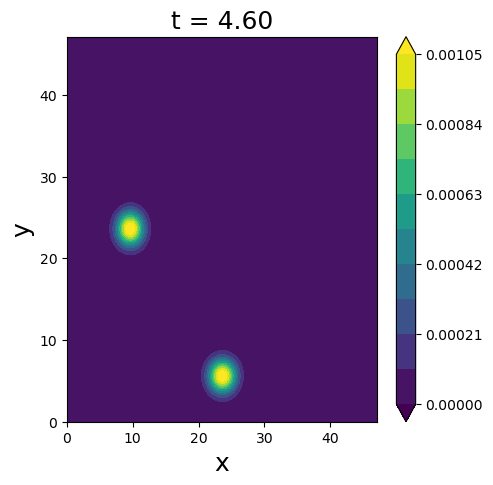

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


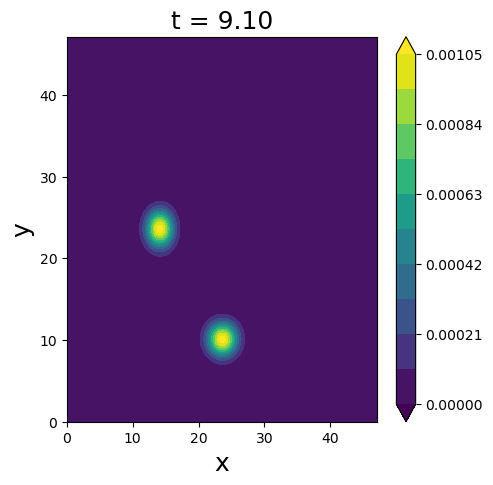

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


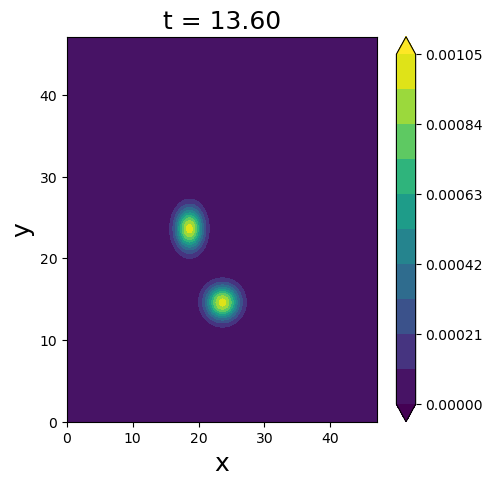

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


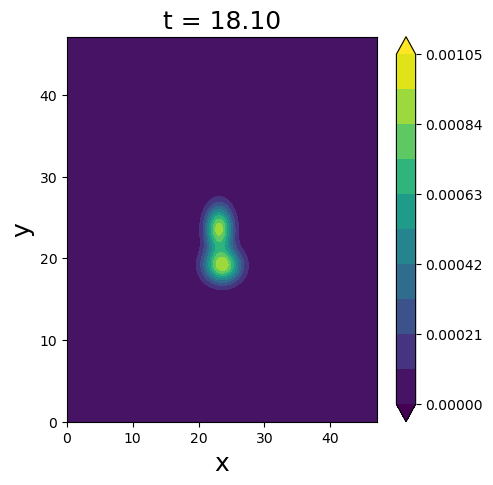

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


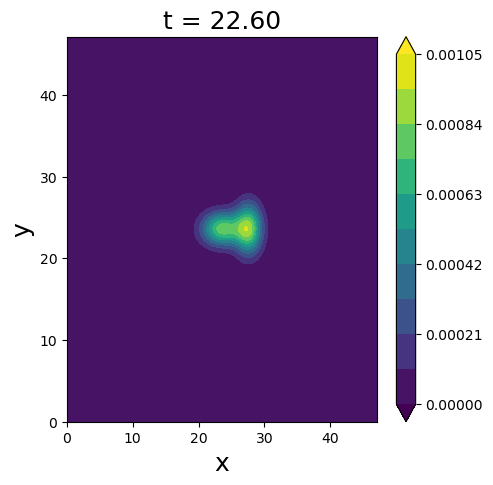

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


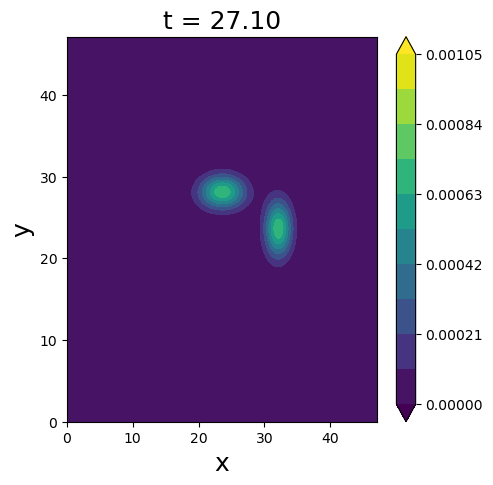

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


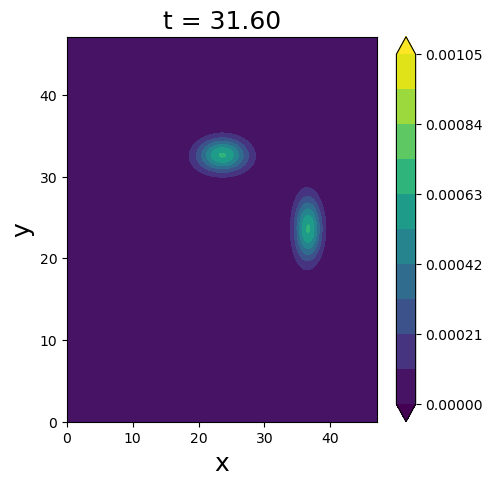

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


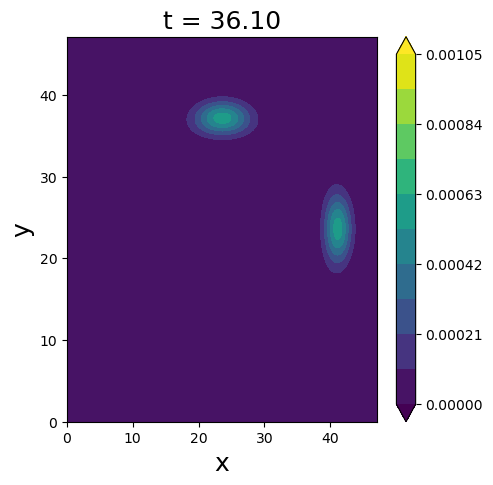

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


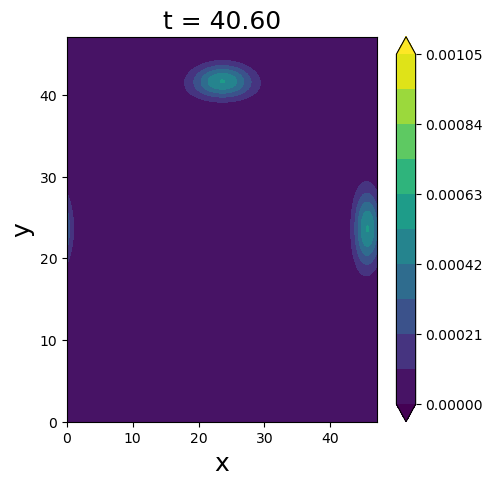

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


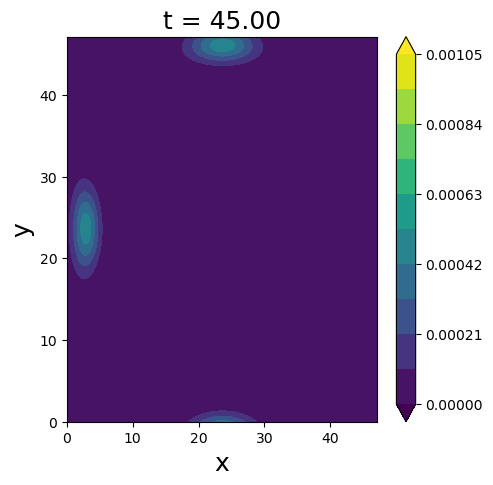

coincidence probability = 0.5623
deltax= -3.0
#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


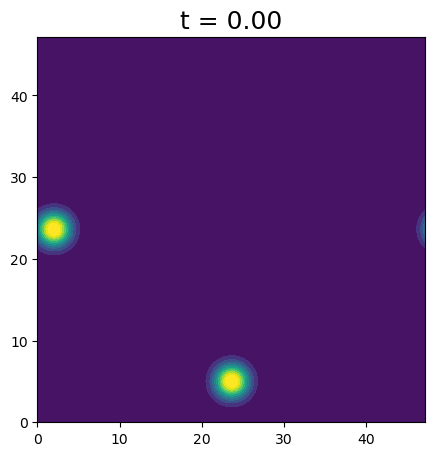

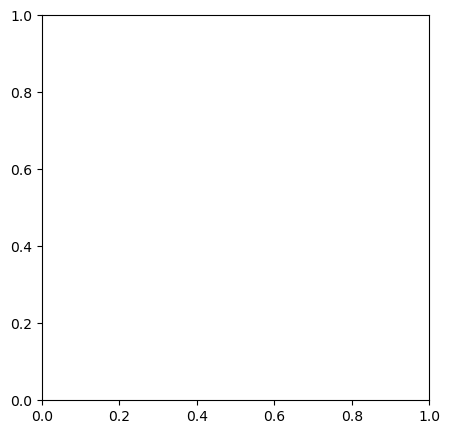

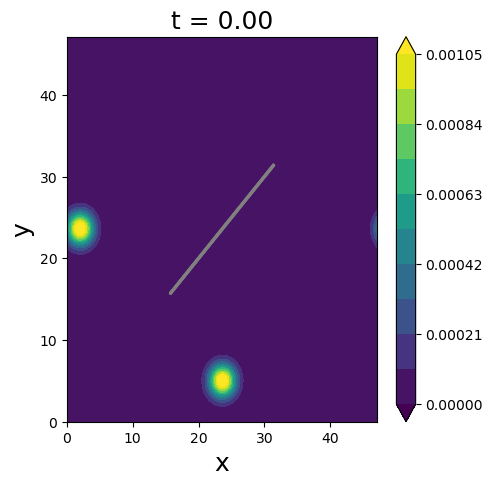

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


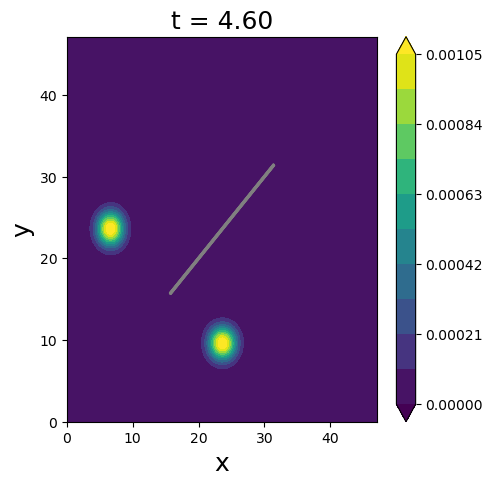

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02502 0.0 1e-05 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


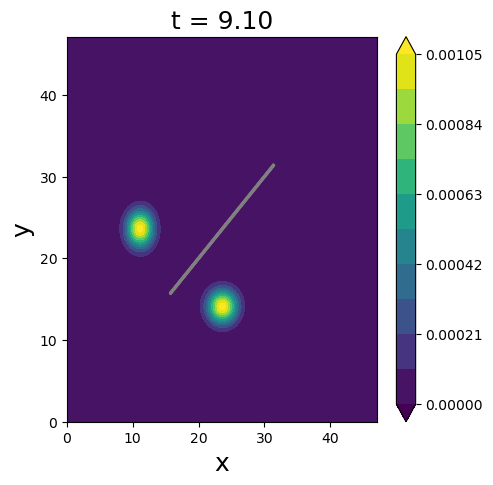

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99872 3e-05 0.00125 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.00653 0.0 0.0107 -86.784
Total energy =  -76.76676
Total energy - econst =  10.01724


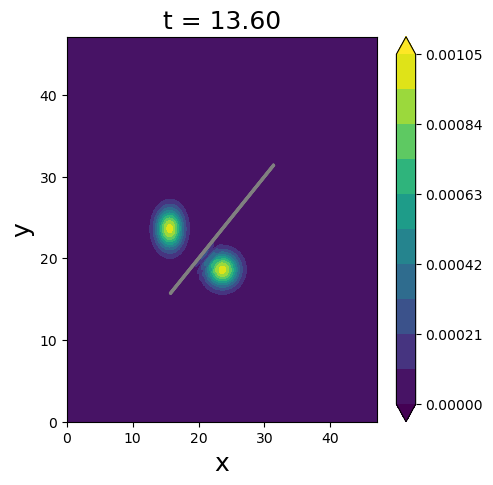

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98006 0.00496 0.01497 0.00011
sum |c|^2= 1.0001
E_F, E_A, E_I, econst = 9.73468 0.0001 0.16949 -86.784
Total energy =  -76.87973
Total energy - econst =  9.90427


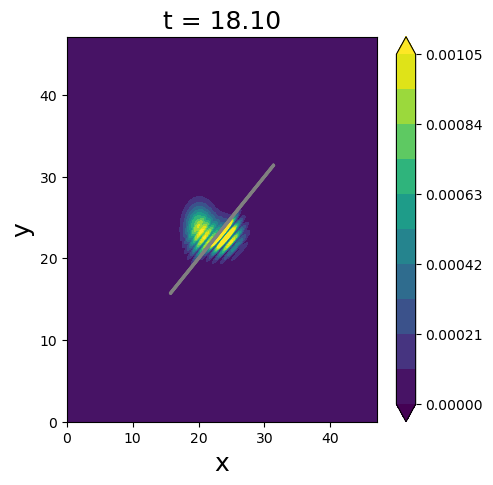

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.9821 0.01344 0.00446 9e-05
sum |c|^2= 1.00008
E_F, E_A, E_I, econst = 9.76436 8e-05 0.15206 -86.784
Total energy =  -76.8675
Total energy - econst =  9.9165


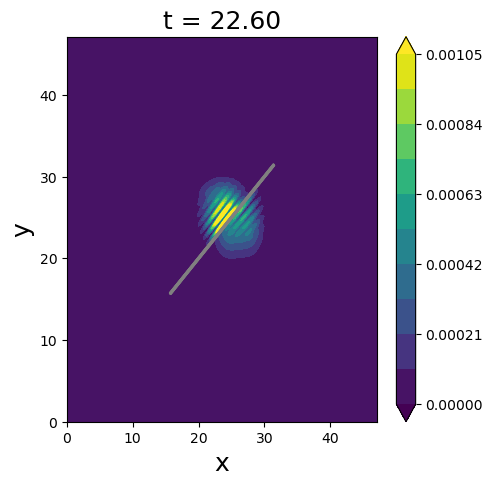

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99787 0.002 0.00014 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.99411 0.0 0.01789 -86.784
Total energy =  -76.77199
Total energy - econst =  10.01201


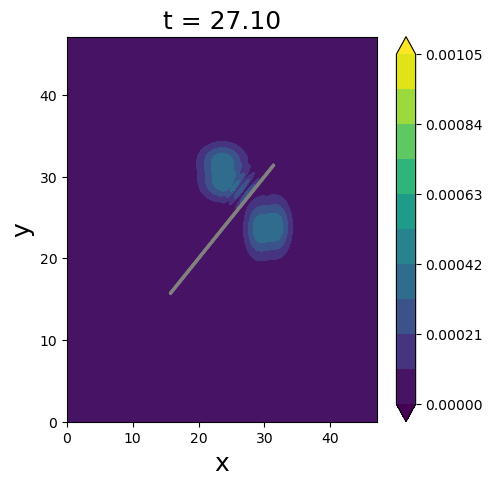

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99996 4e-05 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.0245 0.0 0.00031 -86.784
Total energy =  -76.7592
Total energy - econst =  10.0248


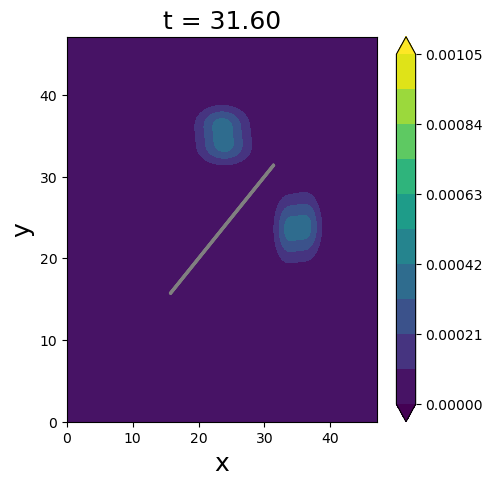

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


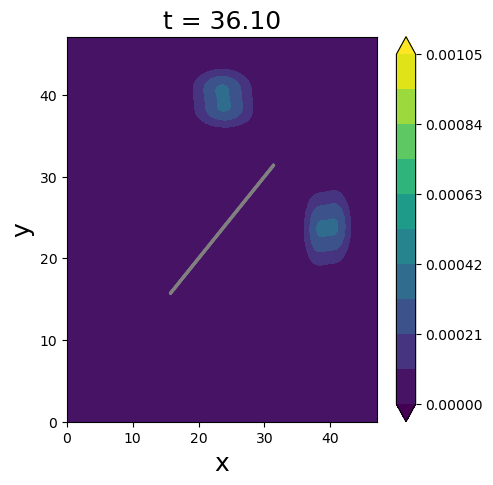

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


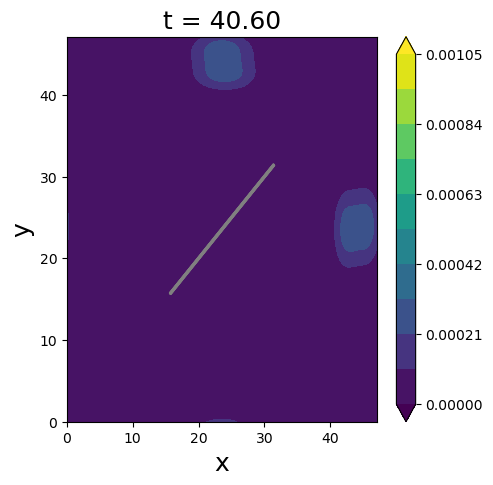

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


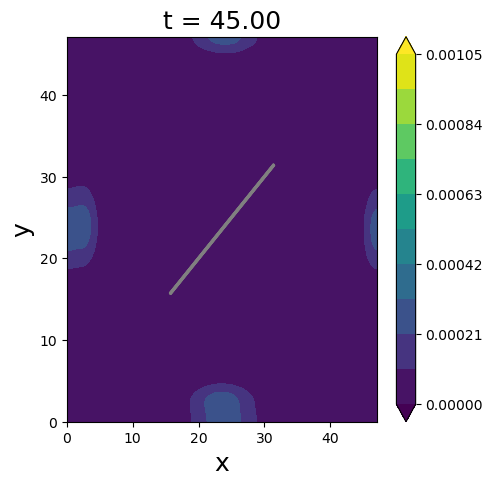

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


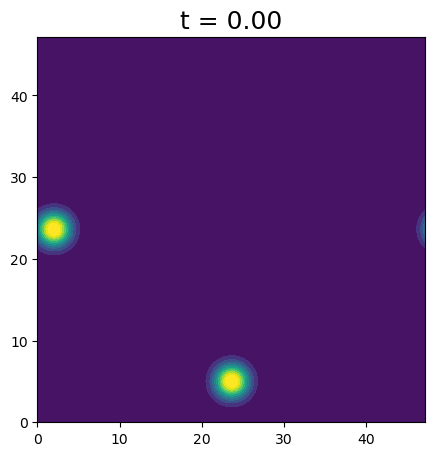

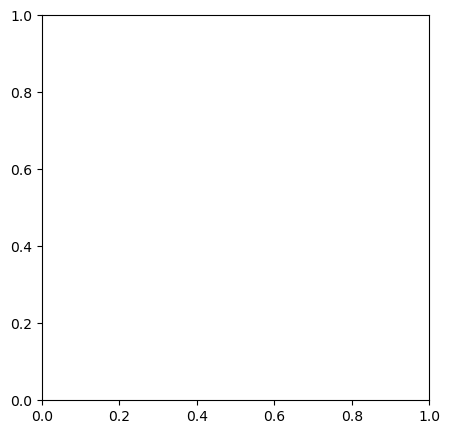

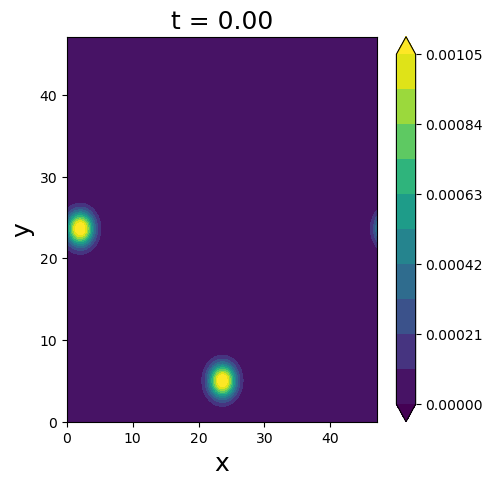

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


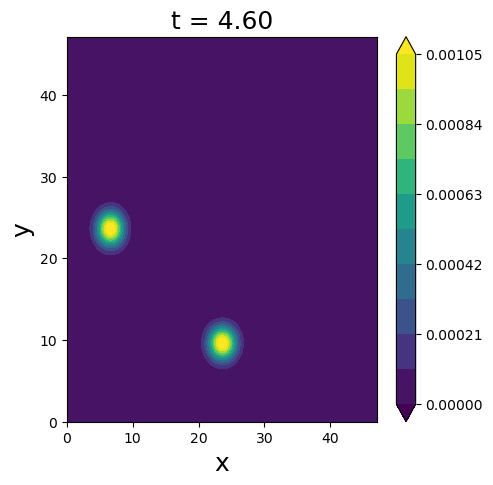

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


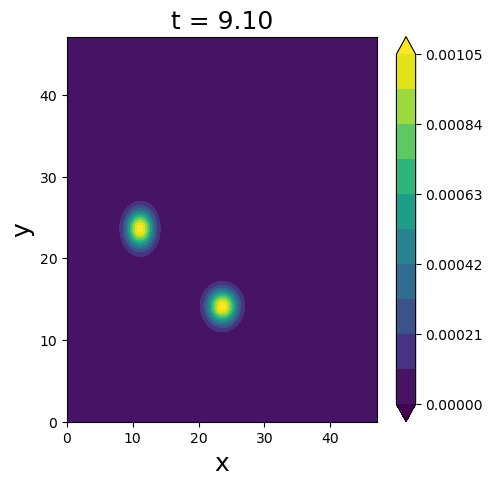

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


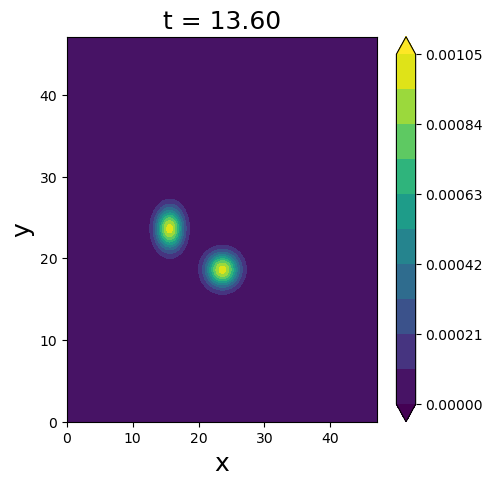

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


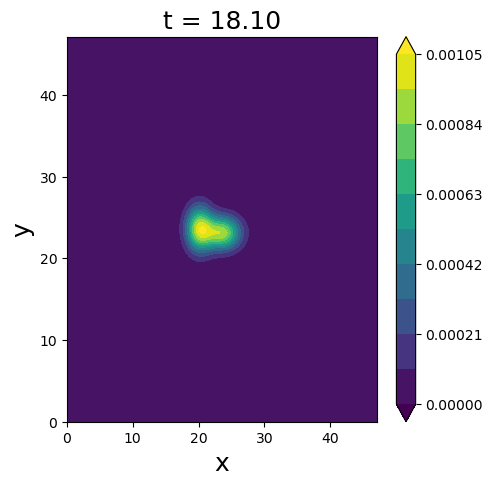

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


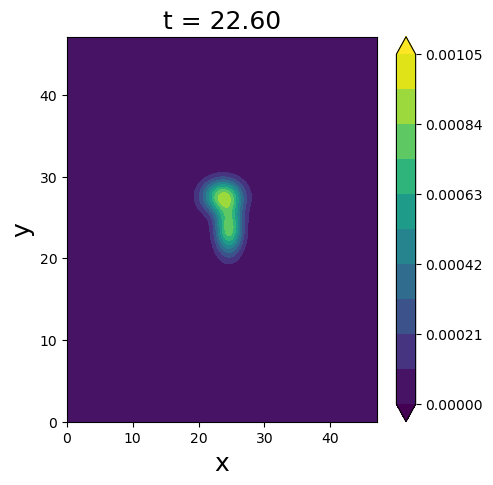

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


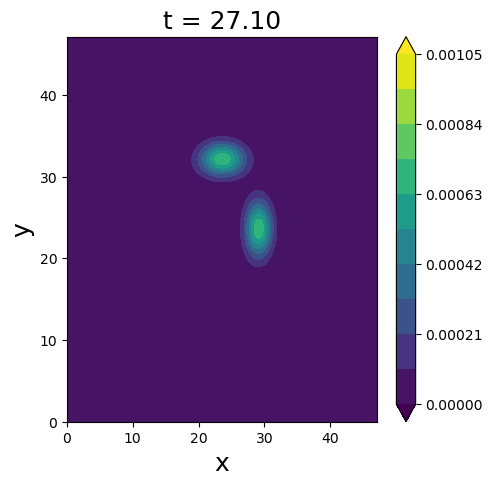

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


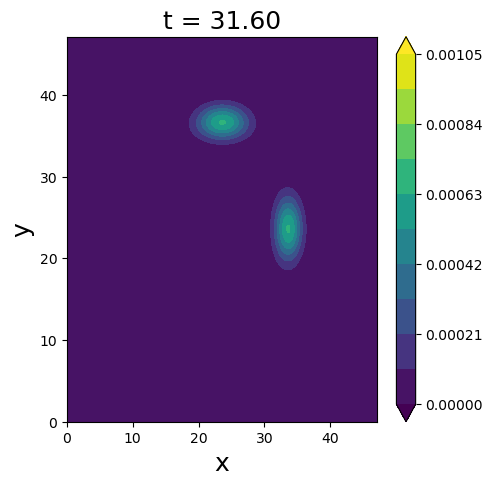

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


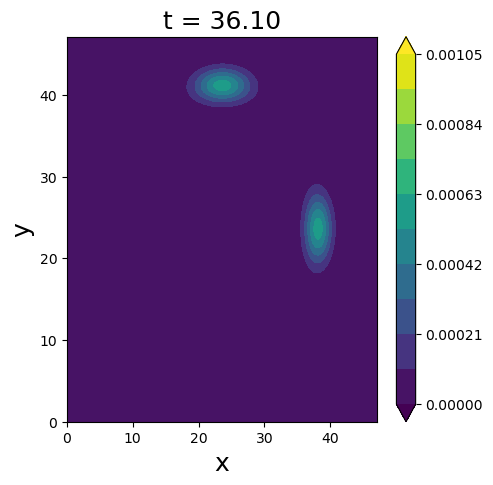

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


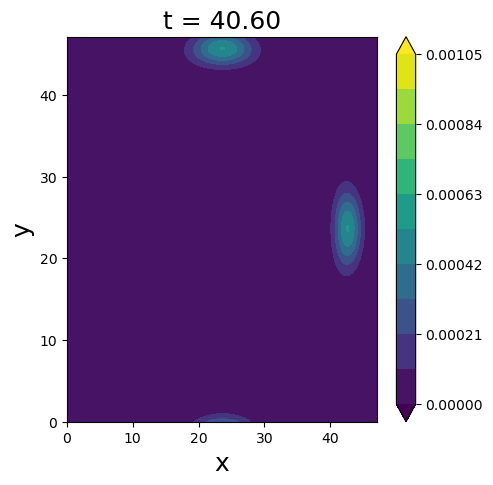

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


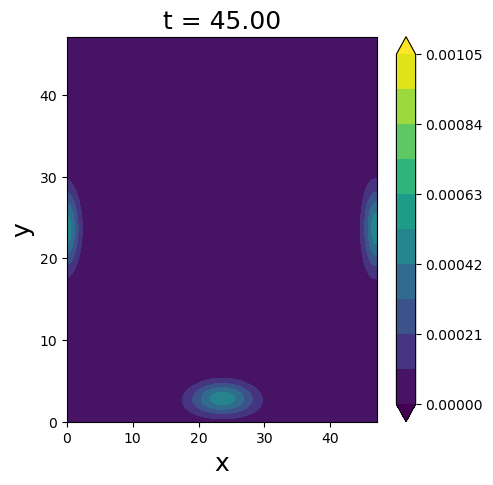

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


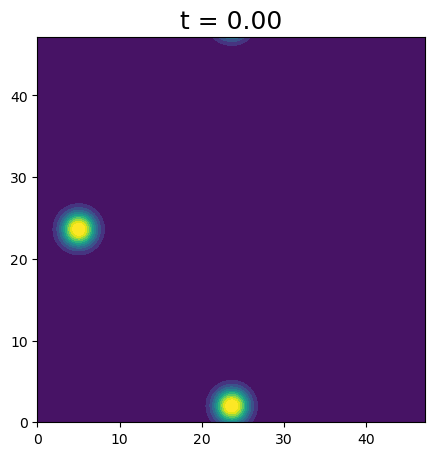

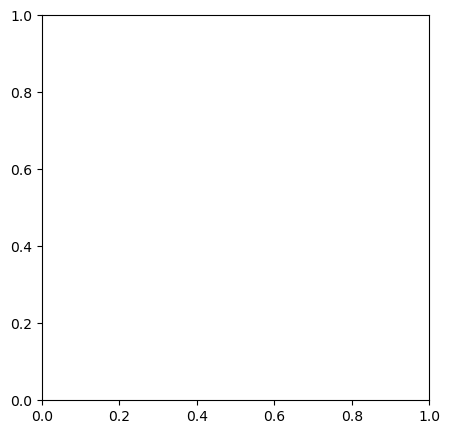

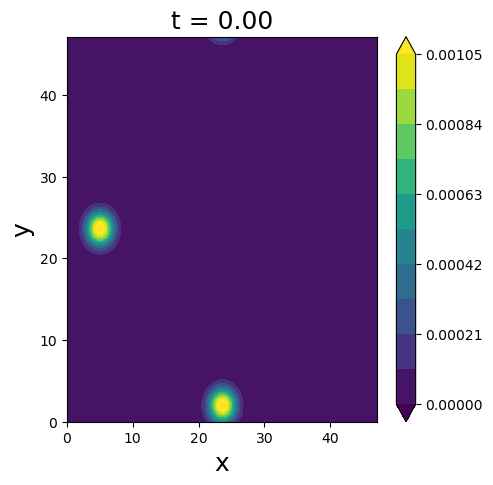

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


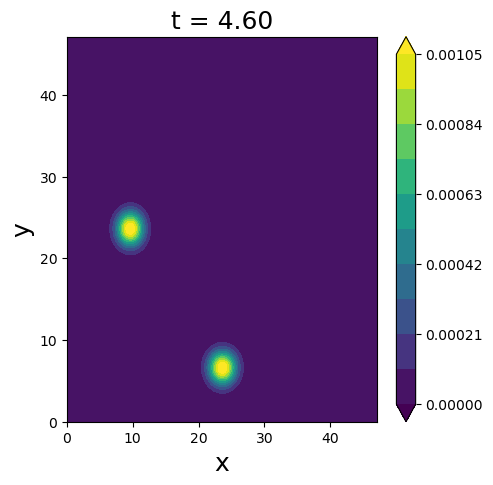

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


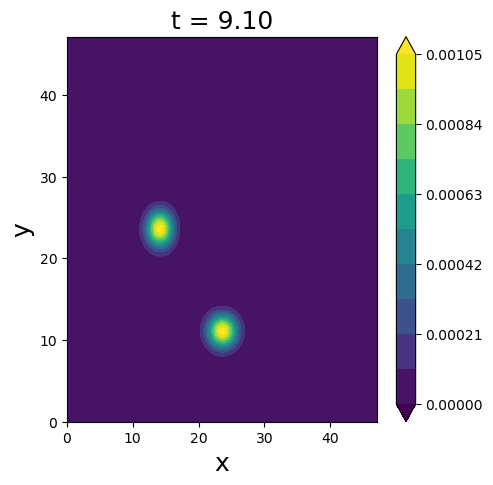

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


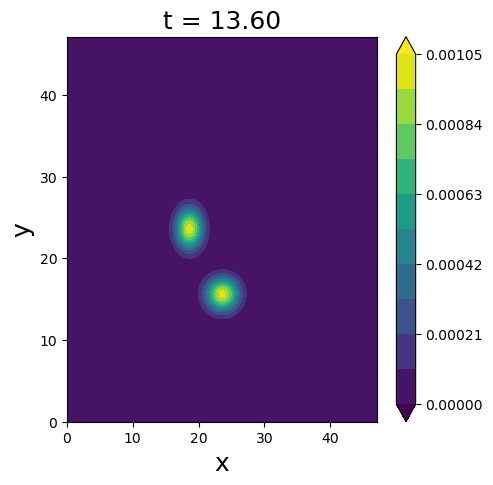

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


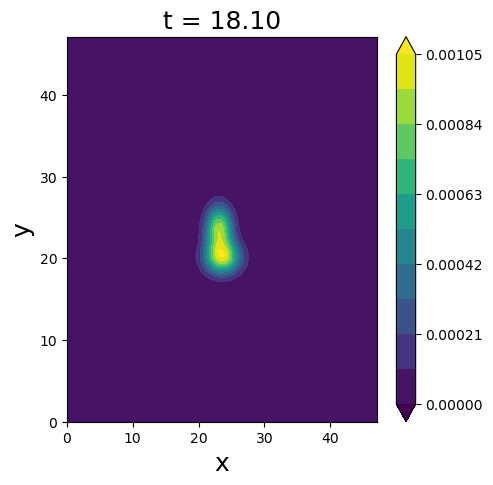

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


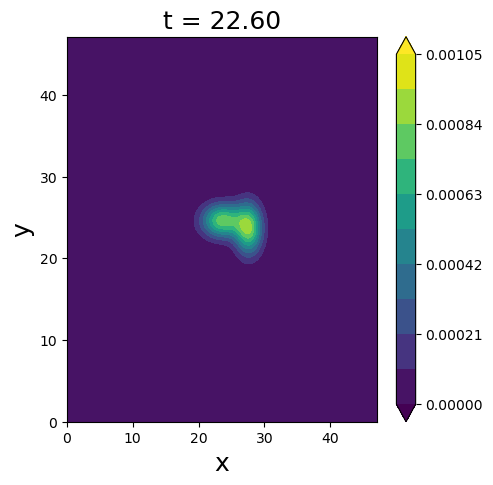

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


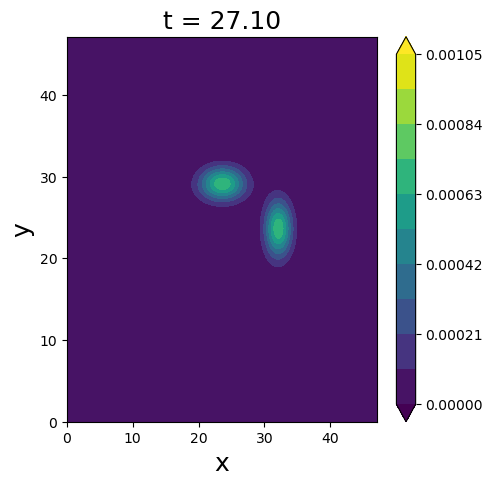

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


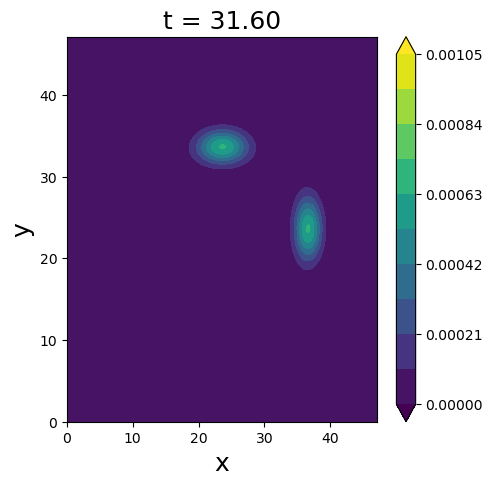

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


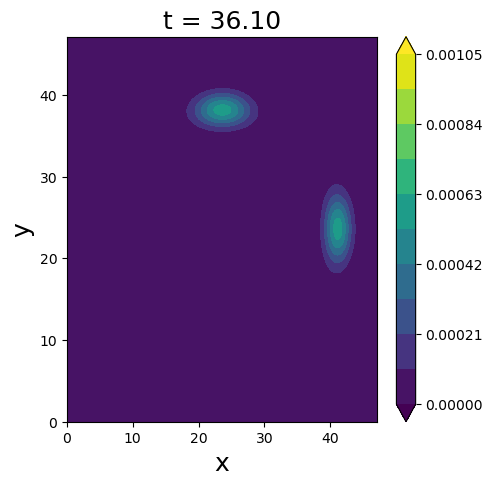

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


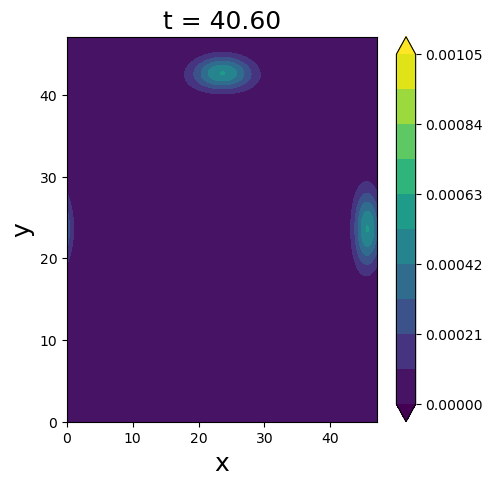

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


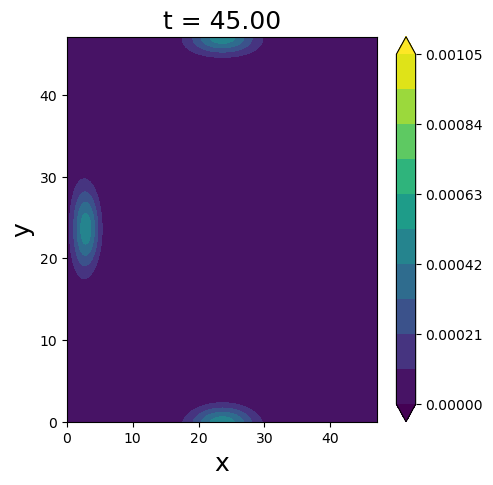

coincidence probability = 0.6563
deltax= -2.0
#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


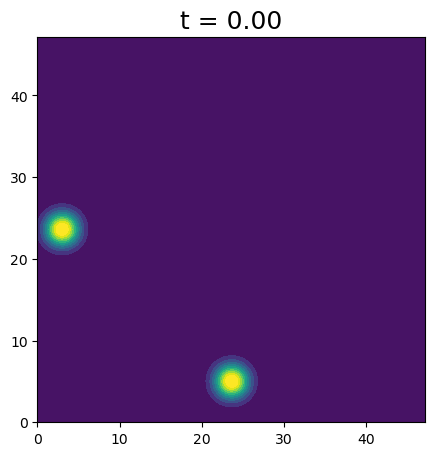

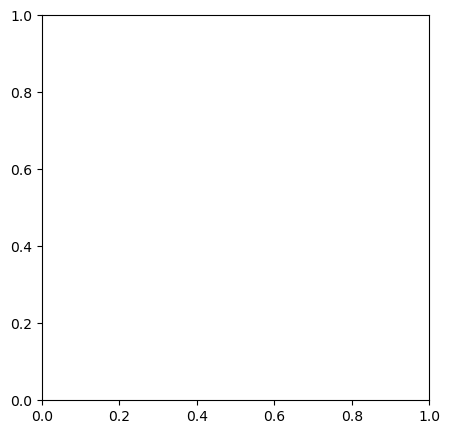

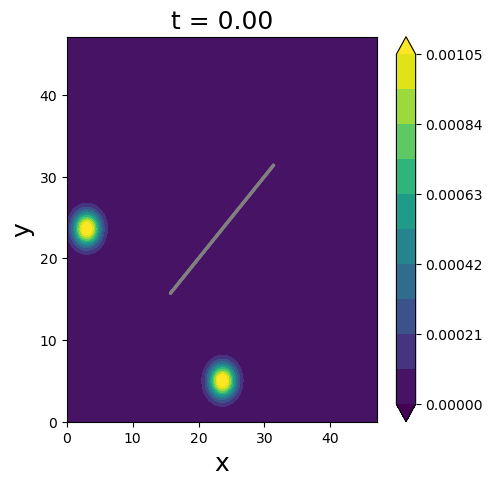

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


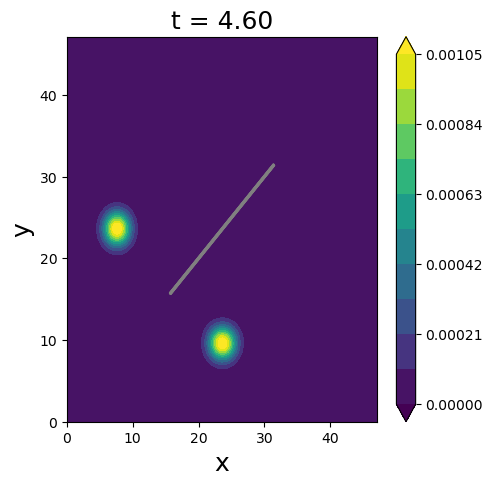

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02502 0.0 1e-05 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


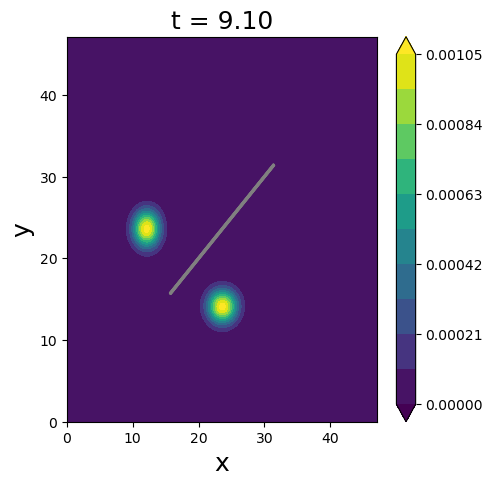

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99863 0.00011 0.00125 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.00526 0.0 0.01144 -86.784
Total energy =  -76.7673
Total energy - econst =  10.0167


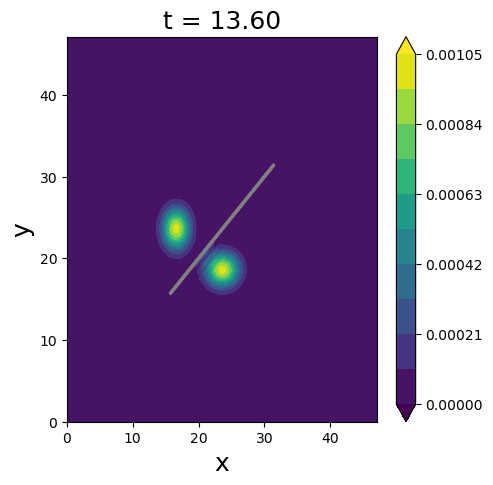

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.97658 0.00852 0.01494 0.00022
sum |c|^2= 1.00026
E_F, E_A, E_I, econst = 9.68339 0.00018 0.1999 -86.784
Total energy =  -76.90053
Total energy - econst =  9.88347


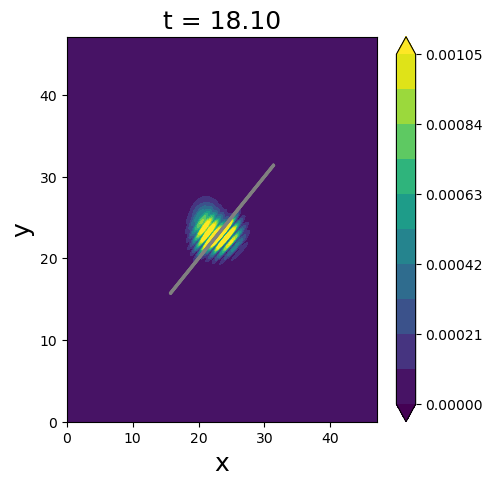

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98471 0.01083 0.00447 8e-05
sum |c|^2= 1.0001
E_F, E_A, E_I, econst = 9.80238 7e-05 0.12979 -86.784
Total energy =  -76.85176
Total energy - econst =  9.93224


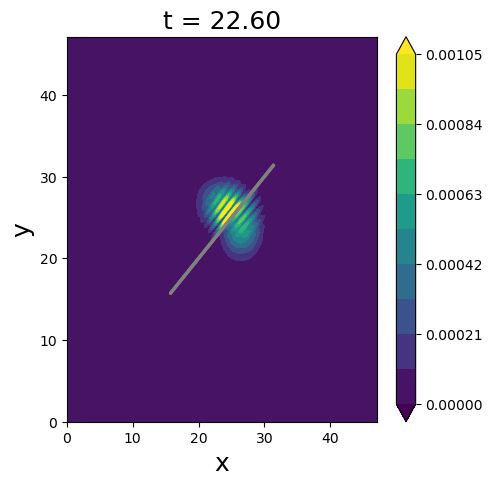

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99892 0.00094 0.00014 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.00938 0.0 0.00904 -86.784
Total energy =  -76.76558
Total energy - econst =  10.01842


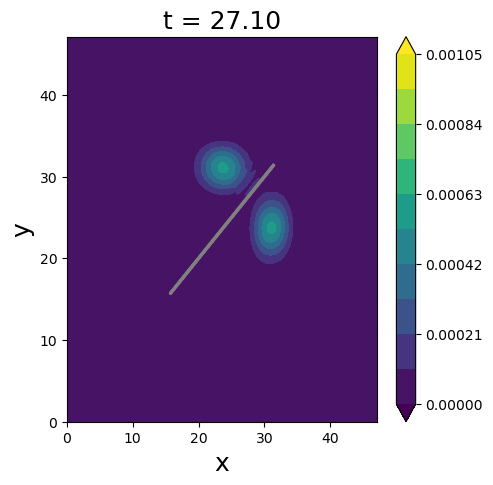

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99999 1e-05 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02493 0.0 6e-05 -86.784
Total energy =  -76.75901
Total energy - econst =  10.02499


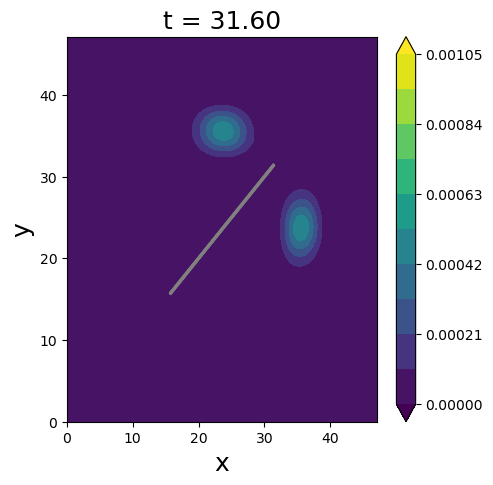

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


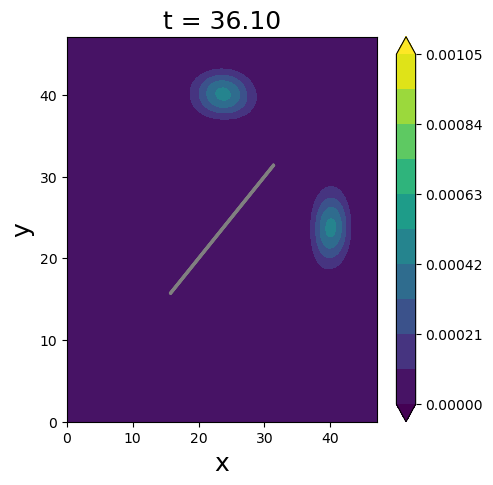

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


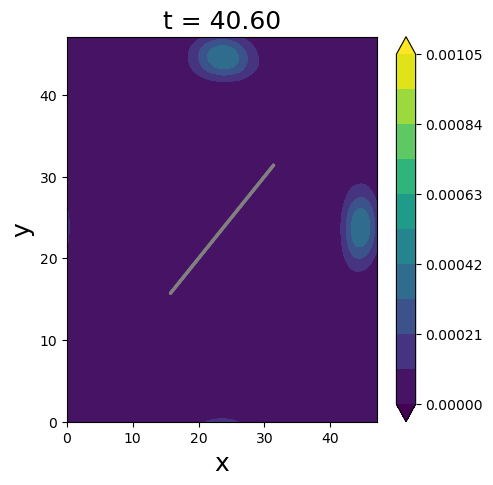

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


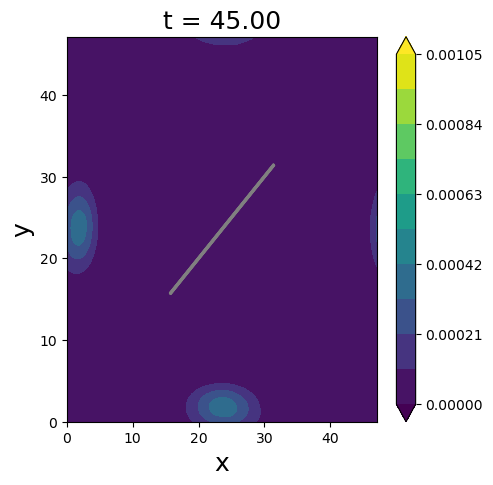

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


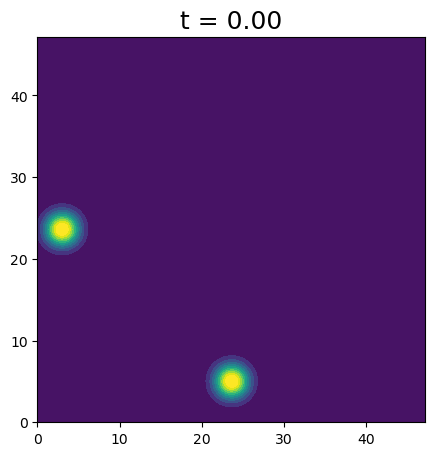

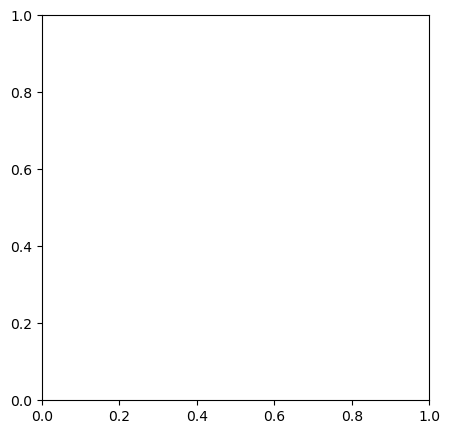

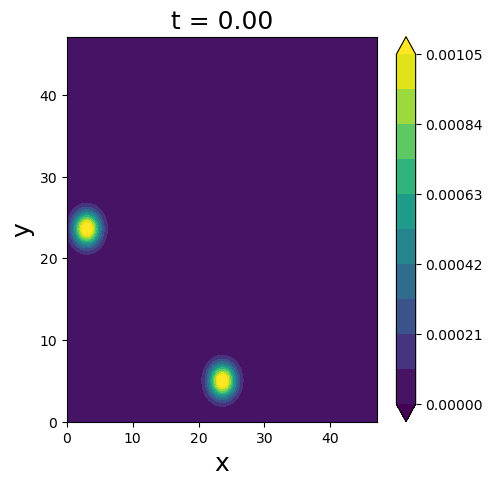

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


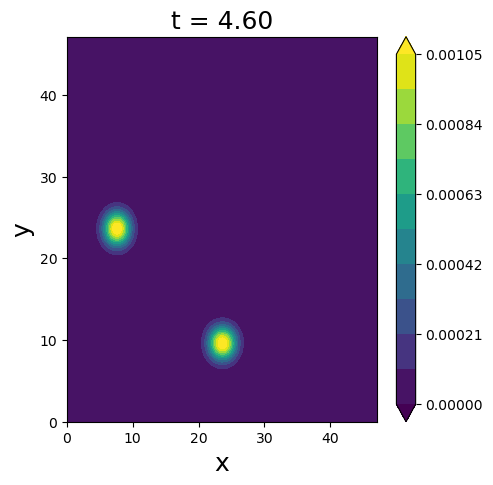

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


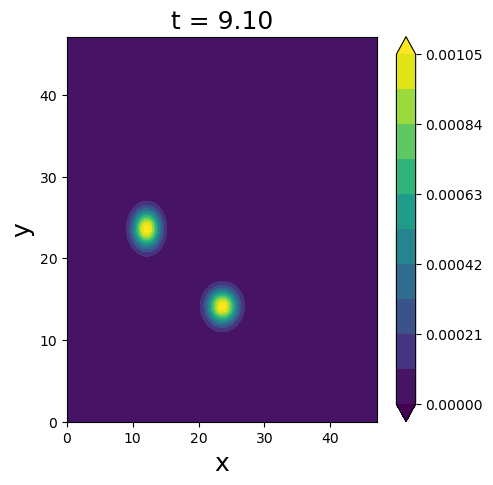

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


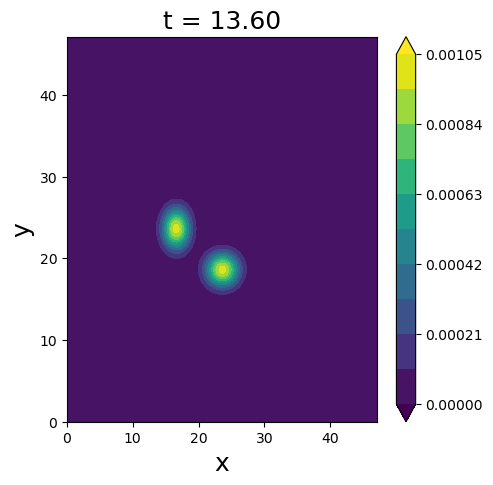

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


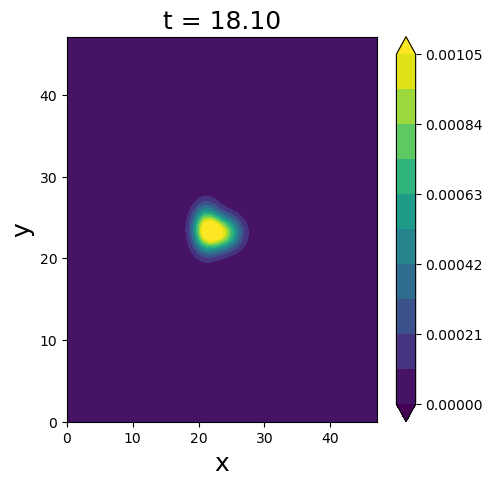

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


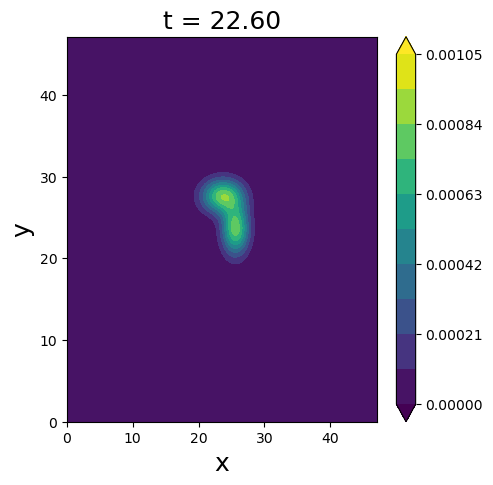

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


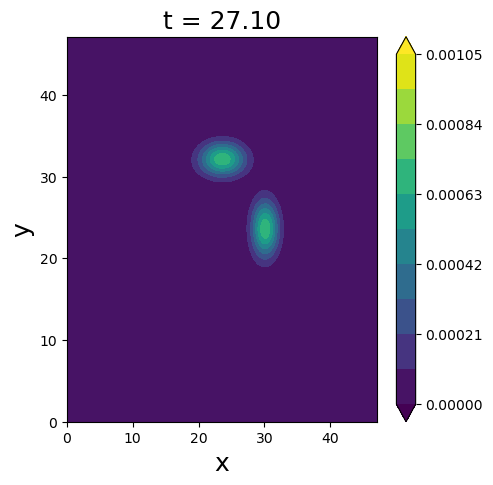

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


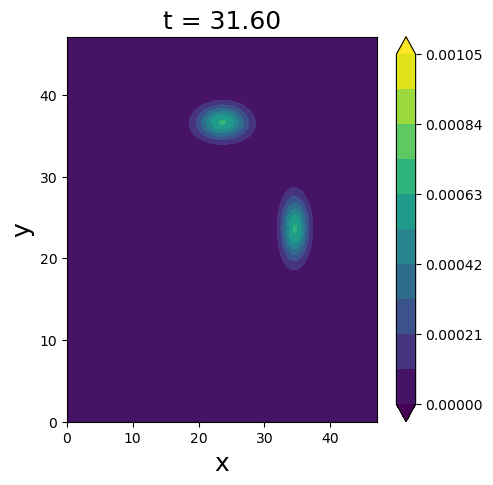

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


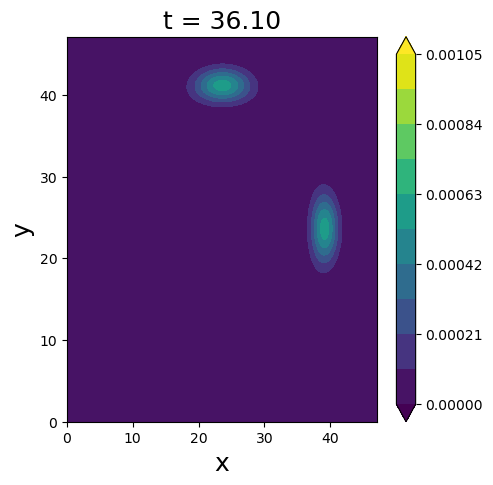

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


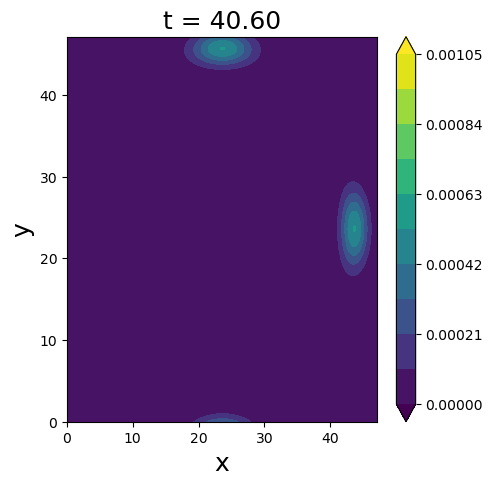

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


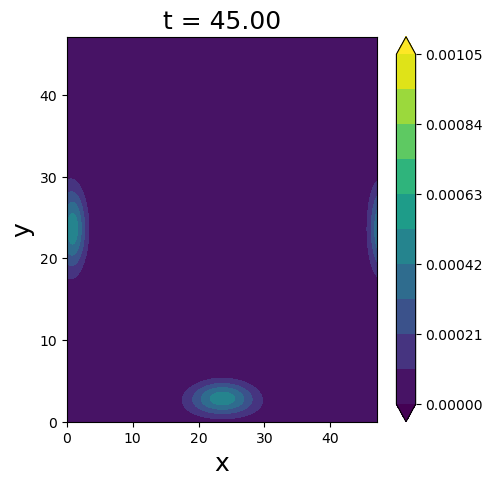

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


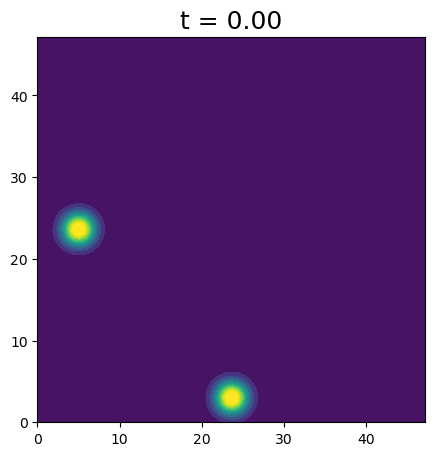

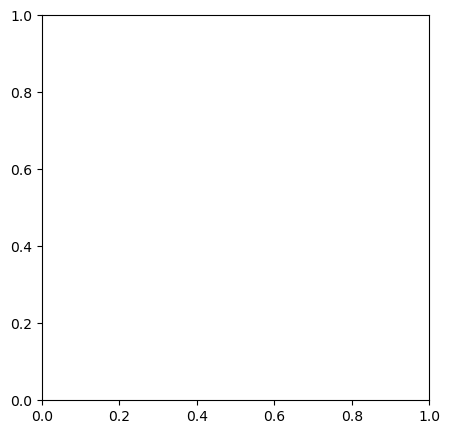

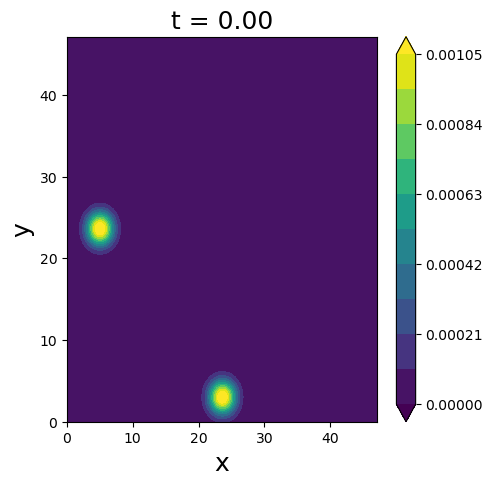

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


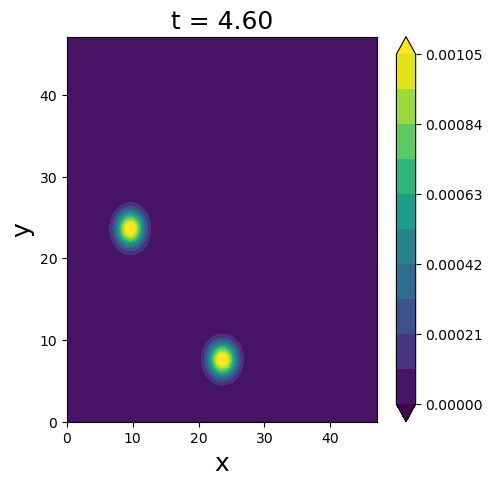

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


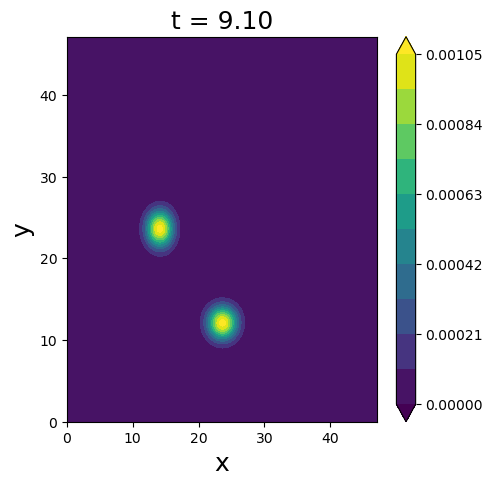

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


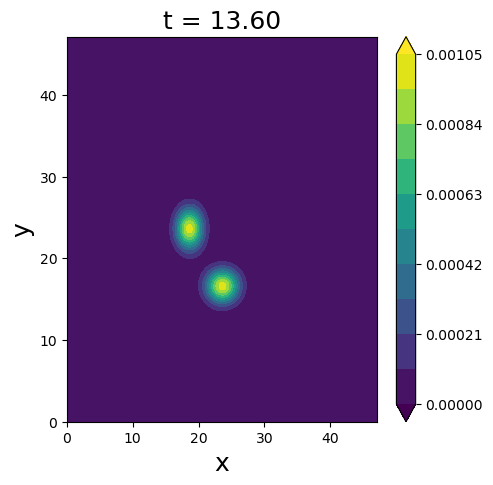

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


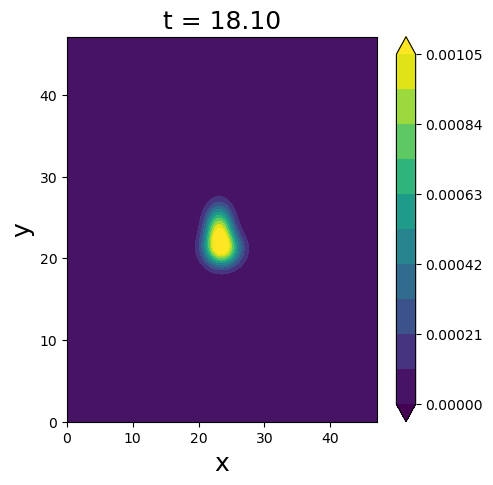

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


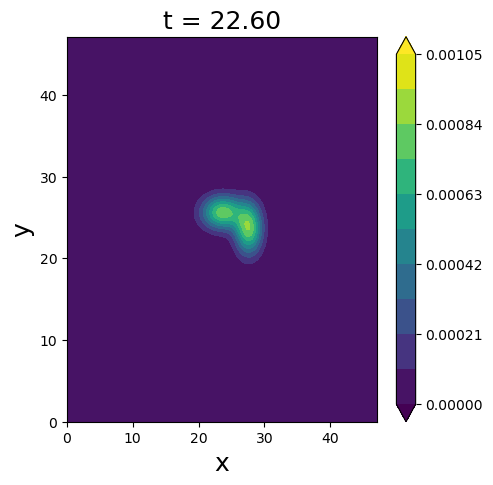

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


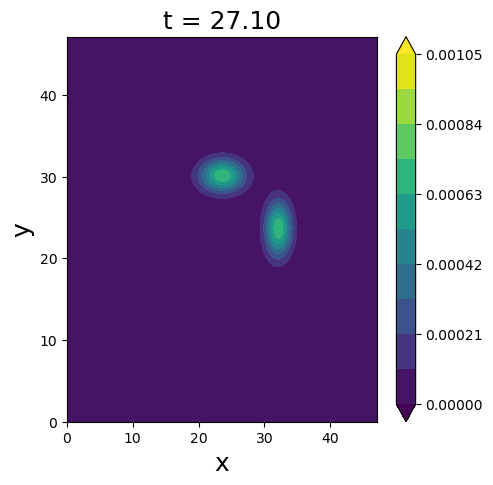

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


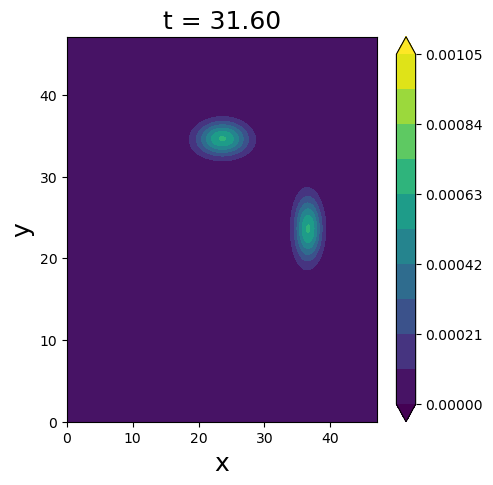

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


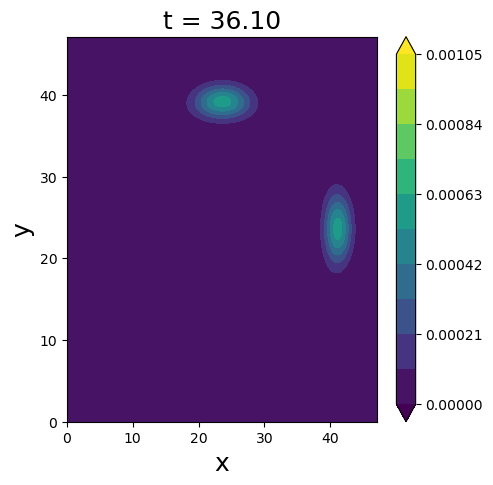

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


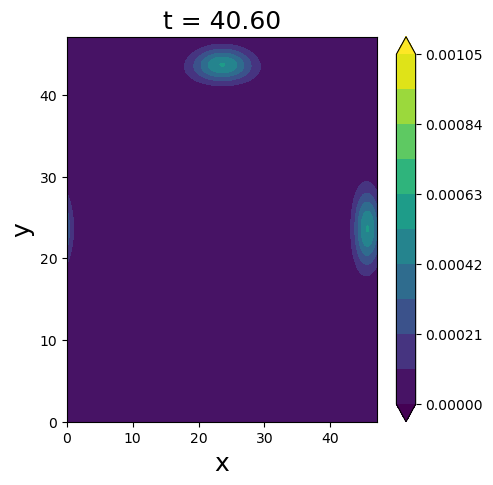

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


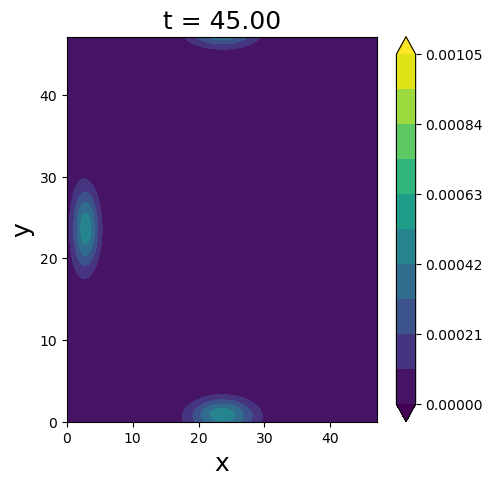

coincidence probability = 0.7961
deltax= -1.0
#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


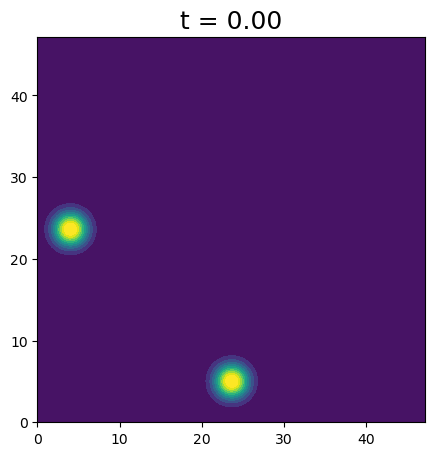

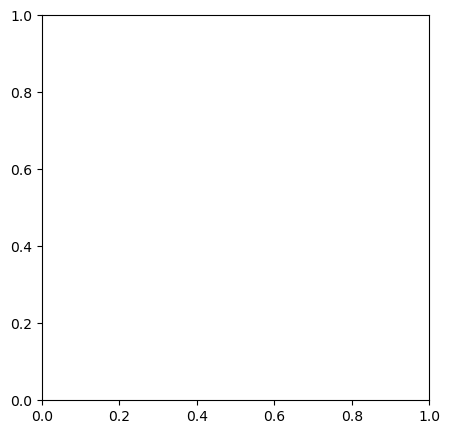

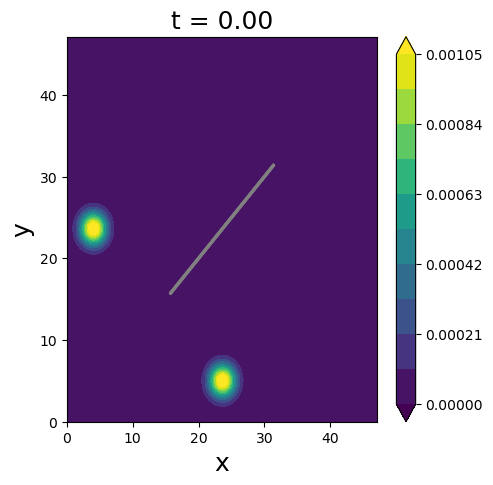

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


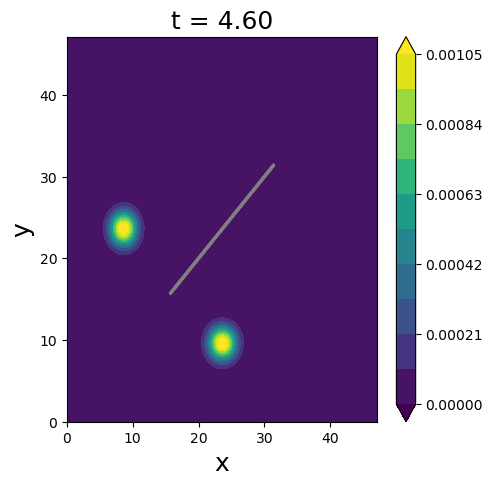

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02502 0.0 1e-05 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


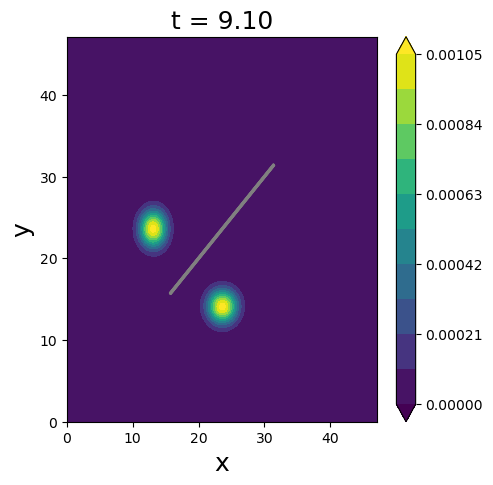

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99833 0.00042 0.00125 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.0009 0.0 0.01397 -86.784
Total energy =  -76.76914
Total energy - econst =  10.01486


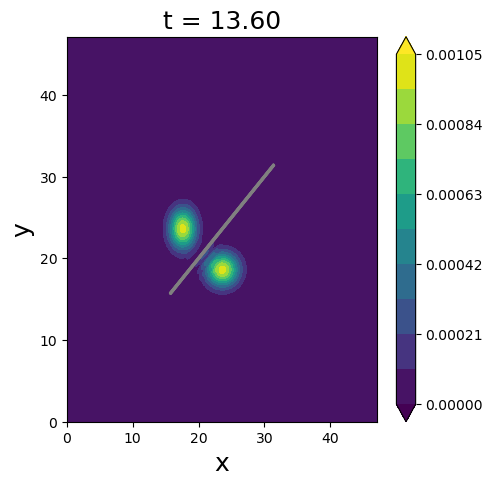

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.97291 0.0123 0.01491 0.00036
sum |c|^2= 1.00048
E_F, E_A, E_I, econst = 9.62906 0.00025 0.23215 -86.784
Total energy =  -76.92254
Total energy - econst =  9.86146


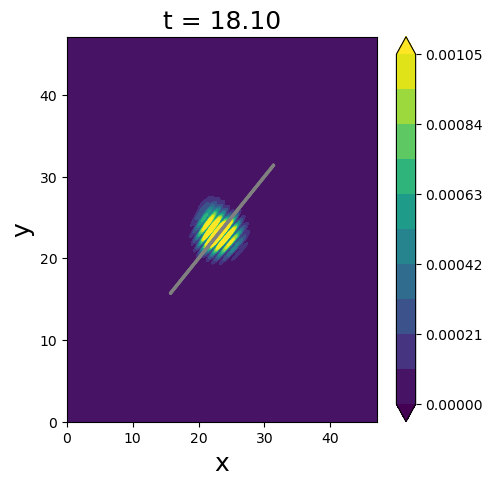

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.98802 0.00751 0.00449 7e-05
sum |c|^2= 1.00009
E_F, E_A, E_I, econst = 9.8506 5e-05 0.10157 -86.784
Total energy =  -76.83178
Total energy - econst =  9.95222


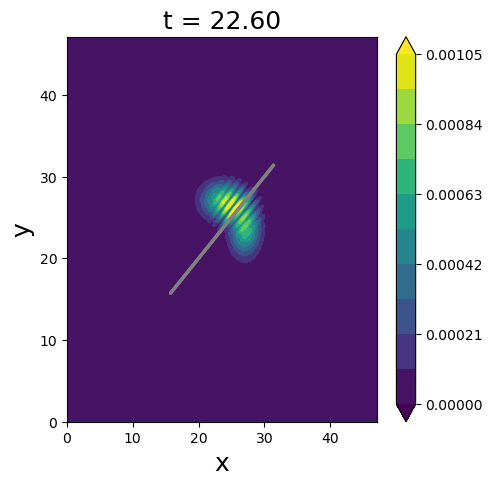

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99947 0.00039 0.00014 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.0174 0.0 0.0044 -86.784
Total energy =  -76.7622
Total energy - econst =  10.0218


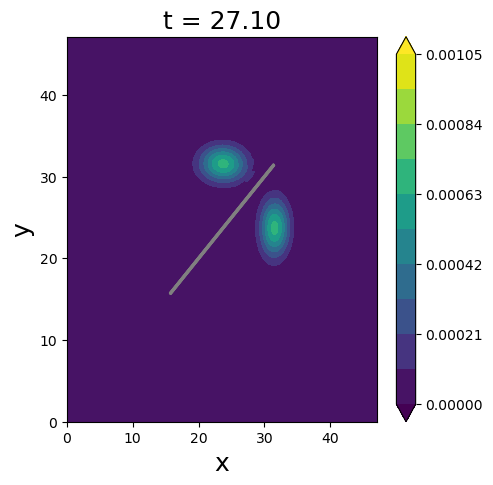

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02502 0.0 1e-05 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


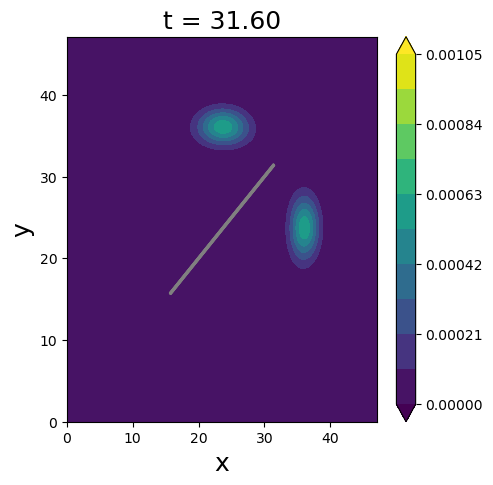

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


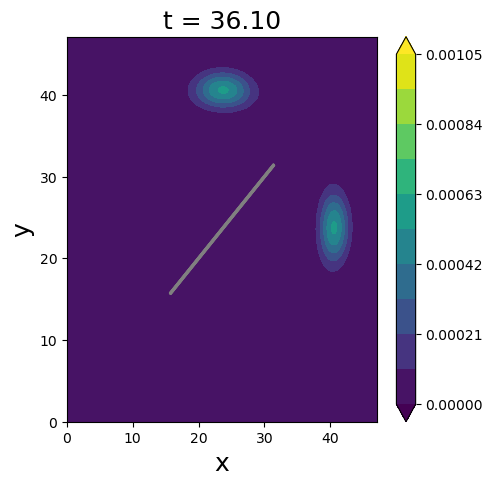

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


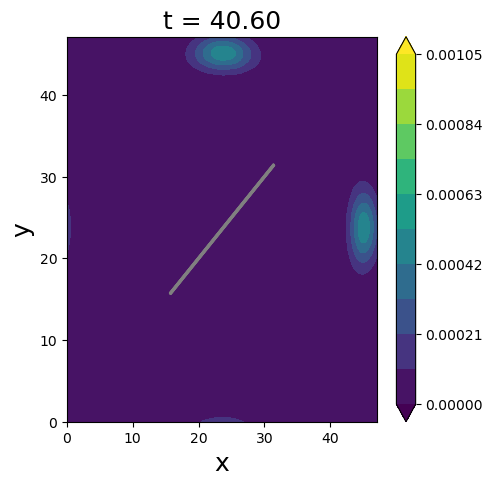

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


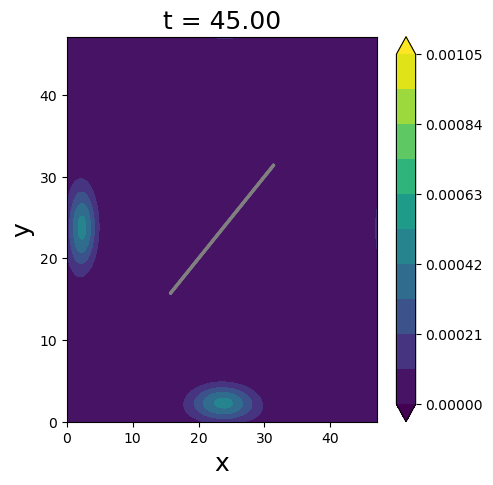

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


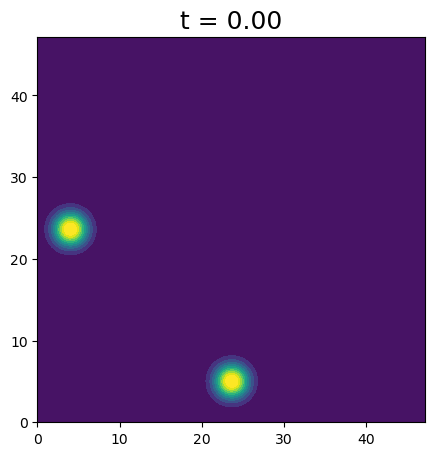

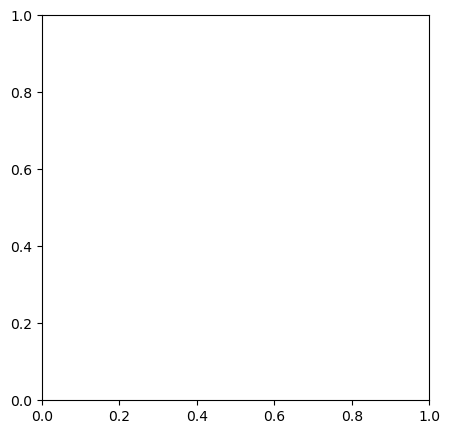

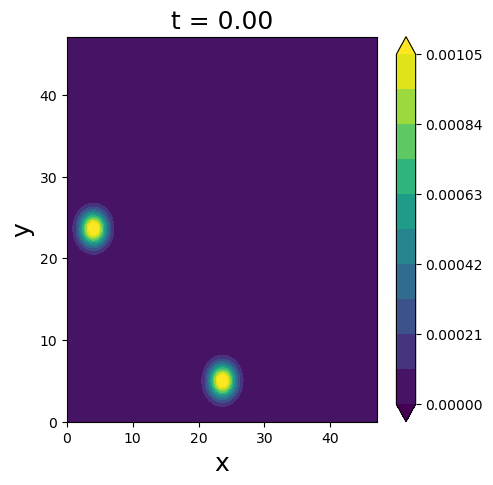

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


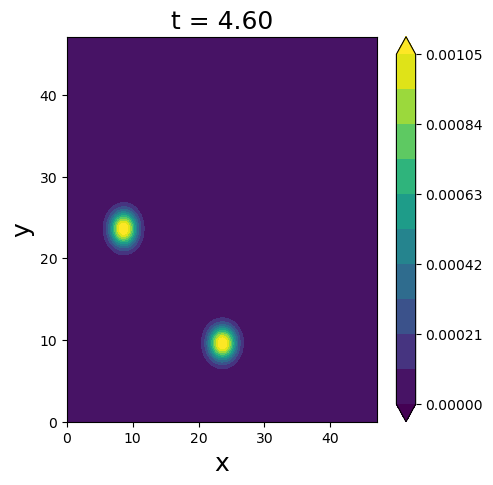

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


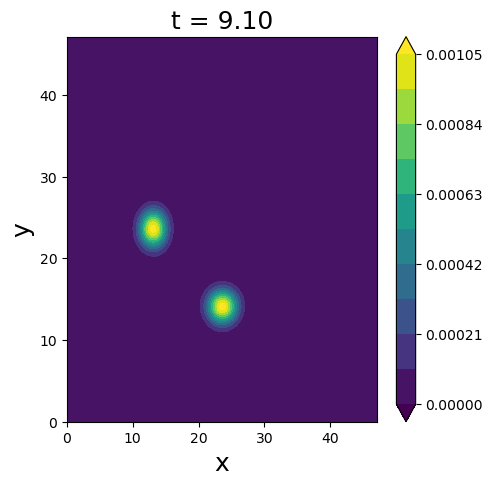

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


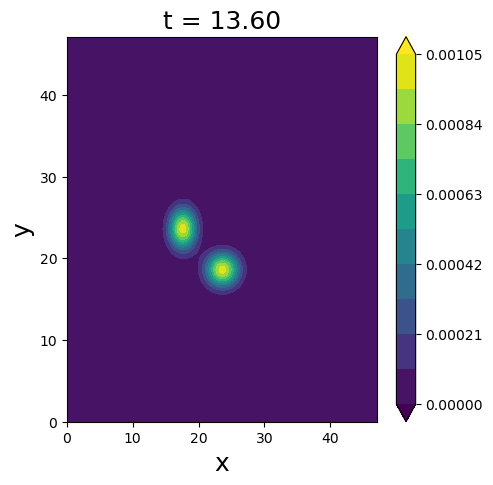

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


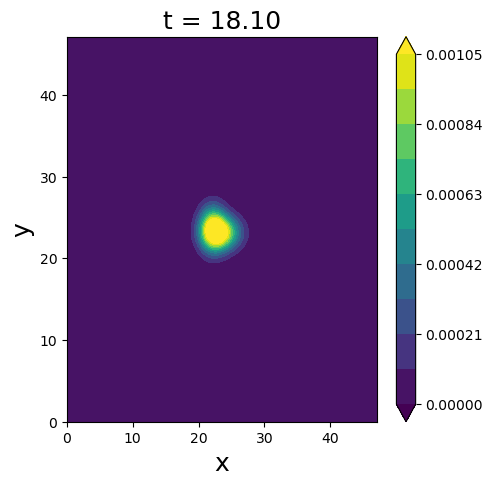

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


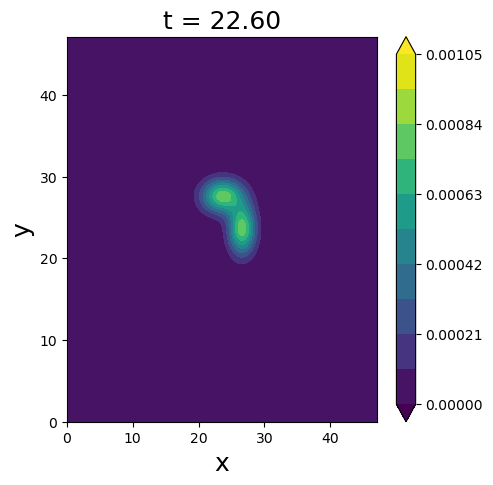

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


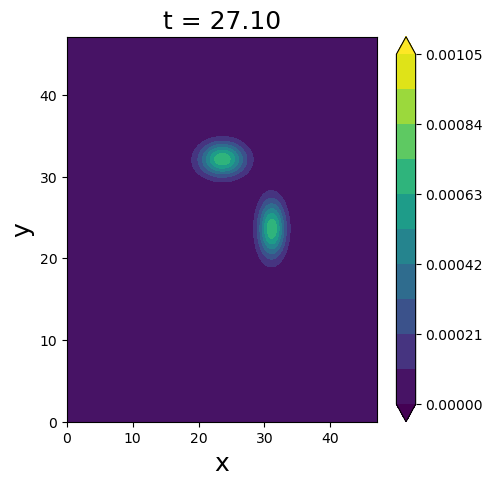

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


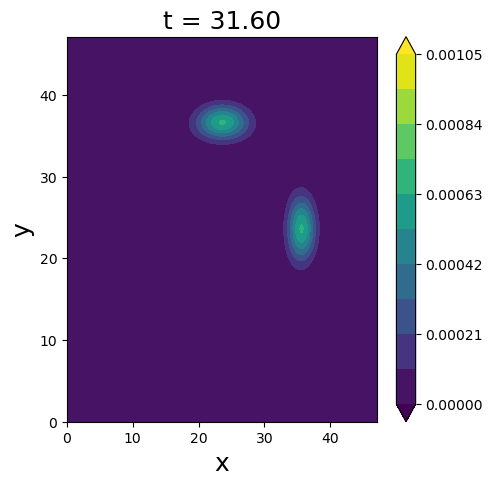

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


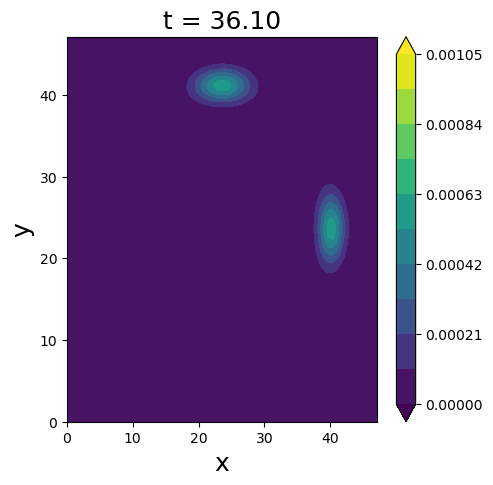

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


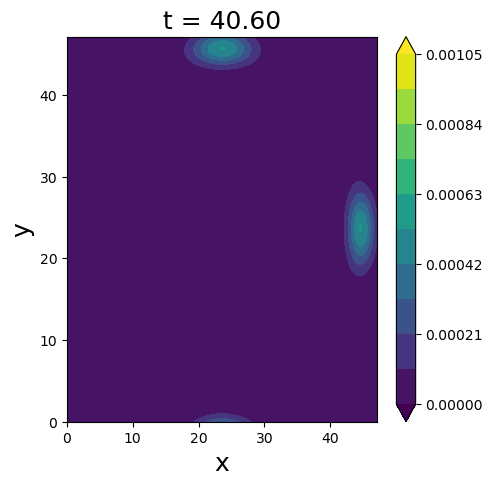

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


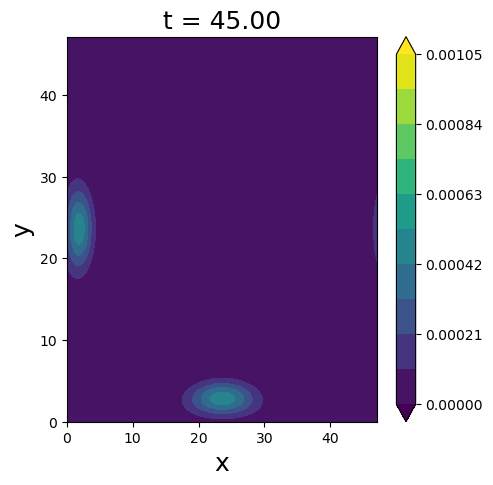

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


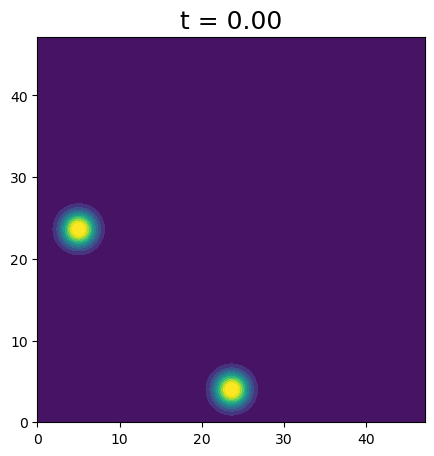

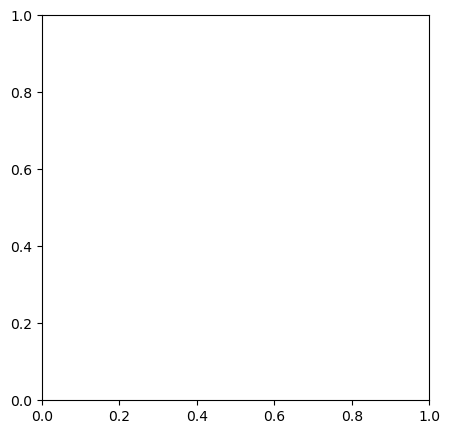

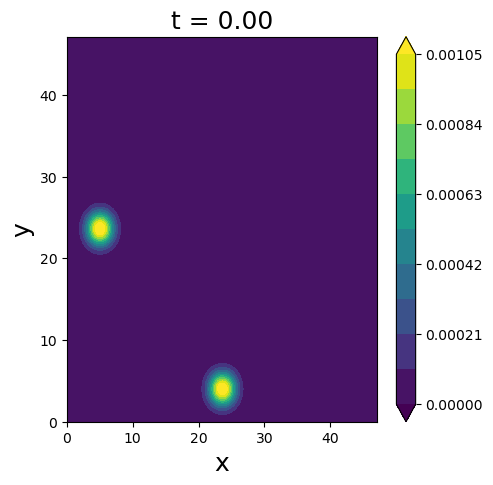

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


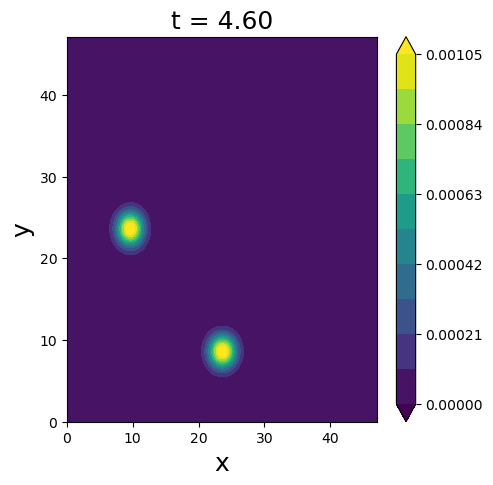

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


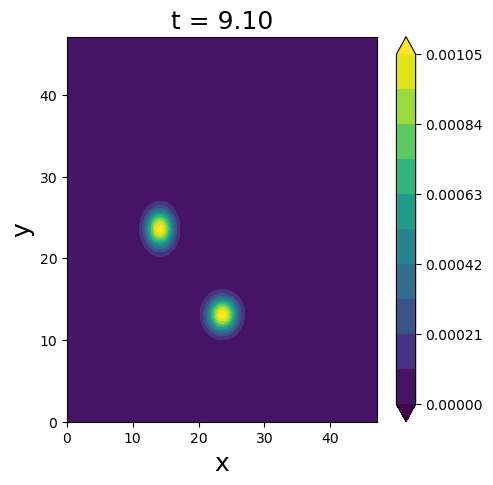

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


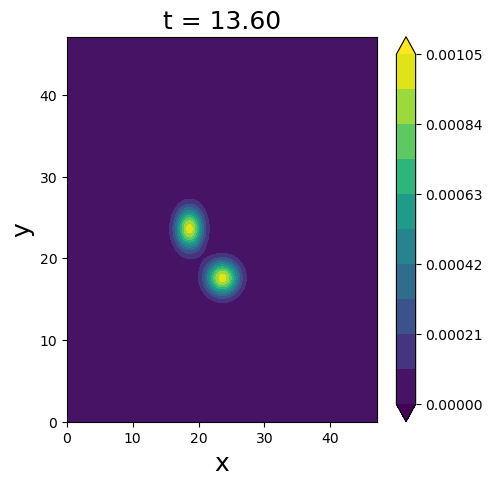

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


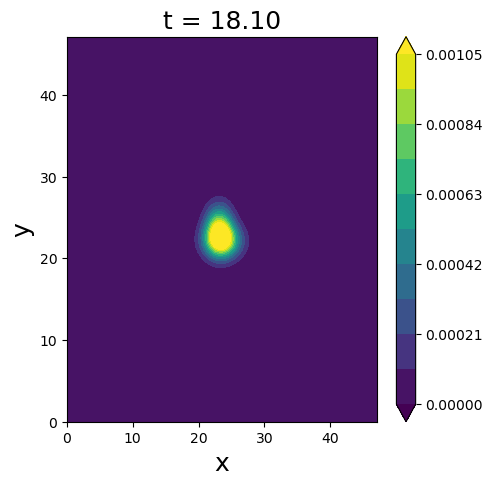

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


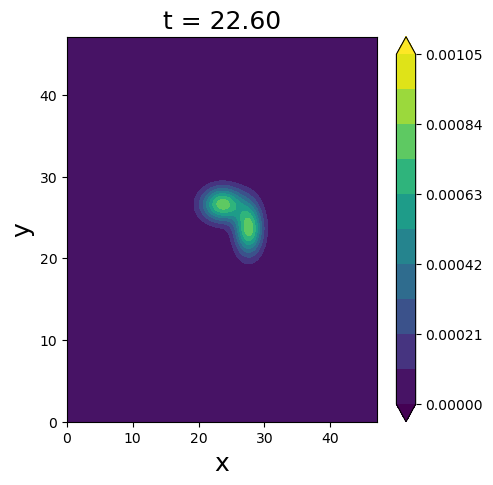

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


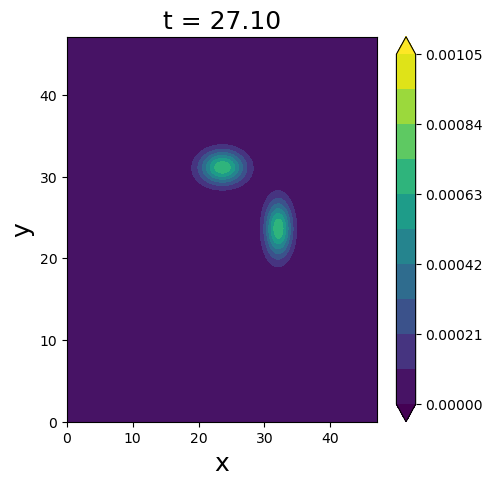

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


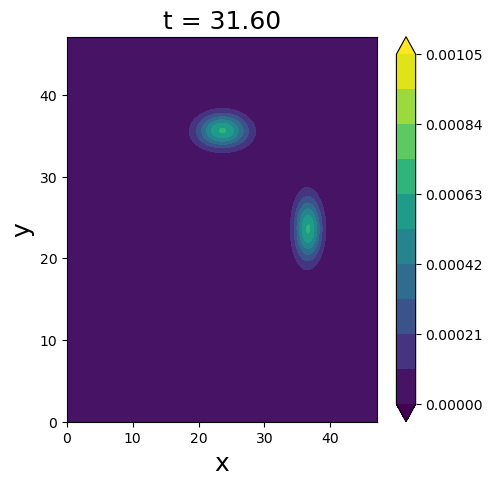

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


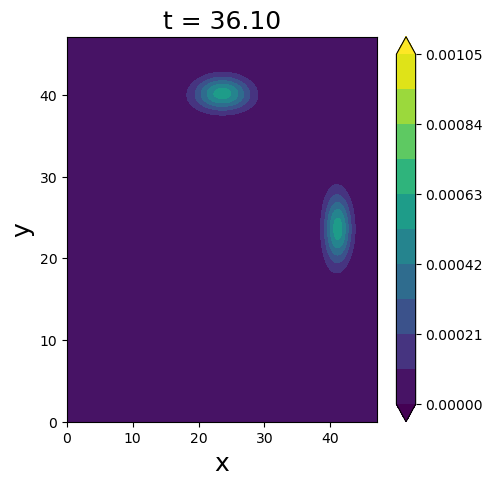

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


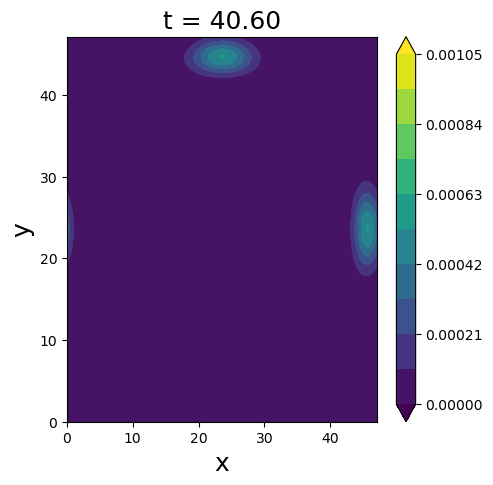

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


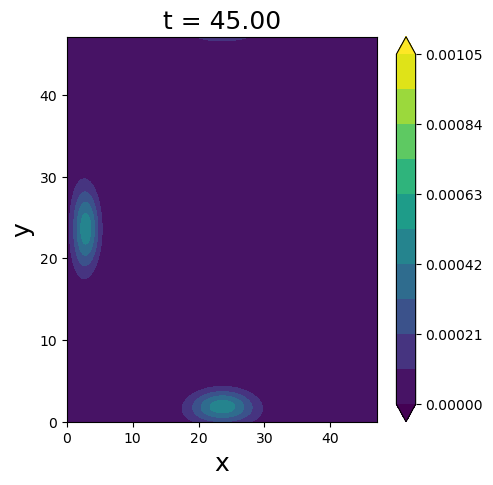

coincidence probability = 0.9329
deltax= 0.0
#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


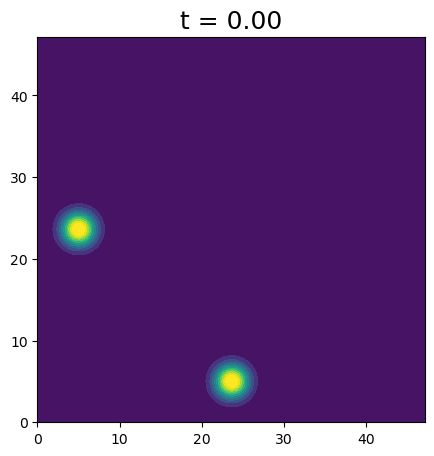

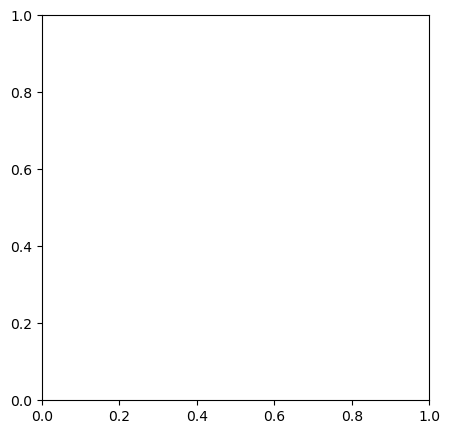

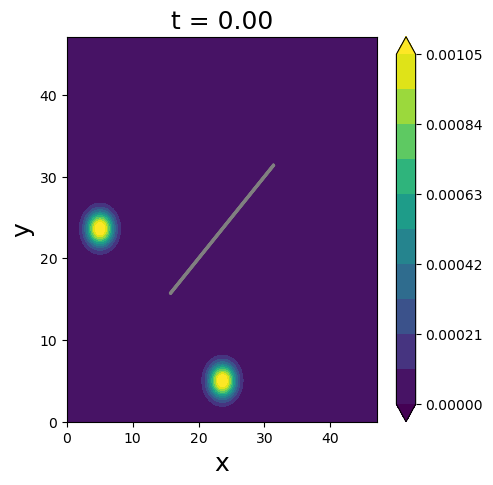

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


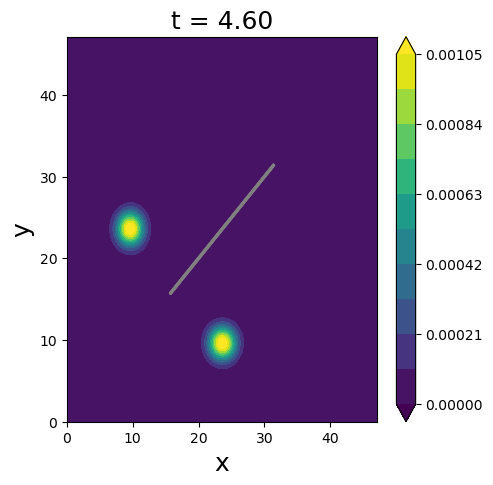

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02501 0.0 1e-05 -86.784
Total energy =  -76.75898
Total energy - econst =  10.02502


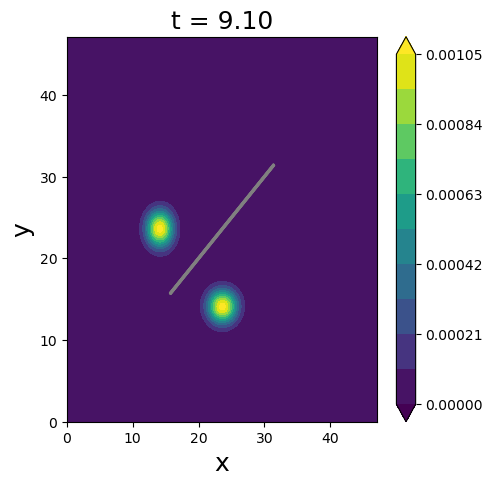

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.9975 0.00125 0.00125 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.98881 0.0 0.02098 -86.784
Total energy =  -76.77421
Total energy - econst =  10.00979


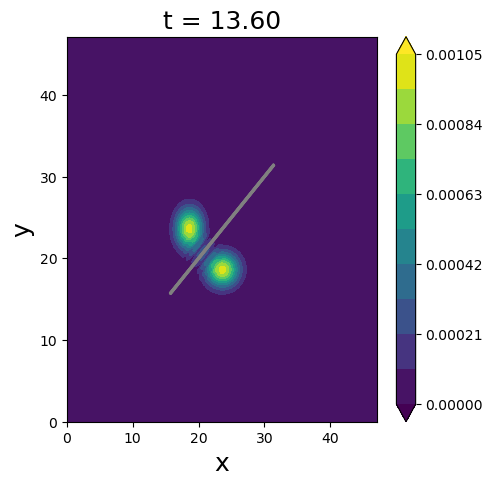

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.97039 0.0149 0.0149 0.00045
sum |c|^2= 1.00063
E_F, E_A, E_I, econst = 9.59165 0.00031 0.25436 -86.784
Total energy =  -76.93768
Total energy - econst =  9.84632


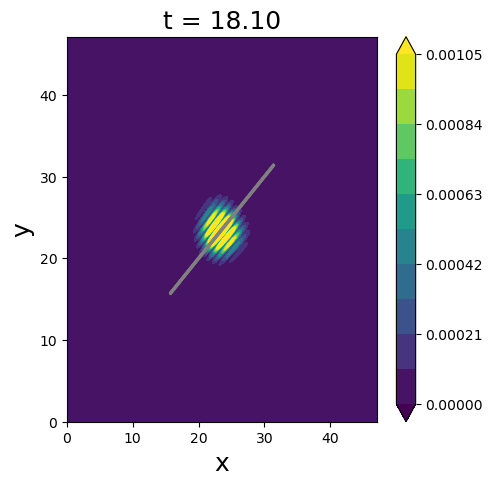

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99103 0.0045 0.0045 4e-05
sum |c|^2= 1.00006
E_F, E_A, E_I, econst = 9.89447 3e-05 0.07592 -86.784
Total energy =  -76.81359
Total energy - econst =  9.97041


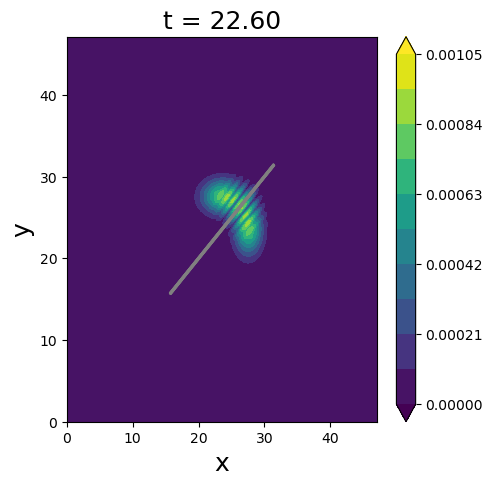

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99972 0.00014 0.00014 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02107 0.0 0.00228 -86.784
Total energy =  -76.76065
Total energy - econst =  10.02335


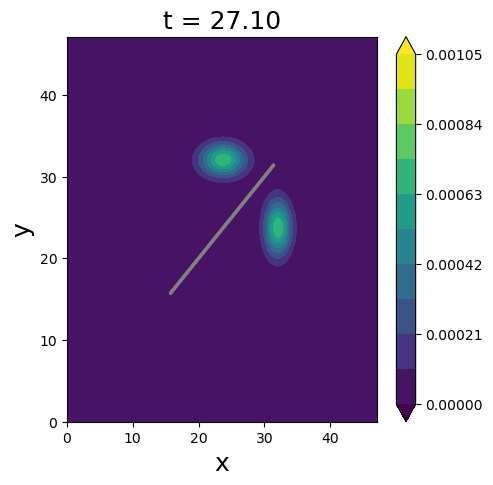

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


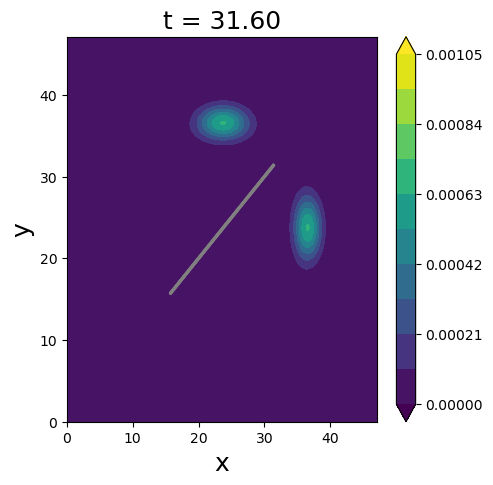

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


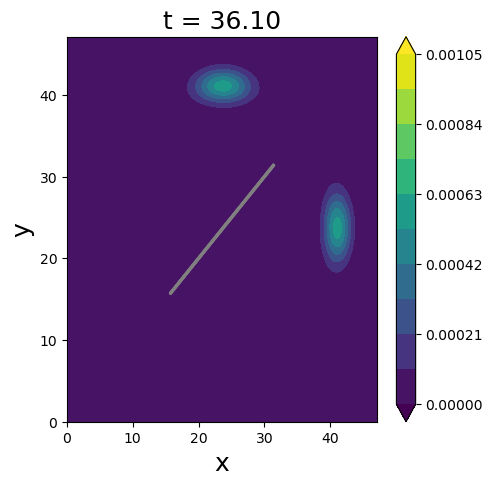

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


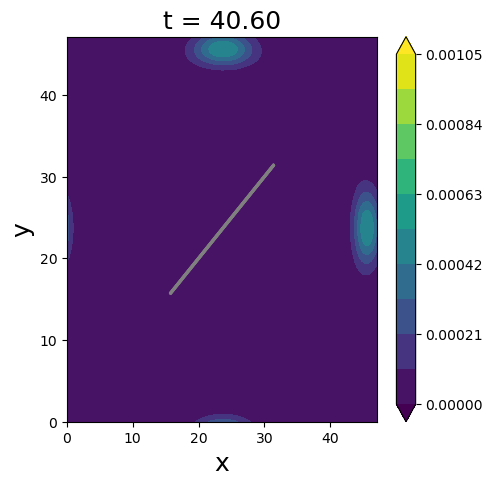

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


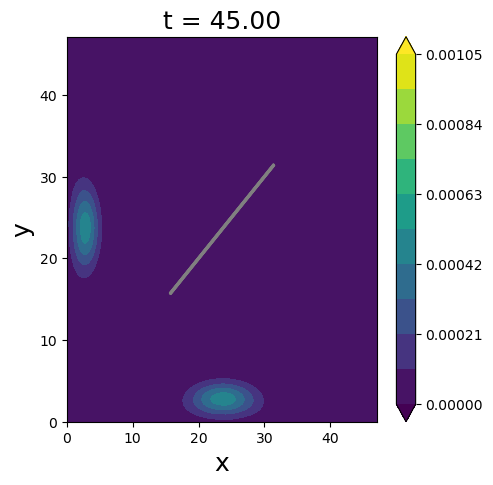

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


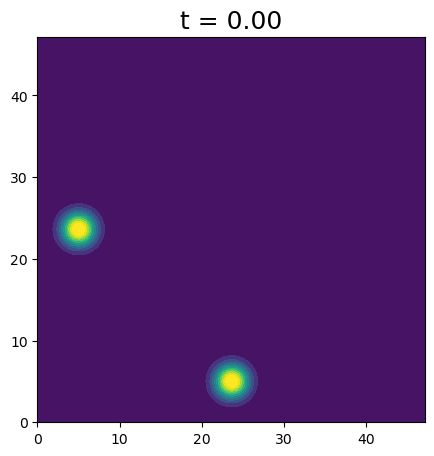

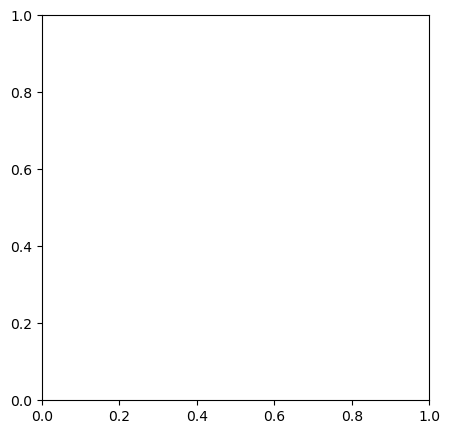

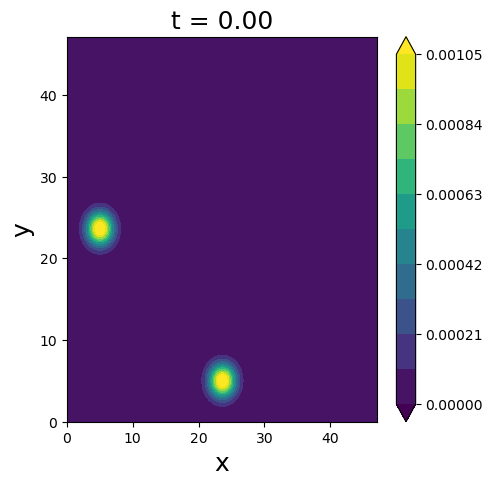

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


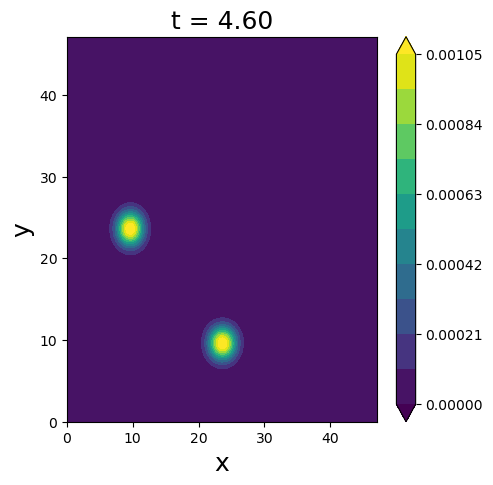

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


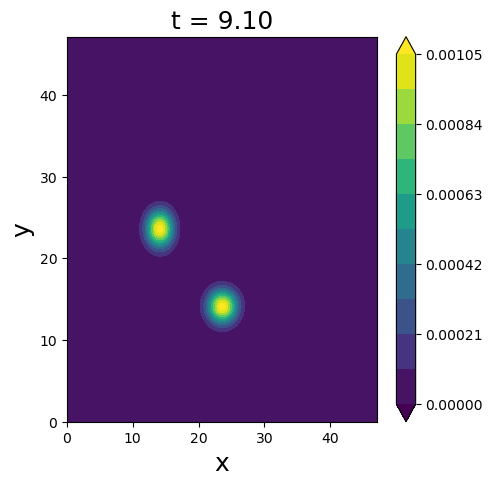

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


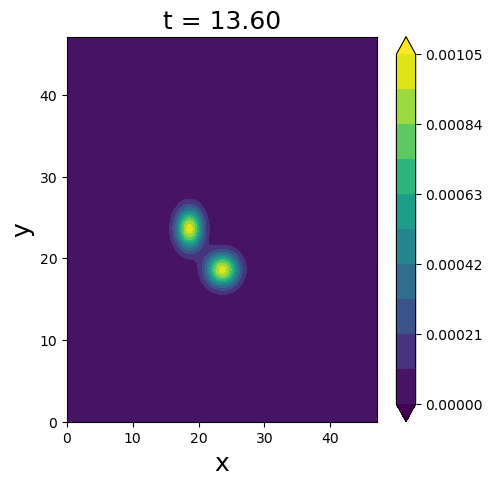

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


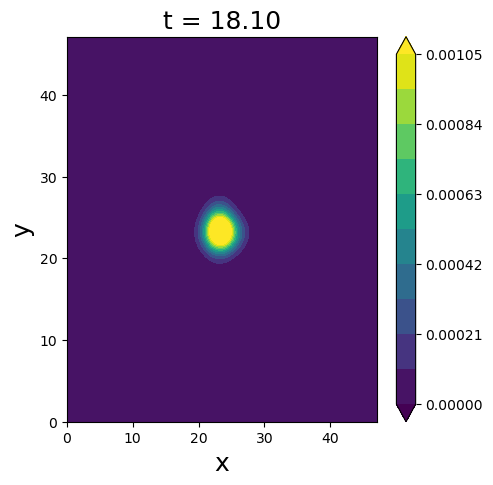

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


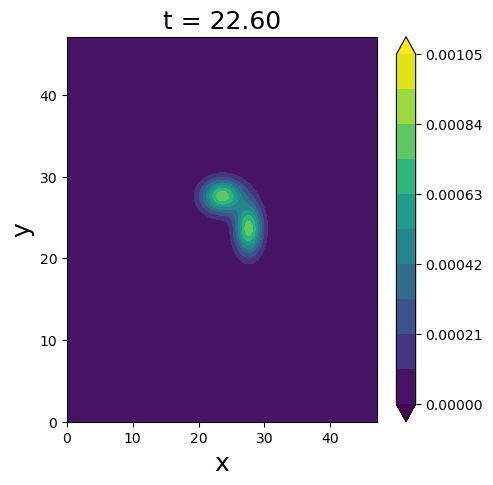

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


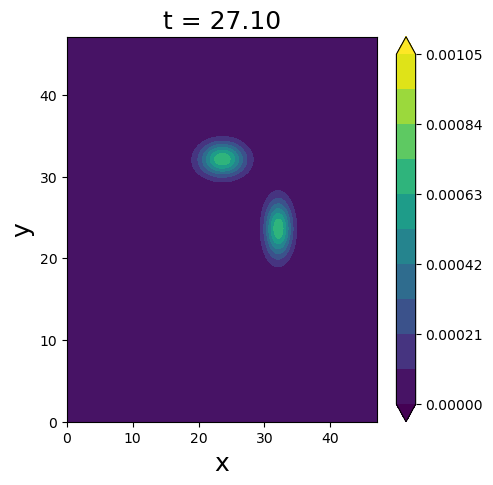

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


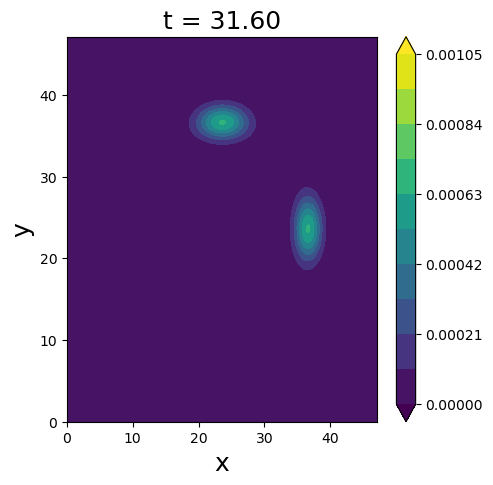

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


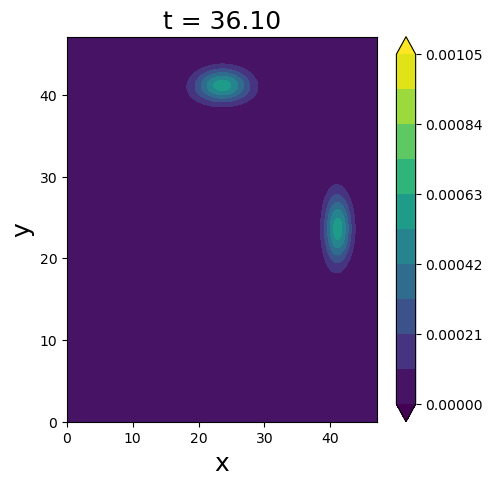

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


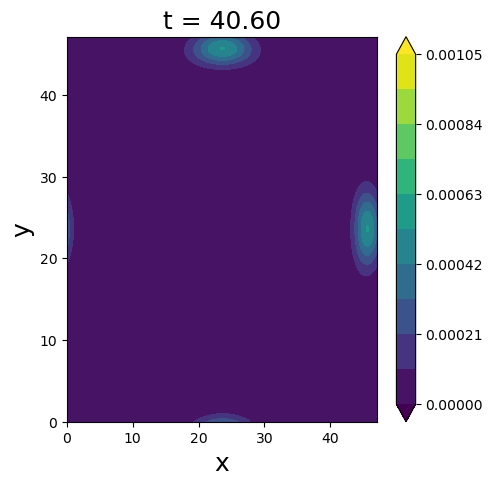

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


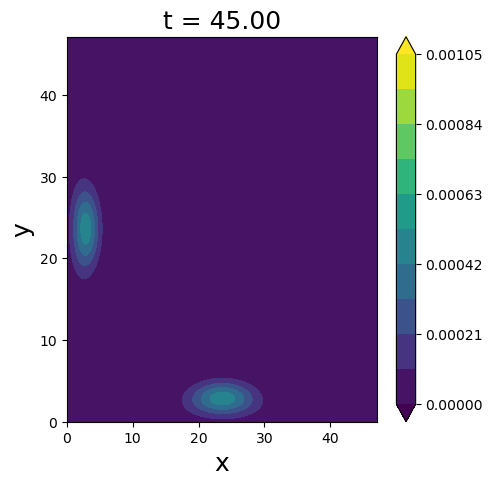

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


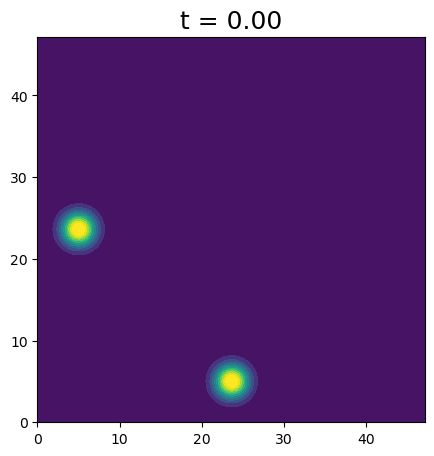

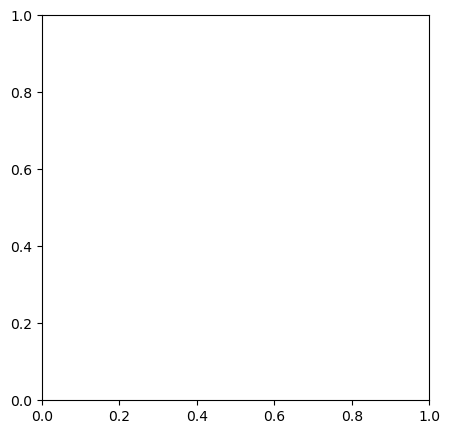

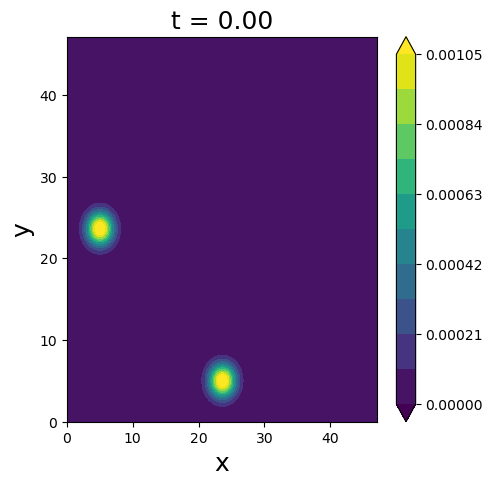

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


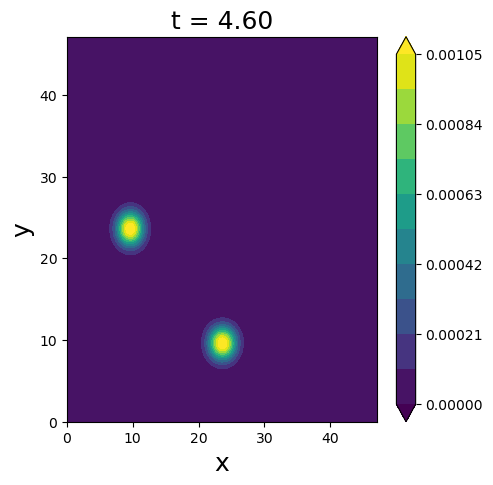

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


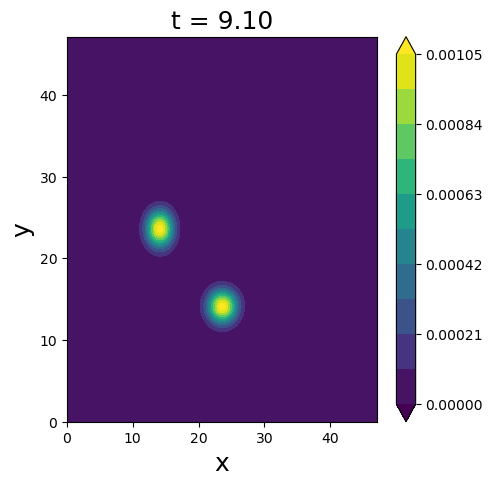

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


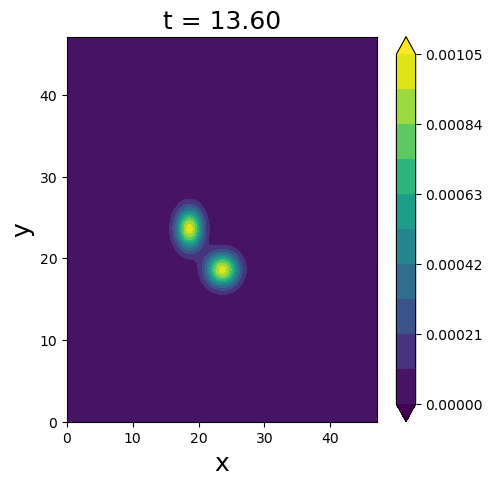

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


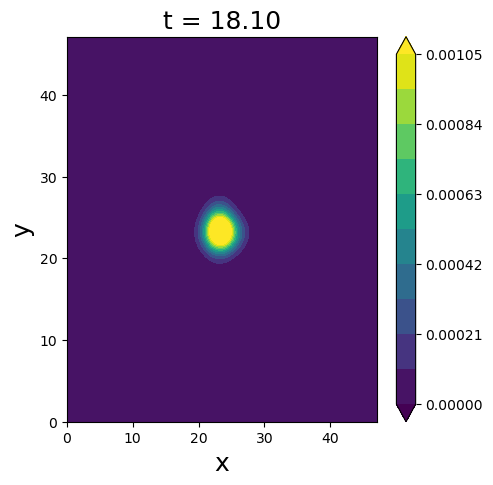

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


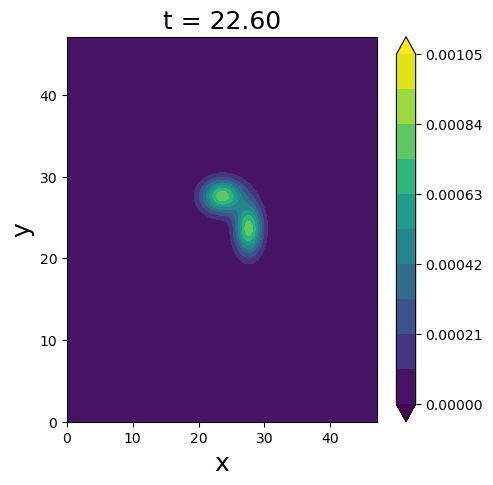

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


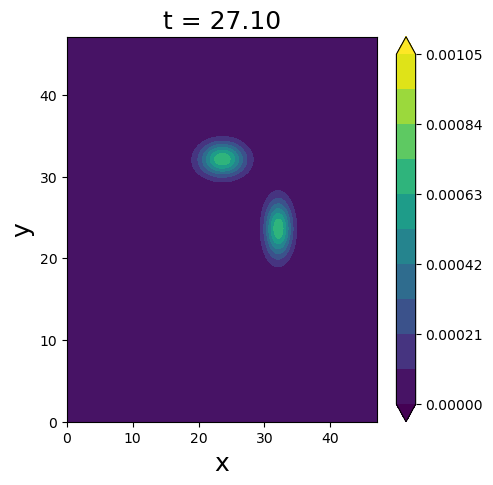

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


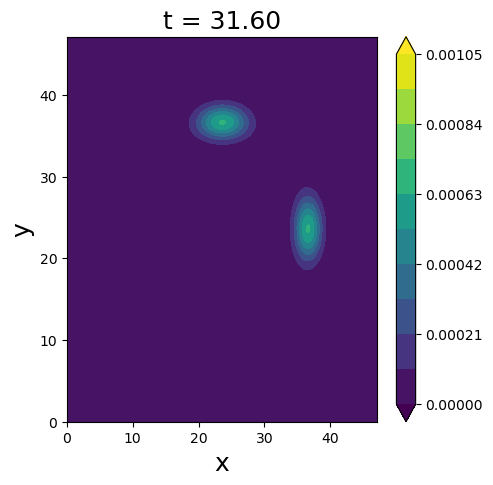

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


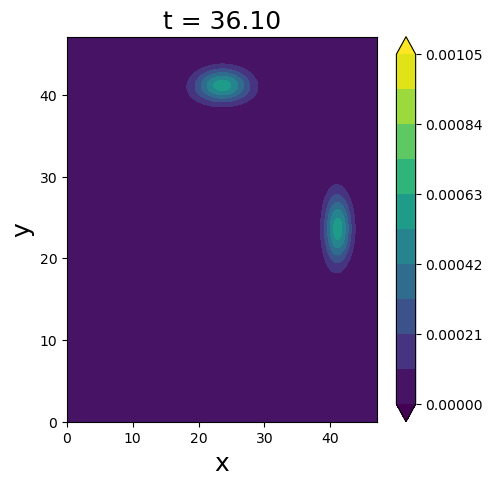

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


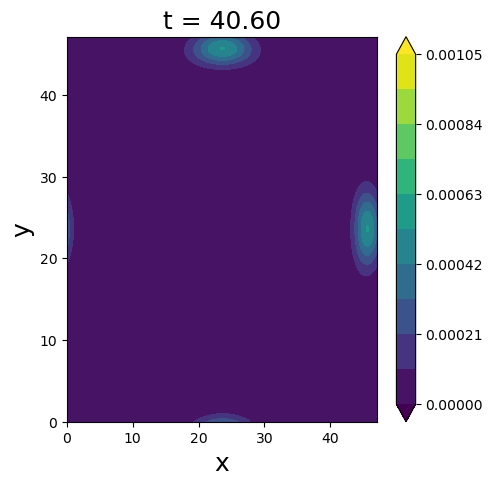

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -0.0
Total energy =  10.02503
Total energy - econst =  10.02503


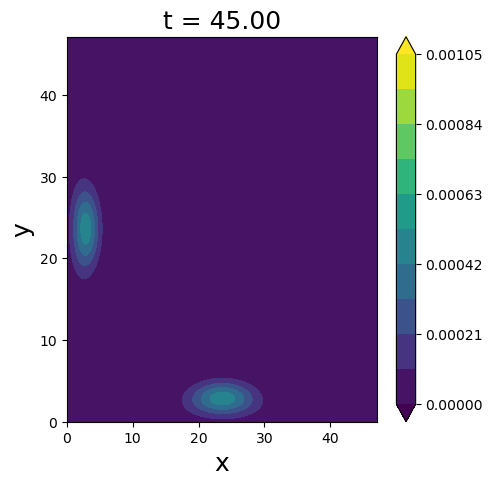

coincidence probability = 0.9912
CPU times: user 5min 16s, sys: 15.8 s, total: 5min 31s
Wall time: 5min 31s


In [8]:
%%time
## MAIN loop
yy = []
### Path-length-shift values
#xx = [-10.0, -8.0, -6.0, -5.0, -4.0, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0., 0.5, 1., 1.5, 2.,2.5, 3., 4., 5., 6., 8., 10.]
### short ver.
xx = [-10.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.]
for deltax in xx:
    print("deltax=", deltax)
    ## set beam
    x0_a_deltax = x0_a + deltax
    sa=[x0_a_deltax, y0_a, kx0_a, ky0_a, sigma_x_a, sigma_y_a]
    sb=[x0_b,        y0_b, kx0_b, ky0_b, sigma_x_b, sigma_y_b]
    beam_a = QObeam(N, L, *sa)
    beam_b = QObeam(N, L, *sb)
    ## time evolution
    qosim = QOsimulator_2ph(N, L, dt, beams=[beam_a,beam_b], objects=[splitter])
    init_phi = qosim.gen_initial_state()
    phi, ims = perfrom(init_phi, qosim, show_tlist, t_max, dt, deltax)
    
    ## reference states (2-photon simulation without beam splitter)
    sa_ref=[x0_a_deltax, y0_a, kx0_a, ky0_a, sigma_x_a, sigma_y_a]
    sb_ref=[x0_b,        y0_b, kx0_b, ky0_b, sigma_x_b, sigma_y_b]
    beam_h_ref = QObeam(N, L, *sa_ref)
    beam_v_ref = QObeam(N, L, *sb_ref)
    qosim_ref1 = QOsimulator_2ph(N, L, dt, beams=[beam_h_ref,beam_v_ref], objects=[])
    init_phi_ref1 = qosim_ref1.gen_initial_state()
    phi_ref1, ims_ref1  = perfrom(init_phi_ref1, qosim_ref1, show_tlist, t_max, dt, deltax)
    ##
    sa_ref=[x0_a, y0_a,          kx0_a, ky0_a, sigma_x_a, sigma_y_a]
    sb_ref=[x0_b, y0_b + deltax, kx0_b, ky0_b, sigma_x_b, sigma_y_b]
    beam_h_ref = QObeam(N, L, *sa_ref)
    beam_v_ref = QObeam(N, L, *sb_ref)
    qosim_ref2 = QOsimulator_2ph(N, L, dt, beams=[beam_h_ref,beam_v_ref], objects=[])
    init_phi_ref2 = qosim_ref2.gen_initial_state()
    phi_ref2, ims_ref2 = perfrom(init_phi_ref2, qosim_ref2, show_tlist, t_max, dt, deltax)
    
    ## constructing bases
    c_moved_h_base = phi_ref1.phph.states[0].rr["1"]*(2.0)**(1/4) # norm=1 base
    c_fixed_v_base = phi_ref1.phph.states[0].rr["2"]*(2.0)**(1/4) # norm=1 base
    c_fixed_h_base = phi_ref2.phph.states[0].rr["1"]*(2.0)**(1/4) # norm=1 base
    c_moved_v_base = phi_ref2.phph.states[0].rr["2"]*(2.0)**(1/4) # norm=1 base
    ##
    hh_states = Qstates("manual", N, [{"1":c_fixed_h_base, "2":c_moved_h_base}, {"1":c_moved_h_base, "2":c_fixed_h_base}], "rr")
    hh_states = hh_states.normalize()
    vv_states = Qstates("manual", N, [{"1":c_fixed_v_base, "2":c_moved_v_base}, {"1":c_moved_v_base, "2":c_fixed_v_base}], "rr")
    vv_states = vv_states.normalize()

    ## coincidence probability
    hh_prob = abs(Qstates.innerproduct(hh_states, phi.phph))**2
    vv_prob = abs(Qstates.innerproduct(vv_states, phi.phph))**2
    print("coincidence probability =", round(hh_prob+vv_prob,4)) 
    yy.append( hh_prob+vv_prob)

In [9]:
xx = np.array(xx)
yy = np.array(yy)

In [10]:
#### Analytical calculation
sigma = 2.0
yy_analytic = []
for deltax in xx:
    yy_analytic.append(np.exp(-0.5*(deltax/sigma)**2.0))
yy_analytic = np.array(yy_analytic)

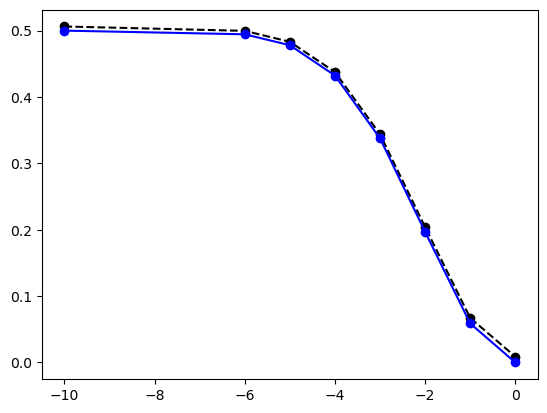

In [11]:
### HOM dip
plt.plot(xx, 1.0-yy, color="k", linestyle='dashed', marker="o")
plt.plot(xx, 0.5*(1-yy_analytic), color="b", marker="o")

# time evolution of coincidence density

#------- t= 0.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


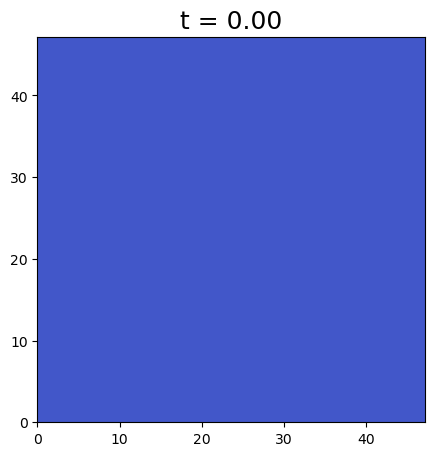

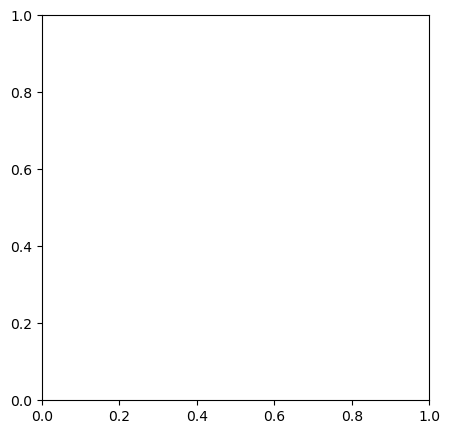

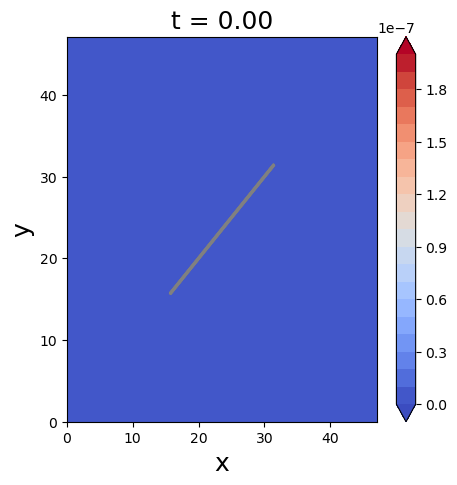

#------- t= 4.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


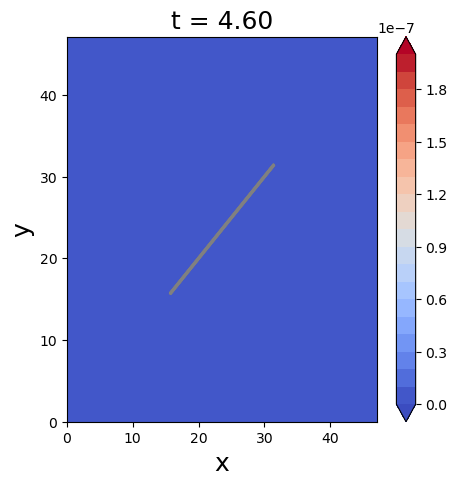

#------- t= 9.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02501 0.0 1e-05 -86.784
Total energy =  -76.75898
Total energy - econst =  10.02502


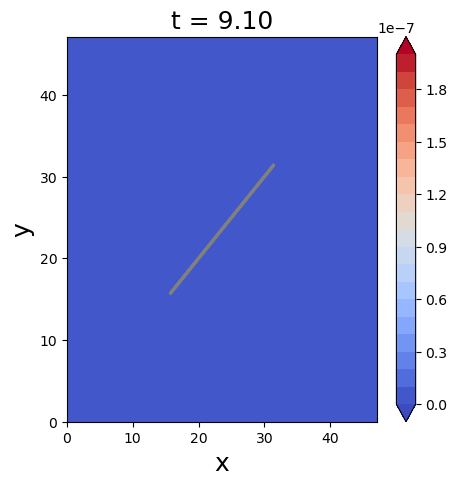

#------- t= 13.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.9975 0.00125 0.00125 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 9.98881 0.0 0.02098 -86.784
Total energy =  -76.77421
Total energy - econst =  10.00979


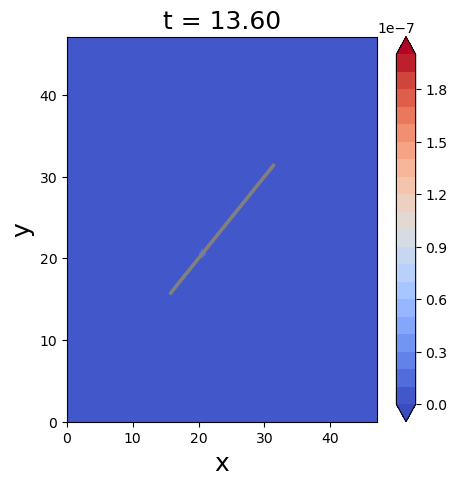

#------- t= 18.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.97039 0.0149 0.0149 0.00045
sum |c|^2= 1.00063
E_F, E_A, E_I, econst = 9.59165 0.00031 0.25436 -86.784
Total energy =  -76.93768
Total energy - econst =  9.84632


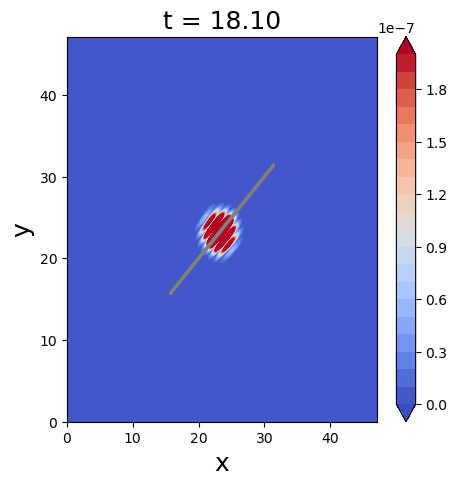

#------- t= 22.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99103 0.0045 0.0045 4e-05
sum |c|^2= 1.00006
E_F, E_A, E_I, econst = 9.89447 3e-05 0.07592 -86.784
Total energy =  -76.81359
Total energy - econst =  9.97041


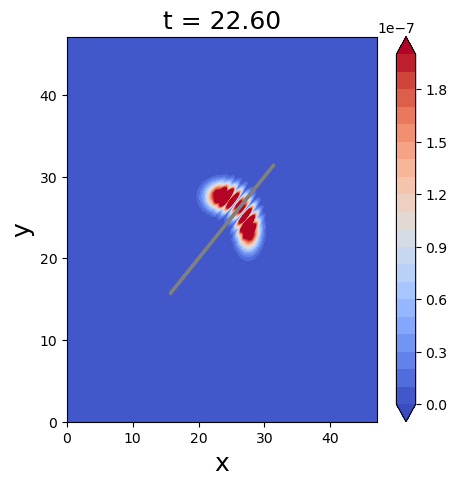

#------- t= 27.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  0.99972 0.00014 0.00014 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02107 0.0 0.00228 -86.784
Total energy =  -76.76065
Total energy - econst =  10.02335


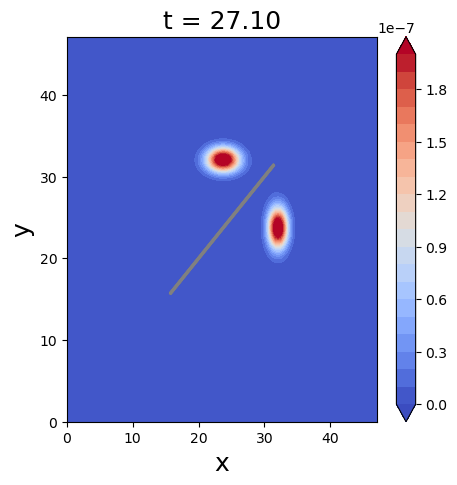

#------- t= 31.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


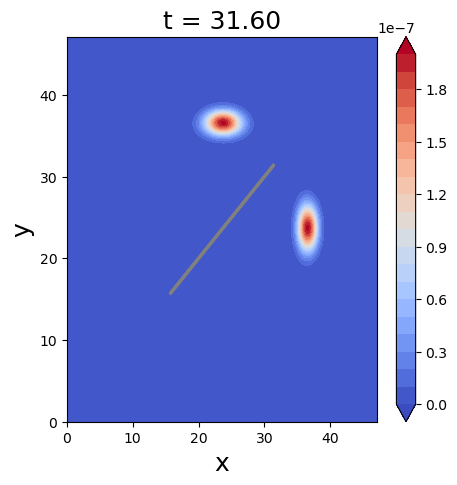

#------- t= 36.1
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


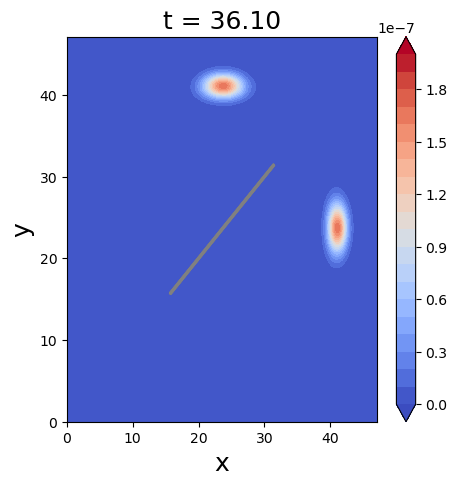

#------- t= 40.6
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


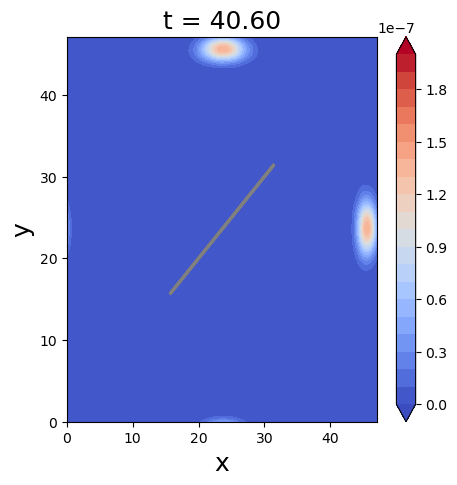

#------- t= 45.0
|c_2ph|^2, |c_A,ph|^2, |c_ph,A|^2,|c_A,A|^2 =  1.0 0.0 0.0 0.0
sum |c|^2= 1.0
E_F, E_A, E_I, econst = 10.02503 0.0 0.0 -86.784
Total energy =  -76.75897
Total energy - econst =  10.02503


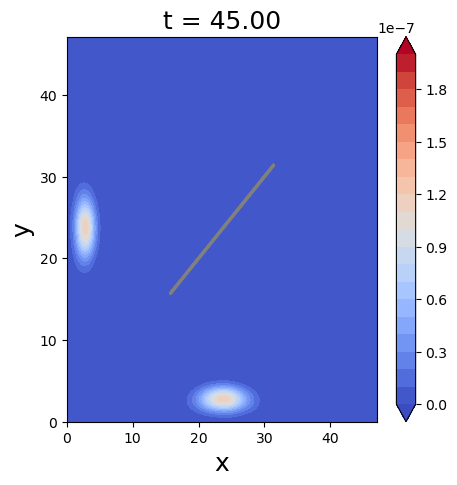

CPU times: user 13.8 s, sys: 405 ms, total: 14.2 s
Wall time: 14.2 s


In [12]:
%%time
## Path length shift
deltax=0
## set beam
x0_a_deltax = x0_a + deltax
sa=[x0_a_deltax, y0_a, kx0_a, ky0_a, sigma_x_a, sigma_y_a]
sb=[x0_b,        y0_b, kx0_b, ky0_b, sigma_x_b, sigma_y_b]
beam_a = QObeam(N, L, *sa)
beam_b = QObeam(N, L, *sb)
## initialization
qosim = QOsimulator_2ph(N, L, dt, beams = [beam_a, beam_b], objects=[splitter])
init_phi = qosim.gen_initial_state()
## time evolution
phi, ims = perfrom(init_phi, qosim, show_tlist, t_max, dt, deltax, plot_coincidence_density=True)

## Animation

In [13]:
# ani = animation.ArtistAnimation(qosim.qosim_1ph_a.fig, ims, interval=100)
# ani.save("hom.gif", writer="imagemagick")